In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from tqdm.notebook import tqdm_notebook

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,auc, roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC



## Read data 

In [235]:
# data train include provider ID and labels
Train = pd.read_csv("data/Train-1542865627584.csv")

# include beneficiary KYC details like health conditions,region
Train_Beneficiarydata = pd.read_csv("data/Train_Beneficiarydata-1542865627584.csv")

# include the claims filed for those patients who are admitted in the hospitals
Train_Inpatientdata=pd.read_csv("data/Train_Inpatientdata-1542865627584.csv")

# include the claims filed for those patients who visit hospitals and not admitted in it.
Train_Outpatientdata=pd.read_csv("data/Train_Outpatientdata-1542865627584.csv")


In [236]:
print("Train\n", Train.shape)
print("Train_Beneficiarydata\n", Train_Beneficiarydata.shape)
print("Train_Inpatientdata\n", Train_Inpatientdata.shape)
print("Train_Outpatientdata\n", Train_Outpatientdata.shape)


Train
 (5410, 2)
Train_Beneficiarydata
 (138556, 25)
Train_Inpatientdata
 (40474, 30)
Train_Outpatientdata
 (517737, 27)


## Functions

In [237]:
def agg_calculation(dataset,
                        groupby_col = '',
                        agg_col = '',
                        sort_col = '',
                        agg_method_lst = [],
                        col_name_lst = []
                       ):
    """This function makes aggregation on specific column"""

    grouped = dataset.groupby(groupby_col)[agg_col].agg(agg_method_lst).reset_index()
    grouped.columns = col_name_lst
    grouped = grouped.sort_values(by = [sort_col], ascending=False).reset_index(drop = True)

    return grouped


In [238]:
# def get_top_5_codes(group, col=''):
#     top_5 = group[col].value_counts().nlargest(5).index.tolist()
#     return top_5

def get_top_5_codes(group, col=''):
    top_5 = group[col].value_counts().nlargest(1).index.tolist()
    return top_5

In [239]:
# Function to count occurrences of values across multiple columns and find top 5
# def top_5_across_columns(df, columns):
#     counts = {}
#     for col in columns:
#         for val in df[col]:
#             if pd.notnull(val):
#                 if val in counts:
#                     counts[val] += 1
#                 else:
#                     counts[val] = 1
#     top_5 = sorted(counts, key=counts.get, reverse=True)[:5]
#     return top_5


def top_5_across_columns(df, columns):
    counts = {}
    for col in columns:
        for val in df[col]:
            if pd.notnull(val):
                if val in counts:
                    counts[val] += 1
                else:
                    counts[val] = 1
    top_5 = sorted(counts, key=counts.get, reverse=True)[:1]
    return top_5

In [240]:
#check for same physician in all three physician columns
def physician_same(row):
    atten_oper = row['AttendingPhysician'] == row['OperatingPhysician']
    oper_other = row['OperatingPhysician'] == row['OtherPhysician']
    atten_other = row['AttendingPhysician'] == row['OtherPhysician']
    
    # atten = oper = other
    if atten_oper == True and oper_other == True:
        return 1
    
    # atten = oper != other
    elif atten_oper == True and oper_other == False:
        return 2
    
    # atten = other != oper
    elif atten_other == True and oper_other == False:
        return 2
    
    # atten != other = oper
    elif atten_other == False and oper_other == True:
        return 2
    
    # atten != other != oper
    else:
        return 3

In [241]:
def accuracy_score(y_true,y_pred):
    correct = 0
    for true, pred in zip(y_true,y_pred):
        if true == pred:
            correct += 1
    return correct / (len(y_true))

In [242]:
def precision_score(y_true,y_pred):
    tp, fp = 0, 0
    for true, pred in zip(y_true,y_pred):
        if true == 1 and pred == 1:
            tp += 1
        elif true ==0 and pred == 1:
            fp +=1
    
    if tp + fp == 0:
        return 0

    return tp / (tp+fp)

In [243]:
def recall_score(y_true,y_pred):
    tp, fn = 0, 0
    for true, pred in zip(y_true,y_pred):
        if true == 1 and pred == 1:
            tp += 1
        elif true == 1 and pred == 0:
            fn +=1
    
    if tp + fn == 0:
        return 0

    return tp / (tp+fn)

In [244]:
def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    if precision + recall == 0:
        return 0
    return (2 * (precision * recall)) / (precision + recall)

In [245]:
def auc_value(true_labels, predicted_probs):

    # Step 1: Sort the predictions
    sorted_indices = np.argsort(predicted_probs)[::-1]
    sorted_true_labels = true_labels[sorted_indices]
    sorted_predicted_probs = predicted_probs[sorted_indices]

    # Step 2: Calculate TPR and FPR
    TPR = []
    FPR = []

    # Number of positive instances
    P = sum(true_labels)

    # Number of negative instances
    N = len(true_labels) - P


    for threshold in sorted_predicted_probs:
        tp = 0
        fp = 0
        for i in range(len(sorted_predicted_probs)):
            if (sorted_predicted_probs[i] >= threshold) & (sorted_true_labels[i] == 1):
                tp += 1
            if (sorted_predicted_probs[i] >= threshold) & (sorted_true_labels[i] == 0):
                fp += 1
        
        TPR.append(tp/P)
        FPR.append(fp/N)

    # # second way
    # for threshold in thresholds:
    #     # Predictions based on the current threshold
    #     TP = sum((sorted_predicted_probs >= threshold) & (sorted_true_labels == 1))
    #     FP = sum((sorted_predicted_probs >= threshold) & (sorted_true_labels == 0))
        
    #     TPR.append(TP / P)
    #     FPR.append(FP / N)

    # Add (0,0) to the curve (initial point)
    TPR = [0] + TPR + [1]
    FPR = [0] + FPR + [1]

    # Step 3: Calculate AUC using the trapezoidal rule: the sum of areas of trapezoids formed by dividing the interval into 𝑛 equal subintervals.
    auc = 0
    for i in range(1, len(TPR)):
        auc += (FPR[i]-FPR[i-1])*(TPR[i-1]+TPR[i])/2

    return auc, FPR, TPR


In [246]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

In [247]:
def roc_curve_plot(train_auc, train_FPR, train_TPR, val_auc, val_FPR, val_TPR):
    plt.figure(figsize = (8,6))
    plt.plot(val_FPR, val_TPR, lw=2, label = f'Validation AUC = {val_auc*100: .2f}%')
    plt.plot(train_FPR, train_TPR, lw=2, label = f'Train AUC = {train_auc*100: .2f}%')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc = 'lower right')
    plt.show()


In [248]:
def model_performence_check(model,X_train,X_val,y_train,y_val):
    y_pred = model.predict(X_val)
    val_true_labels = y_val.values
    val_predicted_probs = model.predict_proba(X_val)[:, 1]
    train_true_labels = y_train.values
    train_predicted_probs = model.predict_proba(X_train)[:, 1]

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    val_auc, val_FPR, val_TPR = auc_value(val_true_labels, val_predicted_probs)
    train_auc, train_FPR, train_TPR = auc_value(train_true_labels, train_predicted_probs)
    conf_matrix = confusion_matrix(y_val, y_pred)
    plot_confusion_matrix(conf_matrix)
    roc_curve_plot(train_auc, train_FPR, train_TPR, val_auc, val_FPR, val_TPR)

    print(f"Accuracy: {accuracy*100: .2f}%")
    print(f"Precision: {precision*100: .2f}%")
    print(f"Recall: {recall*100: .2f}%")
    print(f"F1-score: {f1*100: .2f}%")
    print(f"AUC Value: {val_auc*100: .2f}%")

    return accuracy, recall, precision, val_auc


In [249]:
def model_comp(model=[],metric1=[],metric2=[],metric3=[], metric4=[], set_ylabel='',set_title='',metric1_label='',metric2_label='', metric3_label='',metric4_label=''):
    
    x = np.arange(len(model))  # the label locations
    width = 0.2  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(12,5))
    rects1 = ax.bar(x - 1.5*width, metric1, width, label=metric1_label, color='teal')
    rects2 = ax.bar(x - 0.5*width, metric2, width, label=metric2_label, color='orange')
    rects3 = ax.bar(x + 0.5*width, metric3, width, label=metric3_label, color='red')
    rects4 = ax.bar(x + 1.5*width, metric4, width, label=metric4_label)
    
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(set_ylabel)
    ax.set_title(set_title)
    ax.set_xticks(x)
    ax.set_xticklabels(model)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Adjust the legend position
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    
    fig.tight_layout()

    plt.show()

## Create Features

### Inpatient

In [250]:
print('inpatient columns:\n',  Train_Inpatientdata.columns)
Train_Inpatientdata.head(5)

inpatient columns:
 Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6'],
      dtype='object')


BeneID   ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0  BENE11001  CLM46614   2009-04-12  2009-04-18  PRV55912   
1  BENE11001  CLM66048   2009-08-31  2009-09-02  PRV55907   
2  BENE11001  CLM68358   2009-09-17  2009-09-20  PRV56046   
3  BENE11011  CLM38412   2009-02-14  2009-02-22  PRV52405   
4  BENE11014  CLM63689   2009-08-13  2009-08-30  PRV56614   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                   26000          PHY390922                NaN   
1                    5000          PHY318495          PHY318495   
2                    5000          PHY372395                NaN   
3                    5000          PHY369659          PHY392961   
4                   10000          PHY379376          PHY398258   

  OtherPhysician AdmissionDt  ... ClmDiagnosisCode_7  ClmDiagnosisCode_8  \
0            NaN  2009-04-12  ...               2724               19889   
1            NaN  2009-08-31  ...                NaN                 NaN   
2      PHY324689  2009-09-17  ...                NaN                 NaN   
3      PHY349768  2009-02-14  ...              25062               40390   
4            NaN  2009-08-13  ...               5119               29620   

  ClmDiagnosisCode_9 ClmDiagnosisCode_10 ClmProcedureCode_1  \
0               5849                 NaN                NaN   
1                NaN                 NaN             7092.0   
2                NaN                 NaN                NaN   
3               4019                 NaN              331.0   
4              20300                 NaN             3893.0   

  ClmProcedureCode_2 ClmProcedureCode_3 ClmProcedureCode_4 ClmProcedureCode_5  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   

  ClmProcedureCode_6  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 30 columns]

In [251]:
# check duplicates
print(len(list(Train_Inpatientdata.ClaimID.value_counts()==1)))
print(len(list(Train_Inpatientdata['ClaimID'].unique())))

40474
40474


#### 1. Num of inpatient claims for each provider

In [252]:
df1 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'ClaimID',
                    sort_col = 'ip_claims_num',
                    agg_method_lst = ['count'],
                    col_name_lst = ['Provider', 'ip_claims_num']
                       )
df1

Provider  ip_claims_num
0     PRV52019            516
1     PRV55462            386
2     PRV54367            322
3     PRV53706            282
4     PRV55209            275
...        ...            ...
2087  PRV53515              1
2088  PRV53516              1
2089  PRV53600              1
2090  PRV56474              1
2091  PRV55764              1

[2092 rows x 2 columns]

#### 2. Average inpatient claims per patient

In [253]:
df2 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'BeneID',
                    sort_col = 'ip_patients_num',
                    agg_method_lst = ['nunique'],
                    col_name_lst = ['Provider', 'ip_patients_num']
                       )
df_merged = df1.merge(df2, how = 'outer', on = 'Provider')
df_merged['avg_ip_claims_per_pat'] = (df_merged['ip_claims_num']/df_merged['ip_patients_num']).round(2)
df_merged 

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat
0     PRV52019            516              458                   1.13
1     PRV55462            386              308                   1.25
2     PRV54367            322              279                   1.15
3     PRV53706            282              262                   1.08
4     PRV55209            275              243                   1.13
...        ...            ...              ...                    ...
2087  PRV53515              1                1                   1.00
2088  PRV53516              1                1                   1.00
2089  PRV53600              1                1                   1.00
2090  PRV56474              1                1                   1.00
2091  PRV55764              1                1                   1.00

[2092 rows x 4 columns]

#### 3. Average inpatient reimbursement amount per claim

In [254]:
df3 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'InscClaimAmtReimbursed',
                    sort_col = 'ip_reimbursed',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'ip_reimbursed']
                       )
df_merged = df_merged.merge(df3, how = 'outer', on = 'Provider')
df_merged['avg_ip_reimbursement_per_claim'] = (df_merged['ip_reimbursed']/df_merged['ip_claims_num']).round(2)
df_merged 

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  
0           5580870                        10815.64  
1           4260100                        11036.53  
2           3040900                         9443.79  
3           2776000                         9843.97  
4           2756100                        10022.18  
...             ...                             ...  
2087          14000                        14000.00  
2088           3000                         3000.00  
2089           4000                         4000.00  
2090           7000                         7000.00  
2091           4000                         4000.00  

[2092 rows x 6 columns]

#### 4. Average inpatient deductible amount per claim

In [255]:
df4 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'DeductibleAmtPaid',
                    sort_col = 'ip_deductible',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'ip_deductible']
                       )
df_merged = df_merged.merge(df4, how = 'outer', on = 'Provider')
df_merged['avg_ip_deductible_per_claim'] = (df_merged['ip_deductible']/df_merged['ip_claims_num']).round(2)
df_merged

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  ip_deductible  \
0           5580870                        10815.64       536136.0   
1           4260100                        11036.53       405840.0   
2           3040900                         9443.79       334284.0   
3           2776000                         9843.97       296904.0   
4           2756100                        10022.18       289428.0   
...             ...                             ...            ...   
2087          14000                        14000.00         1068.0   
2088           3000                         3000.00         1068.0   
2089           4000                         4000.00         1068.0   
2090           7000                         7000.00         1068.0   
2091           4000                         4000.00            0.0   

      avg_ip_deductible_per_claim  
0                         1039.02  
1                         1051.40  
2                         1038.15  
3                         1052.85  
4                         1052.47  
...                           ...  
2087                      1068.00  
2088                      1068.00  
2089                      1068.00  
2090                      1068.00  
2091                         0.00  

[2092 rows x 8 columns]

#### 5. Average inpatient claim length

In [256]:
startdate = pd.to_datetime(Train_Inpatientdata.ClaimStartDt)
enddate = pd.to_datetime(Train_Inpatientdata.ClaimEndDt)
Train_Inpatientdata['Cperiod'] = (enddate - startdate).dt.days+1

df5 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'Cperiod',
                    sort_col = 'ip_cperiod',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'ip_cperiod']
                       )
df_merged = df_merged.merge(df5, how = 'outer', on = 'Provider')
df_merged['avg_ip_claim_len'] = (df_merged['ip_cperiod']/df_merged['ip_claims_num']).round(2)
df_merged

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  ip_deductible  \
0           5580870                        10815.64       536136.0   
1           4260100                        11036.53       405840.0   
2           3040900                         9443.79       334284.0   
3           2776000                         9843.97       296904.0   
4           2756100                        10022.18       289428.0   
...             ...                             ...            ...   
2087          14000                        14000.00         1068.0   
2088           3000                         3000.00         1068.0   
2089           4000                         4000.00         1068.0   
2090           7000                         7000.00         1068.0   
2091           4000                         4000.00            0.0   

      avg_ip_deductible_per_claim  ip_cperiod  avg_ip_claim_len  
0                         1039.02        3560              6.90  
1                         1051.40        2682              6.95  
2                         1038.15        2052              6.37  
3                         1052.85        1892              6.71  
4                         1052.47        1744              6.34  
...                           ...         ...               ...  
2087                      1068.00           6              6.00  
2088                      1068.00           9              9.00  
2089                      1068.00           3              3.00  
2090                      1068.00          13             13.00  
2091                         0.00           7              7.00  

[2092 rows x 10 columns]

#### 6. Average hospital stay per claim

In [257]:
startdate = pd.to_datetime(Train_Inpatientdata.AdmissionDt)
enddate = pd.to_datetime(Train_Inpatientdata.DischargeDt)
Train_Inpatientdata['HospitalStay'] = (enddate - startdate).dt.days+1

df6 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'HospitalStay',
                    sort_col = 'ip_hperiod',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'ip_hperiod']
                       )
df_merged = df_merged.merge(df6, how = 'outer', on = 'Provider')
df_merged['avg_ip_hosp'] = (df_merged['ip_hperiod']/df_merged['ip_claims_num']).round(2)
df_merged

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  ip_deductible  \
0           5580870                        10815.64       536136.0   
1           4260100                        11036.53       405840.0   
2           3040900                         9443.79       334284.0   
3           2776000                         9843.97       296904.0   
4           2756100                        10022.18       289428.0   
...             ...                             ...            ...   
2087          14000                        14000.00         1068.0   
2088           3000                         3000.00         1068.0   
2089           4000                         4000.00         1068.0   
2090           7000                         7000.00         1068.0   
2091           4000                         4000.00            0.0   

      avg_ip_deductible_per_claim  ip_cperiod  avg_ip_claim_len  ip_hperiod  \
0                         1039.02        3560              6.90        3568   
1                         1051.40        2682              6.95        2682   
2                         1038.15        2052              6.37        2052   
3                         1052.85        1892              6.71        1919   
4                         1052.47        1744              6.34        1744   
...                           ...         ...               ...         ...   
2087                      1068.00           6              6.00           6   
2088                      1068.00           9              9.00           9   
2089                      1068.00           3              3.00           3   
2090                      1068.00          13             13.00          13   
2091                         0.00           7              7.00           7   

      avg_ip_hosp  
0            6.91  
1            6.95  
2            6.37  
3            6.80  
4            6.34  
...           ...  
2087         6.00  
2088         9.00  
2089         3.00  
2090        13.00  
2091         7.00  

[2092 rows x 12 columns]

#### 7. Average number of physicians who attend a claim

In [258]:
Train_Inpatientdata['phy_same'] = Train_Inpatientdata.apply(physician_same, axis=1)

In [259]:
df7 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'phy_same',
                    sort_col = 'ip_phy_num',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'ip_phy_num']
                       )

df_merged = df_merged.merge(df7, how = 'outer', on = 'Provider')
df_merged['avg_ip_phy_num'] = (df_merged['ip_phy_num']/df_merged['ip_claims_num']).round(2)
df_merged 

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  ip_deductible  \
0           5580870                        10815.64       536136.0   
1           4260100                        11036.53       405840.0   
2           3040900                         9443.79       334284.0   
3           2776000                         9843.97       296904.0   
4           2756100                        10022.18       289428.0   
...             ...                             ...            ...   
2087          14000                        14000.00         1068.0   
2088           3000                         3000.00         1068.0   
2089           4000                         4000.00         1068.0   
2090           7000                         7000.00         1068.0   
2091           4000                         4000.00            0.0   

      avg_ip_deductible_per_claim  ip_cperiod  avg_ip_claim_len  ip_hperiod  \
0                         1039.02        3560              6.90        3568   
1                         1051.40        2682              6.95        2682   
2                         1038.15        2052              6.37        2052   
3                         1052.85        1892              6.71        1919   
4                         1052.47        1744              6.34        1744   
...                           ...         ...               ...         ...   
2087                      1068.00           6              6.00           6   
2088                      1068.00           9              9.00           9   
2089                      1068.00           3              3.00           3   
2090                      1068.00          13             13.00          13   
2091                         0.00           7              7.00           7   

      avg_ip_hosp  ip_phy_num  avg_ip_phy_num  
0            6.91        1481            2.87  
1            6.95        1158            3.00  
2            6.37         817            2.54  
3            6.80         810            2.87  
4            6.34         672            2.44  
...           ...         ...             ...  
2087         6.00           3            3.00  
2088         9.00           3            3.00  
2089         3.00           2            2.00  
2090        13.00           3            3.00  
2091         7.00           3            3.00  

[2092 rows x 14 columns]

#### 8. Average number of types of physicians

In [260]:
#encoding types of physicians into numeric values
Train_Inpatientdata[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']] = np.where(Train_Inpatientdata[['AttendingPhysician','OperatingPhysician','OtherPhysician']].isnull(), 0, 1)

# number of different physicians who attend a patient
Train_Inpatientdata['N_Types_Physicians'] = Train_Inpatientdata['AttendingPhysician'] +  Train_Inpatientdata['OperatingPhysician'] + Train_Inpatientdata['OtherPhysician']


In [261]:
df8 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'N_Types_Physicians',
                    sort_col = 'ip_N_Types_Physicians',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'ip_N_Types_Physicians']
                       )

df_merged = df_merged.merge(df8, how = 'outer', on = 'Provider')
df_merged['avg_ip_phy_type'] = (df_merged['ip_N_Types_Physicians']/df_merged['ip_claims_num']).round(2)
df_merged 

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  ip_deductible  \
0           5580870                        10815.64       536136.0   
1           4260100                        11036.53       405840.0   
2           3040900                         9443.79       334284.0   
3           2776000                         9843.97       296904.0   
4           2756100                        10022.18       289428.0   
...             ...                             ...            ...   
2087          14000                        14000.00         1068.0   
2088           3000                         3000.00         1068.0   
2089           4000                         4000.00         1068.0   
2090           7000                         7000.00         1068.0   
2091           4000                         4000.00            0.0   

      avg_ip_deductible_per_claim  ip_cperiod  avg_ip_claim_len  ip_hperiod  \
0                         1039.02        3560              6.90        3568   
1                         1051.40        2682              6.95        2682   
2                         1038.15        2052              6.37        2052   
3                         1052.85        1892              6.71        1919   
4                         1052.47        1744              6.34        1744   
...                           ...         ...               ...         ...   
2087                      1068.00           6              6.00           6   
2088                      1068.00           9              9.00           9   
2089                      1068.00           3              3.00           3   
2090                      1068.00          13             13.00          13   
2091                         0.00           7              7.00           7   

      avg_ip_hosp  ip_phy_num  avg_ip_phy_num  ip_N_Types_Physicians  \
0            6.91        1481            2.87                    935   
1            6.95        1158            3.00                    611   
2            6.37         817            2.54                    508   
3            6.80         810            2.87                    486   
4            6.34         672            2.44                    427   
...           ...         ...             ...                    ...   
2087         6.00           3            3.00                      2   
2088         9.00           3            3.00                      1   
2089         3.00           2            2.00                      2   
2090        13.00           3            3.00                      1   
2091         7.00           3            3.00                      3   

      avg_ip_phy_type  
0                1.81  
1                1.58  
2                1.58  
3                1.72  
4                1.55  
...               ...  
2087             2.00  
2088             1.00  
2089             2.00  
2090             1.00  
2091             3.00  

[2092 rows x 16 columns]

#### 9. Top ClmAdmitDiagnosisCode for each provider

In [262]:
df9 = Train_Inpatientdata.groupby('Provider').apply(lambda x: get_top_5_codes(x, 'ClmAdmitDiagnosisCode')).reset_index(name='Top_ClmAdmitDiagnosisCode_ip')
df9

Provider Top_ClmAdmitDiagnosisCode_ip
0     PRV51001                      [29623]
1     PRV51003                      [78605]
2     PRV51007                      [78097]
3     PRV51008                       [7837]
4     PRV51011                      [78906]
...        ...                          ...
2087  PRV57719                      [68110]
2088  PRV57728                      [42789]
2089  PRV57729                        [486]
2090  PRV57732                       [5119]
2091  PRV57757                       [5990]

[2092 rows x 2 columns]

In [263]:
df_merged = df_merged.merge(df9, how = 'outer', on = 'Provider')
df_merged

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  ip_deductible  \
0           5580870                        10815.64       536136.0   
1           4260100                        11036.53       405840.0   
2           3040900                         9443.79       334284.0   
3           2776000                         9843.97       296904.0   
4           2756100                        10022.18       289428.0   
...             ...                             ...            ...   
2087          14000                        14000.00         1068.0   
2088           3000                         3000.00         1068.0   
2089           4000                         4000.00         1068.0   
2090           7000                         7000.00         1068.0   
2091           4000                         4000.00            0.0   

      avg_ip_deductible_per_claim  ip_cperiod  avg_ip_claim_len  ip_hperiod  \
0                         1039.02        3560              6.90        3568   
1                         1051.40        2682              6.95        2682   
2                         1038.15        2052              6.37        2052   
3                         1052.85        1892              6.71        1919   
4                         1052.47        1744              6.34        1744   
...                           ...         ...               ...         ...   
2087                      1068.00           6              6.00           6   
2088                      1068.00           9              9.00           9   
2089                      1068.00           3              3.00           3   
2090                      1068.00          13             13.00          13   
2091                         0.00           7              7.00           7   

      avg_ip_hosp  ip_phy_num  avg_ip_phy_num  ip_N_Types_Physicians  \
0            6.91        1481            2.87                    935   
1            6.95        1158            3.00                    611   
2            6.37         817            2.54                    508   
3            6.80         810            2.87                    486   
4            6.34         672            2.44                    427   
...           ...         ...             ...                    ...   
2087         6.00           3            3.00                      2   
2088         9.00           3            3.00                      1   
2089         3.00           2            2.00                      2   
2090        13.00           3            3.00                      1   
2091         7.00           3            3.00                      3   

      avg_ip_phy_type Top_ClmAdmitDiagnosisCode_ip  
0                1.81                      [78650]  
1                1.58                      [78650]  
2                1.58                      [78650]  
3                1.72                      [78605]  
4                1.55                      [78650]  
...               ...                          ...  
2087             2.00                      [72402]  
2088             1.00                      [49322]

#### 10. Top DiagnosisGroupCode for each provider

In [264]:
df10 = Train_Inpatientdata.groupby('Provider').apply(lambda x: get_top_5_codes(x, 'DiagnosisGroupCode')).reset_index(name='Top_DiagnosisGroupCode_ip')
df10

Provider Top_DiagnosisGroupCode_ip
0     PRV51001                     [882]
1     PRV51003                     [203]
2     PRV51007                     [085]
3     PRV51008                     [623]
4     PRV51011                     [414]
...        ...                       ...
2087  PRV57719                     [605]
2088  PRV57728                     [257]
2089  PRV57729                     [288]
2090  PRV57732                     [941]
2091  PRV57757                     [689]

[2092 rows x 2 columns]

In [265]:
df_merged = df_merged.merge(df10, how = 'outer', on = 'Provider')
df_merged

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  ip_deductible  \
0           5580870                        10815.64       536136.0   
1           4260100                        11036.53       405840.0   
2           3040900                         9443.79       334284.0   
3           2776000                         9843.97       296904.0   
4           2756100                        10022.18       289428.0   
...             ...                             ...            ...   
2087          14000                        14000.00         1068.0   
2088           3000                         3000.00         1068.0   
2089           4000                         4000.00         1068.0   
2090           7000                         7000.00         1068.0   
2091           4000                         4000.00            0.0   

      avg_ip_deductible_per_claim  ip_cperiod  avg_ip_claim_len  ip_hperiod  \
0                         1039.02        3560              6.90        3568   
1                         1051.40        2682              6.95        2682   
2                         1038.15        2052              6.37        2052   
3                         1052.85        1892              6.71        1919   
4                         1052.47        1744              6.34        1744   
...                           ...         ...               ...         ...   
2087                      1068.00           6              6.00           6   
2088                      1068.00           9              9.00           9   
2089                      1068.00           3              3.00           3   
2090                      1068.00          13             13.00          13   
2091                         0.00           7              7.00           7   

      avg_ip_hosp  ip_phy_num  avg_ip_phy_num  ip_N_Types_Physicians  \
0            6.91        1481            2.87                    935   
1            6.95        1158            3.00                    611   
2            6.37         817            2.54                    508   
3            6.80         810            2.87                    486   
4            6.34         672            2.44                    427   
...           ...         ...             ...                    ...   
2087         6.00           3            3.00                      2   
2088         9.00           3            3.00                      1   
2089         3.00           2            2.00                      2   
2090        13.00           3            3.00                      1   
2091         7.00           3            3.00                      3   

      avg_ip_phy_type Top_ClmAdmitDiagnosisCode_ip Top_DiagnosisGroupCode_ip  
0                1.81                      [78650]                     [181]  
1                1.58                      [78650]                     [167]  
2                1.58                      [78650]                     [204]  
3                1.72                      [78605]                     [864]  
4                1.55                      [78650]                     [883]  


#### 11. Top ClmDiagnosisCode for each provider

In [266]:
diagnosis_col = ['ClmDiagnosisCode_1','ClmDiagnosisCode_2','ClmDiagnosisCode_3','ClmDiagnosisCode_4','ClmDiagnosisCode_5','ClmDiagnosisCode_6','ClmDiagnosisCode_7','ClmDiagnosisCode_8','ClmDiagnosisCode_9','ClmDiagnosisCode_10']

df11 = Train_Inpatientdata.groupby('Provider').apply(lambda x: top_5_across_columns(x, diagnosis_col)).reset_index(name='Top_ClmDiagnosisCode_ip')
df11

Provider Top_ClmDiagnosisCode_ip
0     PRV51001                  [2724]
1     PRV51003                  [4019]
2     PRV51007                  [3310]
3     PRV51008                 [27651]
4     PRV51011                  [5770]
...        ...                     ...
2087  PRV57719                 [25000]
2088  PRV57728                 [42732]
2089  PRV57729                  [4280]
2090  PRV57732                  [4019]
2091  PRV57757                  [4019]

[2092 rows x 2 columns]

In [267]:
df_merged = df_merged.merge(df11, how = 'outer', on = 'Provider')
df_merged

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  ip_deductible  \
0           5580870                        10815.64       536136.0   
1           4260100                        11036.53       405840.0   
2           3040900                         9443.79       334284.0   
3           2776000                         9843.97       296904.0   
4           2756100                        10022.18       289428.0   
...             ...                             ...            ...   
2087          14000                        14000.00         1068.0   
2088           3000                         3000.00         1068.0   
2089           4000                         4000.00         1068.0   
2090           7000                         7000.00         1068.0   
2091           4000                         4000.00            0.0   

      avg_ip_deductible_per_claim  ip_cperiod  avg_ip_claim_len  ip_hperiod  \
0                         1039.02        3560              6.90        3568   
1                         1051.40        2682              6.95        2682   
2                         1038.15        2052              6.37        2052   
3                         1052.85        1892              6.71        1919   
4                         1052.47        1744              6.34        1744   
...                           ...         ...               ...         ...   
2087                      1068.00           6              6.00           6   
2088                      1068.00           9              9.00           9   
2089                      1068.00           3              3.00           3   
2090                      1068.00          13             13.00          13   
2091                         0.00           7              7.00           7   

      avg_ip_hosp  ip_phy_num  avg_ip_phy_num  ip_N_Types_Physicians  \
0            6.91        1481            2.87                    935   
1            6.95        1158            3.00                    611   
2            6.37         817            2.54                    508   
3            6.80         810            2.87                    486   
4            6.34         672            2.44                    427   
...           ...         ...             ...                    ...   
2087         6.00           3            3.00                      2   
2088         9.00           3            3.00                      1   
2089         3.00           2            2.00                      2   
2090        13.00           3            3.00                      1   
2091         7.00           3            3.00                      3   

      avg_ip_phy_type Top_ClmAdmitDiagnosisCode_ip Top_DiagnosisGroupCode_ip  \
0                1.81                      [78650]                     [181]   
1                1.58                      [78650]                     [167]   
2                1.58                      [78650]                     [204]   
3                1.72                      [78605]                     [864]   
4                1.55                      [78650]                     [88

#### 12. Top ClmProcedureCode for each provider

In [268]:
procedure_col = ['ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3','ClmProcedureCode_4','ClmProcedureCode_5','ClmProcedureCode_6']

df12 = Train_Inpatientdata.groupby('Provider').apply(lambda x: top_5_across_columns(x, procedure_col)).reset_index(name='Top_ClmProcedureCode_ip')
df12

Provider Top_ClmProcedureCode_ip
0     PRV51001                [3521.0]
1     PRV51003                [4019.0]
2     PRV51007                [8627.0]
3     PRV51008                [8954.0]
4     PRV51011                      []
...        ...                     ...
2087  PRV57719                [4516.0]
2088  PRV57728                      []
2089  PRV57729                [3722.0]
2090  PRV57732                [8154.0]
2091  PRV57757                [8949.0]

[2092 rows x 2 columns]

In [269]:
df_merged = df_merged.merge(df12, how = 'outer', on = 'Provider')
df_merged

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  ip_deductible  \
0           5580870                        10815.64       536136.0   
1           4260100                        11036.53       405840.0   
2           3040900                         9443.79       334284.0   
3           2776000                         9843.97       296904.0   
4           2756100                        10022.18       289428.0   
...             ...                             ...            ...   
2087          14000                        14000.00         1068.0   
2088           3000                         3000.00         1068.0   
2089           4000                         4000.00         1068.0   
2090           7000                         7000.00         1068.0   
2091           4000                         4000.00            0.0   

      avg_ip_deductible_per_claim  ip_cperiod  avg_ip_claim_len  ip_hperiod  \
0                         1039.02        3560              6.90        3568   
1                         1051.40        2682              6.95        2682   
2                         1038.15        2052              6.37        2052   
3                         1052.85        1892              6.71        1919   
4                         1052.47        1744              6.34        1744   
...                           ...         ...               ...         ...   
2087                      1068.00           6              6.00           6   
2088                      1068.00           9              9.00           9   
2089                      1068.00           3              3.00           3   
2090                      1068.00          13             13.00          13   
2091                         0.00           7              7.00           7   

      avg_ip_hosp  ip_phy_num  avg_ip_phy_num  ip_N_Types_Physicians  \
0            6.91        1481            2.87                    935   
1            6.95        1158            3.00                    611   
2            6.37         817            2.54                    508   
3            6.80         810            2.87                    486   
4            6.34         672            2.44                    427   
...           ...         ...             ...                    ...   
2087         6.00           3            3.00                      2   
2088         9.00           3            3.00                      1   
2089         3.00           2            2.00                      2   
2090        13.00           3            3.00                      1   
2091         7.00           3            3.00                      3   

      avg_ip_phy_type Top_ClmAdmitDiagnosisCode_ip Top_DiagnosisGroupCode_ip  \
0                1.81                      [78650]                     [181]   
1                1.58                      [78650]                     [167]   
2                1.58                      [78650]                     [204]   
3                1.72                      [78605]                     [864]   
4                1.55                      [78650]                     [88

In [270]:
df_merged_ip = df_merged[['Provider', 'avg_ip_claims_per_pat', 'avg_ip_reimbursement_per_claim', 
       'avg_ip_deductible_per_claim', 'avg_ip_claim_len',
       'avg_ip_hosp', 'avg_ip_phy_num','avg_ip_phy_type',
       'Top_ClmAdmitDiagnosisCode_ip', 'Top_DiagnosisGroupCode_ip',
       'Top_ClmDiagnosisCode_ip', 'Top_ClmProcedureCode_ip']]
df_merged_ip

Provider  avg_ip_claims_per_pat  avg_ip_reimbursement_per_claim  \
0     PRV52019                   1.13                        10815.64   
1     PRV55462                   1.25                        11036.53   
2     PRV54367                   1.15                         9443.79   
3     PRV53706                   1.08                         9843.97   
4     PRV55209                   1.13                        10022.18   
...        ...                    ...                             ...   
2087  PRV53515                   1.00                        14000.00   
2088  PRV53516                   1.00                         3000.00   
2089  PRV53600                   1.00                         4000.00   
2090  PRV56474                   1.00                         7000.00   
2091  PRV55764                   1.00                         4000.00   

      avg_ip_deductible_per_claim  avg_ip_claim_len  avg_ip_hosp  \
0                         1039.02              6.90         6.91   
1                         1051.40              6.95         6.95   
2                         1038.15              6.37         6.37   
3                         1052.85              6.71         6.80   
4                         1052.47              6.34         6.34   
...                           ...               ...          ...   
2087                      1068.00              6.00         6.00   
2088                      1068.00              9.00         9.00   
2089                      1068.00              3.00         3.00   
2090                      1068.00             13.00        13.00   
2091                         0.00              7.00         7.00   

      avg_ip_phy_num  avg_ip_phy_type Top_ClmAdmitDiagnosisCode_ip  \
0               2.87             1.81                      [78650]   
1               3.00             1.58                      [78650]   
2               2.54             1.58                      [78650]   
3               2.87             1.72                      [78605]   
4               2.44             1.55                      [78650]   
...              ...              ...                          ...   
2087            3.00             2.00                      [72402]   
2088            3.00             1.00                      [49322]   
2089            2.00             2.00                      [V5413]   
2090            3.00             1.00                        [486]   
2091            3.00             3.00                      [78900]   

     Top_DiagnosisGroupCode_ip Top_ClmDiagnosisCode_ip Top_ClmProcedureCode_ip  
0                        [181]                  [4019]                [4019.0]  
1                        [167]                  [4019]                [4019.0]  
2                        [204]                  [4019]                [4019.0]  
3                        [864]                  [4019]                [4019.0]  
4                        [883]                  [4019]                [4019.0]  
...                        ...                     ...                     ...  
2087                     [476]                 [72402]                 [309.0]  
2088                     [207]                 [49322]                      []  
2089                     [514]                 [99666]                [8944.0]  
2090                     [188]                   [486]                      []  
2091                     [660]                  [5920]                 [598.0]  

[2092 rows x 12 columns]

### Outpatient

In [271]:
print('outpatient columns:\n',  Train_Outpatientdata.columns)
Train_Outpatientdata.head(5)

outpatient columns:
 Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
      dtype='object')


BeneID    ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0  BENE11002  CLM624349   2009-10-11  2009-10-11  PRV56011   
1  BENE11003  CLM189947   2009-02-12  2009-02-12  PRV57610   
2  BENE11003  CLM438021   2009-06-27  2009-06-27  PRV57595   
3  BENE11004  CLM121801   2009-01-06  2009-01-06  PRV56011   
4  BENE11004  CLM150998   2009-01-22  2009-01-22  PRV56011   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                      30          PHY326117                NaN   
1                      80          PHY362868                NaN   
2                      10          PHY328821                NaN   
3                      40          PHY334319                NaN   
4                     200          PHY403831                NaN   

  OtherPhysician ClmDiagnosisCode_1  ... ClmDiagnosisCode_9  \
0            NaN              78943  ...                NaN   
1            NaN               6115  ...                NaN   
2            NaN               2723  ...                NaN   
3            NaN              71988  ...                NaN   
4            NaN              82382  ...                NaN   

  ClmDiagnosisCode_10 ClmProcedureCode_1 ClmProcedureCode_2  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   

  ClmProcedureCode_3 ClmProcedureCode_4 ClmProcedureCode_5 ClmProcedureCode_6  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   

  DeductibleAmtPaid  ClmAdmitDiagnosisCode  
0                 0                  56409  
1                 0                  79380  
2                 0                    NaN  
3                 0                    NaN  
4                 0                  71947  

[5 rows x 27 columns]

In [272]:
#show null values percentage
print('null value percentage:\n', Train_Outpatientdata.isnull().mean()*100)

null value percentage:
 BeneID                      0.000000
ClaimID                     0.000000
ClaimStartDt                0.000000
ClaimEndDt                  0.000000
Provider                    0.000000
InscClaimAmtReimbursed      0.000000
AttendingPhysician          0.269635
OperatingPhysician         82.497484
OtherPhysician             62.327205
ClmDiagnosisCode_1          2.018979
ClmDiagnosisCode_2         37.737307
ClmDiagnosisCode_3         60.741264
ClmDiagnosisCode_4         75.741351
ClmDiagnosisCode_5         85.640586
ClmDiagnosisCode_6         90.582864
ClmDiagnosisCode_7         93.633640
ClmDiagnosisCode_8         95.574587
ClmDiagnosisCode_9         97.134066
ClmDiagnosisCode_10        99.790820
ClmProcedureCode_1         99.968710
ClmProcedureCode_2         99.993047
ClmProcedureCode_3         99.999227
ClmProcedureCode_4         99.999614
ClmProcedureCode_5        100.000000
ClmProcedureCode_6        100.000000
DeductibleAmtPaid           0.000000
ClmAdmitDiagno

#### 1. Num of outpatient claims for each provider

In [273]:
df13 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'ClaimID',
                    sort_col = 'op_claims_num',
                    agg_method_lst = ['count'],
                    col_name_lst = ['Provider', 'op_claims_num']
                       )
df13

Provider  op_claims_num
0     PRV51459           8240
1     PRV53797           4739
2     PRV51574           4444
3     PRV53918           3588
4     PRV54895           3433
...        ...            ...
5007  PRV52754              1
5008  PRV56029              1
5009  PRV52757              1
5010  PRV56050              1
5011  PRV55154              1

[5012 rows x 2 columns]

#### 2. Average outpatient claims per patient

In [274]:
df14 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'BeneID',
                    sort_col = 'op_patients_num',
                    agg_method_lst = ['nunique'],
                    col_name_lst = ['Provider', 'op_patients_num']
                       )
df_merged_op = df13.merge(df14, how = 'outer', on = 'Provider')
df_merged_op['avg_op_claims_per_pat'] = (df_merged_op['op_claims_num']/df_merged_op['op_patients_num']).round(2)
df_merged_op

Provider  op_claims_num  op_patients_num  avg_op_claims_per_pat
0     PRV51459           8240             2857                   2.88
1     PRV53797           4739             2020                   2.35
2     PRV51574           4444             1715                   2.59
3     PRV53918           3588             1709                   2.10
4     PRV54895           3433             1466                   2.34
...        ...            ...              ...                    ...
5007  PRV52754              1                1                   1.00
5008  PRV56029              1                1                   1.00
5009  PRV52757              1                1                   1.00
5010  PRV56050              1                1                   1.00
5011  PRV55154              1                1                   1.00

[5012 rows x 4 columns]

#### 3. Average outpatient reimbursement amount per claim

In [275]:
df15 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'InscClaimAmtReimbursed',
                    sort_col = 'op_reimbursed',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'op_reimbursed']
                       )
df_merged_op = df_merged_op.merge(df15, how = 'outer', on = 'Provider')
df_merged_op['avg_op_reimbursement_per_claim'] = (df_merged_op['op_reimbursed']/df_merged_op['op_claims_num']).round(2)
df_merged_op

Provider  op_claims_num  op_patients_num  avg_op_claims_per_pat  \
0     PRV51459           8240             2857                   2.88   
1     PRV53797           4739             2020                   2.35   
2     PRV51574           4444             1715                   2.59   
3     PRV53918           3588             1709                   2.10   
4     PRV54895           3433             1466                   2.34   
...        ...            ...              ...                    ...   
5007  PRV52754              1                1                   1.00   
5008  PRV56029              1                1                   1.00   
5009  PRV52757              1                1                   1.00   
5010  PRV56050              1                1                   1.00   
5011  PRV55154              1                1                   1.00   

      op_reimbursed  avg_op_reimbursement_per_claim  
0           2321890                          281.78  
1           1303600                          275.08  
2           1281810                          288.44  
3           1014510                          282.75  
4           1004610                          292.63  
...             ...                             ...  
5007             10                           10.00  
5008            100                          100.00  
5009             50                           50.00  
5010             40                           40.00  
5011            900                          900.00  

[5012 rows x 6 columns]

#### 4. Average outpatient deductible amount per claim

In [276]:
df16 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'DeductibleAmtPaid',
                    sort_col = 'op_deductible',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'op_deductible']
                       )
df_merged_op = df_merged_op.merge(df16, how = 'outer', on = 'Provider')
df_merged_op['avg_op_deductible_per_claim'] = (df_merged_op['op_deductible']/df_merged_op['op_claims_num']).round(2)
df_merged_op

Provider  op_claims_num  op_patients_num  avg_op_claims_per_pat  \
0     PRV51459           8240             2857                   2.88   
1     PRV53797           4739             2020                   2.35   
2     PRV51574           4444             1715                   2.59   
3     PRV53918           3588             1709                   2.10   
4     PRV54895           3433             1466                   2.34   
...        ...            ...              ...                    ...   
5007  PRV52754              1                1                   1.00   
5008  PRV56029              1                1                   1.00   
5009  PRV52757              1                1                   1.00   
5010  PRV56050              1                1                   1.00   
5011  PRV55154              1                1                   1.00   

      op_reimbursed  avg_op_reimbursement_per_claim  op_deductible  \
0           2321890                          281.78          22790   
1           1303600                          275.08          14020   
2           1281810                          288.44          12290   
3           1014510                          282.75           9100   
4           1004610                          292.63          11760   
...             ...                             ...            ...   
5007             10                           10.00              0   
5008            100                          100.00              0   
5009             50                           50.00              0   
5010             40                           40.00              0   
5011            900                          900.00              0   

      avg_op_deductible_per_claim  
0                            2.77  
1                            2.96  
2                            2.77  
3                            2.54  
4                            3.43  
...                           ...  
5007                         0.00  
5008                         0.00  
5009                         0.00  
5010                         0.00  
5011                         0.00  

[5012 rows x 8 columns]

#### 5. Average outpatient claim length

In [277]:
startdate = pd.to_datetime(Train_Outpatientdata.ClaimStartDt)
enddate = pd.to_datetime(Train_Outpatientdata.ClaimEndDt)
Train_Outpatientdata['Cperiod'] = (enddate - startdate).dt.days+1

df17 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'Cperiod',
                    sort_col = 'op_cperiod',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'op_cperiod']
                       )
df_merged_op = df_merged_op.merge(df17, how = 'outer', on = 'Provider')
df_merged_op['avg_op_claim_len'] = (df_merged_op['op_cperiod']/df_merged_op['op_claims_num']).round(2)
df_merged_op

Provider  op_claims_num  op_patients_num  avg_op_claims_per_pat  \
0     PRV51459           8240             2857                   2.88   
1     PRV53797           4739             2020                   2.35   
2     PRV51574           4444             1715                   2.59   
3     PRV53918           3588             1709                   2.10   
4     PRV54895           3433             1466                   2.34   
...        ...            ...              ...                    ...   
5007  PRV52754              1                1                   1.00   
5008  PRV56029              1                1                   1.00   
5009  PRV52757              1                1                   1.00   
5010  PRV56050              1                1                   1.00   
5011  PRV55154              1                1                   1.00   

      op_reimbursed  avg_op_reimbursement_per_claim  op_deductible  \
0           2321890                          281.78          22790   
1           1303600                          275.08          14020   
2           1281810                          288.44          12290   
3           1014510                          282.75           9100   
4           1004610                          292.63          11760   
...             ...                             ...            ...   
5007             10                           10.00              0   
5008            100                          100.00              0   
5009             50                           50.00              0   
5010             40                           40.00              0   
5011            900                          900.00              0   

      avg_op_deductible_per_claim  op_cperiod  avg_op_claim_len  
0                            2.77       19782              2.40  
1                            2.96       10595              2.24  
2                            2.77       10767              2.42  
3                            2.54        8344              2.33  
4                            3.43        8139              2.37  
...                           ...         ...               ...  
5007                         0.00           1              1.00  
5008                         0.00           1              1.00  
5009                         0.00           1              1.00  
5010                         0.00           1              1.00  
5011                         0.00           1              1.00  

[5012 rows x 10 columns]

#### 6. Average number of physicians who attend a claim

In [278]:
Train_Outpatientdata['phy_same'] = Train_Outpatientdata.apply(physician_same, axis=1)

In [279]:
df18 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'phy_same',
                    sort_col = 'op_phy_num',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'op_phy_num']
                       )

df_merged_op = df_merged_op.merge(df18, how = 'outer', on = 'Provider')
df_merged_op['avg_op_phy_num'] = (df_merged_op['op_phy_num']/df_merged_op['op_claims_num']).round(2)
df_merged_op

Provider  op_claims_num  op_patients_num  avg_op_claims_per_pat  \
0     PRV51459           8240             2857                   2.88   
1     PRV53797           4739             2020                   2.35   
2     PRV51574           4444             1715                   2.59   
3     PRV53918           3588             1709                   2.10   
4     PRV54895           3433             1466                   2.34   
...        ...            ...              ...                    ...   
5007  PRV52754              1                1                   1.00   
5008  PRV56029              1                1                   1.00   
5009  PRV52757              1                1                   1.00   
5010  PRV56050              1                1                   1.00   
5011  PRV55154              1                1                   1.00   

      op_reimbursed  avg_op_reimbursement_per_claim  op_deductible  \
0           2321890                          281.78          22790   
1           1303600                          275.08          14020   
2           1281810                          288.44          12290   
3           1014510                          282.75           9100   
4           1004610                          292.63          11760   
...             ...                             ...            ...   
5007             10                           10.00              0   
5008            100                          100.00              0   
5009             50                           50.00              0   
5010             40                           40.00              0   
5011            900                          900.00              0   

      avg_op_deductible_per_claim  op_cperiod  avg_op_claim_len  op_phy_num  \
0                            2.77       19782              2.40       22587   
1                            2.96       10595              2.24       12738   
2                            2.77       10767              2.42       12639   
3                            2.54        8344              2.33       10118   
4                            3.43        8139              2.37        9982   
...                           ...         ...               ...         ...   
5007                         0.00           1              1.00           3   
5008                         0.00           1              1.00           2   
5009                         0.00           1              1.00           3   
5010                         0.00           1              1.00           3   
5011                         0.00           1              1.00           2   

      avg_op_phy_num  
0               2.74  
1               2.69  
2               2.84  
3               2.82  
4               2.91  
...              ...  
5007            3.00  
5008            2.00  
5009            3.00  
5010            3.00  
5011            2.00  

[5012 rows x 12 columns]

#### 7. Average number of types of physicians

In [280]:
#encoding types of physicians into numeric values
Train_Outpatientdata[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']] = np.where(Train_Outpatientdata[['AttendingPhysician','OperatingPhysician','OtherPhysician']].isnull(), 0, 1)

# number of different physicians who attend a patient
Train_Outpatientdata['N_Types_Physicians'] = Train_Outpatientdata['AttendingPhysician'] +  Train_Outpatientdata['OperatingPhysician'] + Train_Outpatientdata['OtherPhysician']


In [281]:
df19 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'N_Types_Physicians',
                    sort_col = 'op_N_Types_Physicians',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'op_N_Types_Physicians']
                       )

df_merged_op = df_merged_op.merge(df19, how = 'outer', on = 'Provider')
df_merged_op['avg_op_phy_type'] = (df_merged_op['op_N_Types_Physicians']/df_merged_op['op_claims_num']).round(2)
df_merged_op

Provider  op_claims_num  op_patients_num  avg_op_claims_per_pat  \
0     PRV51459           8240             2857                   2.88   
1     PRV53797           4739             2020                   2.35   
2     PRV51574           4444             1715                   2.59   
3     PRV53918           3588             1709                   2.10   
4     PRV54895           3433             1466                   2.34   
...        ...            ...              ...                    ...   
5007  PRV52754              1                1                   1.00   
5008  PRV56029              1                1                   1.00   
5009  PRV52757              1                1                   1.00   
5010  PRV56050              1                1                   1.00   
5011  PRV55154              1                1                   1.00   

      op_reimbursed  avg_op_reimbursement_per_claim  op_deductible  \
0           2321890                          281.78          22790   
1           1303600                          275.08          14020   
2           1281810                          288.44          12290   
3           1014510                          282.75           9100   
4           1004610                          292.63          11760   
...             ...                             ...            ...   
5007             10                           10.00              0   
5008            100                          100.00              0   
5009             50                           50.00              0   
5010             40                           40.00              0   
5011            900                          900.00              0   

      avg_op_deductible_per_claim  op_cperiod  avg_op_claim_len  op_phy_num  \
0                            2.77       19782              2.40       22587   
1                            2.96       10595              2.24       12738   
2                            2.77       10767              2.42       12639   
3                            2.54        8344              2.33       10118   
4                            3.43        8139              2.37        9982   
...                           ...         ...               ...         ...   
5007                         0.00           1              1.00           3   
5008                         0.00           1              1.00           2   
5009                         0.00           1              1.00           3   
5010                         0.00           1              1.00           3   
5011                         0.00           1              1.00           2   

      avg_op_phy_num  op_N_Types_Physicians  avg_op_phy_type  
0               2.74                  12857             1.56  
1               2.69                   7431             1.57  
2               2.84                   6969             1.57  
3               2.82                   5541             1.54  
4               2.91                   5340             1.56  
...              ...                    ...              ...  
5007            3.00                      1             1.00  
5008            2.00                      2             2.00  
5009            3.00                      1             1.00  
5010            3.00                      1             1.00  
5011            2.00                      2             2.00  

[5012 rows x 14 columns]

#### 8. Top ClmAdmitDiagnosisCode for each provider

In [282]:
df20 = Train_Outpatientdata.groupby('Provider').apply(lambda x: get_top_5_codes(x, 'ClmAdmitDiagnosisCode')).reset_index(name='Top_ClmAdmitDiagnosisCode_op')
df20

Provider Top_ClmAdmitDiagnosisCode_op
0     PRV51001                      [59970]
1     PRV51003                       [2724]
2     PRV51004                      [V7612]
3     PRV51005                      [42731]
4     PRV51007                      [25000]
...        ...                          ...
5007  PRV57759                      [78959]
5008  PRV57760                       [7242]
5009  PRV57761                       [7295]
5010  PRV57762                       [1748]
5011  PRV57763                       [7242]

[5012 rows x 2 columns]

In [283]:
df_merged_op = df_merged_op.merge(df20, how = 'outer', on = 'Provider')
df_merged_op

Provider  op_claims_num  op_patients_num  avg_op_claims_per_pat  \
0     PRV51459           8240             2857                   2.88   
1     PRV53797           4739             2020                   2.35   
2     PRV51574           4444             1715                   2.59   
3     PRV53918           3588             1709                   2.10   
4     PRV54895           3433             1466                   2.34   
...        ...            ...              ...                    ...   
5007  PRV52754              1                1                   1.00   
5008  PRV56029              1                1                   1.00   
5009  PRV52757              1                1                   1.00   
5010  PRV56050              1                1                   1.00   
5011  PRV55154              1                1                   1.00   

      op_reimbursed  avg_op_reimbursement_per_claim  op_deductible  \
0           2321890                          281.78          22790   
1           1303600                          275.08          14020   
2           1281810                          288.44          12290   
3           1014510                          282.75           9100   
4           1004610                          292.63          11760   
...             ...                             ...            ...   
5007             10                           10.00              0   
5008            100                          100.00              0   
5009             50                           50.00              0   
5010             40                           40.00              0   
5011            900                          900.00              0   

      avg_op_deductible_per_claim  op_cperiod  avg_op_claim_len  op_phy_num  \
0                            2.77       19782              2.40       22587   
1                            2.96       10595              2.24       12738   
2                            2.77       10767              2.42       12639   
3                            2.54        8344              2.33       10118   
4                            3.43        8139              2.37        9982   
...                           ...         ...               ...         ...   
5007                         0.00           1              1.00           3   
5008                         0.00           1              1.00           2   
5009                         0.00           1              1.00           3   
5010                         0.00           1              1.00           3   
5011                         0.00           1              1.00           2   

      avg_op_phy_num  op_N_Types_Physicians  avg_op_phy_type  \
0               2.74                  12857             1.56   
1               2.69                   7431             1.57   
2               2.84                   6969             1.57   
3               2.82                   5541             1.54   
4               2.91                   5340             1.56   
...              ...                    ...              ...   
5007            3.00                      1             1.00   
5008            2.00                      2             2.00   
5009            3.00                      1             1.00   
5010            3.00                      1             1.00   
5011            2.00                      2             2.00   

     Top_ClmAdmitDiagnosisCode_op  
0                         [V7612]  
1                         [V7612]  
2                         [V7612]  
3                         [V7612]  
4                         [V7612]  
...                           ...  
5007                           []  
5008                           []  
5009                           []  
5010                           []  
5011                           []  

[5012 rows x 15 columns]

#### 9. Top ClmDiagnosisCode for each provider

In [284]:
diagnosis_col = ['ClmDiagnosisCode_1','ClmDiagnosisCode_2','ClmDiagnosisCode_3','ClmDiagnosisCode_4','ClmDiagnosisCode_5','ClmDiagnosisCode_6','ClmDiagnosisCode_7','ClmDiagnosisCode_8','ClmDiagnosisCode_9','ClmDiagnosisCode_10']

df21 = Train_Outpatientdata.groupby('Provider').apply(lambda x: top_5_across_columns(x, diagnosis_col)).reset_index(name='Top_ClmDiagnosisCode_op')
df21

Provider Top_ClmDiagnosisCode_op
0     PRV51001                  [5168]
1     PRV51003                 [V5869]
2     PRV51004                  [4019]
3     PRV51005                  [4019]
4     PRV51007                  [4019]
...        ...                     ...
5007  PRV57759                 [V5869]
5008  PRV57760                  [4019]
5009  PRV57761                  [4019]
5010  PRV57762                  [2330]
5011  PRV57763                  [4019]

[5012 rows x 2 columns]

In [285]:
df_merged_op = df_merged_op.merge(df21, how = 'outer', on = 'Provider')
df_merged_op

Provider  op_claims_num  op_patients_num  avg_op_claims_per_pat  \
0     PRV51459           8240             2857                   2.88   
1     PRV53797           4739             2020                   2.35   
2     PRV51574           4444             1715                   2.59   
3     PRV53918           3588             1709                   2.10   
4     PRV54895           3433             1466                   2.34   
...        ...            ...              ...                    ...   
5007  PRV52754              1                1                   1.00   
5008  PRV56029              1                1                   1.00   
5009  PRV52757              1                1                   1.00   
5010  PRV56050              1                1                   1.00   
5011  PRV55154              1                1                   1.00   

      op_reimbursed  avg_op_reimbursement_per_claim  op_deductible  \
0           2321890                          281.78          22790   
1           1303600                          275.08          14020   
2           1281810                          288.44          12290   
3           1014510                          282.75           9100   
4           1004610                          292.63          11760   
...             ...                             ...            ...   
5007             10                           10.00              0   
5008            100                          100.00              0   
5009             50                           50.00              0   
5010             40                           40.00              0   
5011            900                          900.00              0   

      avg_op_deductible_per_claim  op_cperiod  avg_op_claim_len  op_phy_num  \
0                            2.77       19782              2.40       22587   
1                            2.96       10595              2.24       12738   
2                            2.77       10767              2.42       12639   
3                            2.54        8344              2.33       10118   
4                            3.43        8139              2.37        9982   
...                           ...         ...               ...         ...   
5007                         0.00           1              1.00           3   
5008                         0.00           1              1.00           2   
5009                         0.00           1              1.00           3   
5010                         0.00           1              1.00           3   
5011                         0.00           1              1.00           2   

      avg_op_phy_num  op_N_Types_Physicians  avg_op_phy_type  \
0               2.74                  12857             1.56   
1               2.69                   7431             1.57   
2               2.84                   6969             1.57   
3               2.82                   5541             1.54   
4               2.91                   5340             1.56   
...              ...                    ...              ...   
5007            3.00                      1             1.00   
5008            2.00                      2             2.00   
5009            3.00                      1             1.00   
5010            3.00                      1             1.00   
5011            2.00                      2             2.00   

     Top_ClmAdmitDiagnosisCode_op Top_ClmDiagnosisCode_op  
0                         [V7612]                  [4019]  
1                         [V7612]                  [4019]  
2                         [V7612]                  [4019]  
3                         [V7612]                  [4019]  
4                         [V7612]                  [4019]  
...                           ...                     ...  
5007                           []                  [2724]  
5008                           []                  [4910]  
5009                          

In [286]:
df_merged_op = df_merged_op[['Provider', 'avg_op_claims_per_pat', 'avg_op_reimbursement_per_claim',
       'avg_op_deductible_per_claim', 'avg_op_claim_len', 'avg_op_phy_num', 'avg_op_phy_type', 
       'Top_ClmAdmitDiagnosisCode_op','Top_ClmDiagnosisCode_op']]
df_merged_op

Provider  avg_op_claims_per_pat  avg_op_reimbursement_per_claim  \
0     PRV51459                   2.88                          281.78   
1     PRV53797                   2.35                          275.08   
2     PRV51574                   2.59                          288.44   
3     PRV53918                   2.10                          282.75   
4     PRV54895                   2.34                          292.63   
...        ...                    ...                             ...   
5007  PRV52754                   1.00                           10.00   
5008  PRV56029                   1.00                          100.00   
5009  PRV52757                   1.00                           50.00   
5010  PRV56050                   1.00                           40.00   
5011  PRV55154                   1.00                          900.00   

      avg_op_deductible_per_claim  avg_op_claim_len  avg_op_phy_num  \
0                            2.77              2.40            2.74   
1                            2.96              2.24            2.69   
2                            2.77              2.42            2.84   
3                            2.54              2.33            2.82   
4                            3.43              2.37            2.91   
...                           ...               ...             ...   
5007                         0.00              1.00            3.00   
5008                         0.00              1.00            2.00   
5009                         0.00              1.00            3.00   
5010                         0.00              1.00            3.00   
5011                         0.00              1.00            2.00   

      avg_op_phy_type Top_ClmAdmitDiagnosisCode_op Top_ClmDiagnosisCode_op  
0                1.56                      [V7612]                  [4019]  
1                1.57                      [V7612]                  [4019]  
2                1.57                      [V7612]                  [4019]  
3                1.54                      [V7612]                  [4019]  
4                1.56                      [V7612]                  [4019]  
...               ...                          ...                     ...  
5007             1.00                           []                  [2724]  
5008             2.00                           []                  [4910]  
5009             1.00                           []                      []  
5010             1.00                           []                 [38600]  
5011             2.00                           []                 [78964]  

[5012 rows x 9 columns]

### Beneficiary

In [287]:
print('beneficiary columns:\n',  Train_Beneficiarydata.columns)
Train_Beneficiarydata.head(5)

beneficiary columns:
 Index(['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt'],
      dtype='object')


BeneID         DOB  DOD  Gender  Race RenalDiseaseIndicator  State  \
0  BENE11001  1943-01-01  NaN       1     1                     0     39   
1  BENE11002  1936-09-01  NaN       2     1                     0     39   
2  BENE11003  1936-08-01  NaN       1     1                     0     52   
3  BENE11004  1922-07-01  NaN       1     1                     0     39   
4  BENE11005  1935-09-01  NaN       1     1                     0     24   

   County  NoOfMonths_PartACov  NoOfMonths_PartBCov  ...  \
0     230                   12                   12  ...   
1     280                   12                   12  ...   
2     590                   12                   12  ...   
3     270                   12                   12  ...   
4     680                   12                   12  ...   

   ChronicCond_Depression  ChronicCond_Diabetes  ChronicCond_IschemicHeart  \
0                       1                     1                          1   
1                       2                     2                          2   
2                       2                     2                          1   
3                       2                     1                          1   
4                       2                     1                          2   

   ChronicCond_Osteoporasis  ChronicCond_rheumatoidarthritis  \
0                         2                                1   
1                         2                                2   
2                         2                                2   
3                         1                                1   
4                         2                                2   

   ChronicCond_stroke  IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  \
0                   1                     36000                   3204   
1                   2                         0                      0   
2                   2                         0                      0   
3                   2                         0                      0   
4                   2                         0                      0   

   OPAnnualReimbursementAmt  OPAnnualDeductibleAmt  
0                        60                     70  
1                        30                     50  
2                        90                     40  
3                      1810                    760  
4                      1790                   1200  

[5 rows x 25 columns]

In [288]:
Train_Allpatientdata = pd.merge(Train_Outpatientdata, Train_Inpatientdata, how='outer')
Train_Allpatientdata = pd.merge(Train_Allpatientdata, Train_Beneficiarydata, on = 'BeneID', how = 'outer')

#### 1. Mortality rate

In [289]:
Train_Allpatientdata['Is_Dead'] = np.where(Train_Allpatientdata['DOD'].isnull(), 0, 1)

In [290]:
df22 = agg_calculation(Train_Allpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'Is_Dead',
                    sort_col = 'num_death_cases',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'num_death_cases']
                       )

df_pat = agg_calculation(Train_Allpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'BeneID',
                    sort_col = 'total_pat',
                    agg_method_lst = ['nunique'],
                    col_name_lst = ['Provider', 'total_pat']
                       )

df22 = df22.merge(df_pat, how = 'outer', on = 'Provider')
df22['mod_rate'] = (df22['num_death_cases']/df22['total_pat']).round(2)
df22

Provider  num_death_cases  total_pat  mod_rate
0     PRV51459               52       2857      0.02
1     PRV53918               35       1709      0.02
2     PRV53797               35       2020      0.02
3     PRV55215               31       2638      0.01
4     PRV52064               31       1536      0.02
...        ...              ...        ...       ...
5405  PRV53632                0         12      0.00
5406  PRV53635                0         52      0.00
5407  PRV53638                0         54      0.00
5408  PRV53640                0         27      0.00
5409  PRV57763                0         70      0.00

[5410 rows x 4 columns]

#### 2. Average patients' age for each provider

maybe some providers are specialized on specific age disease

In [291]:
#Add column age
# Convert 'DOB' and 'ClaimStartDt' columns to datetime format
Train_Allpatientdata['DOB'] =  pd.to_datetime(Train_Allpatientdata['DOB'], format='%Y-%m-%d')  
Train_Allpatientdata['ClaimStartDt'] = pd.to_datetime(Train_Allpatientdata['ClaimStartDt'], format='%Y-%m-%d')  
Train_Allpatientdata['Age'] = (Train_Allpatientdata['ClaimStartDt'] - Train_Allpatientdata['DOB']).dt.days // 365

In [292]:
unique_bene_per_provider = Train_Allpatientdata.drop_duplicates(subset=['Provider', 'BeneID'])
df23 = agg_calculation(unique_bene_per_provider,
                    groupby_col = 'Provider',
                    agg_col = 'Age',
                    sort_col = 'avg_age',
                    agg_method_lst = ['mean'],
                    col_name_lst = ['Provider', 'avg_age']
                       )
df23

Provider  avg_age
0     PRV55591     99.0
1     PRV54817     99.0
2     PRV55355     98.0
3     PRV51423     98.0
4     PRV56974     98.0
...        ...      ...
5405  PRV52816     40.0
5406  PRV53501     40.0
5407  PRV57473     37.0
5408  PRV51236     35.0
5409  PRV55615     33.0

[5410 rows x 2 columns]

In [293]:
df_merged_pt = df22.merge(df23, how = 'outer', on = 'Provider')
df_merged_pt

Provider  num_death_cases  total_pat  mod_rate    avg_age
0     PRV51459               52       2857      0.02  73.532027
1     PRV53918               35       1709      0.02  72.317145
2     PRV53797               35       2020      0.02  72.515842
3     PRV55215               31       2638      0.01  72.106520
4     PRV52064               31       1536      0.02  73.094401
...        ...              ...        ...       ...        ...
5405  PRV53632                0         12      0.00  75.250000
5406  PRV53635                0         52      0.00  69.442308
5407  PRV53638                0         54      0.00  69.907407
5408  PRV53640                0         27      0.00  73.962963
5409  PRV57763                0         70      0.00  72.528571

[5410 rows x 5 columns]

#### 3. Distinct count of state (location of provider)

In [294]:
df24 = agg_calculation(Train_Allpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'State',
                    sort_col = 'num_State',
                    agg_method_lst = ['nunique'],
                    col_name_lst = ['Provider', 'num_State']
                       )
df24

Provider  num_State
0     PRV51578         38
1     PRV54070         38
2     PRV52019         36
3     PRV55510         34
4     PRV52154         32
...        ...        ...
5405  PRV52179          1
5406  PRV52178          1
5407  PRV52176          1
5408  PRV52173          1
5409  PRV51001          1

[5410 rows x 2 columns]

In [295]:
df_merged_pt = df_merged_pt.merge(df24, how = 'outer', on = 'Provider')
df_merged_pt

Provider  num_death_cases  total_pat  mod_rate    avg_age  num_State
0     PRV51459               52       2857      0.02  73.532027         10
1     PRV53918               35       1709      0.02  72.317145          5
2     PRV53797               35       2020      0.02  72.515842          9
3     PRV55215               31       2638      0.01  72.106520         25
4     PRV52064               31       1536      0.02  73.094401         28
...        ...              ...        ...       ...        ...        ...
5405  PRV53632                0         12      0.00  75.250000          2
5406  PRV53635                0         52      0.00  69.442308          6
5407  PRV53638                0         54      0.00  69.907407          4
5408  PRV53640                0         27      0.00  73.962963          4
5409  PRV57763                0         70      0.00  72.528571          3

[5410 rows x 6 columns]

#### 4. Distinct count of county (location of provider)

In [296]:
df25 = agg_calculation(Train_Allpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'County',
                    sort_col = 'num_County',
                    agg_method_lst = ['nunique'],
                    col_name_lst = ['Provider', 'num_County']
                       )
df25

Provider  num_County
0     PRV55215         112
1     PRV57173         103
2     PRV54070          96
3     PRV52019          88
4     PRV56444          87
...        ...         ...
5405  PRV52286           1
5406  PRV52294           1
5407  PRV52296           1
5408  PRV55895           1
5409  PRV55767           1

[5410 rows x 2 columns]

In [297]:
df_merged_pt = df_merged_pt.merge(df25, how = 'outer', on = 'Provider')
df_merged_pt

Provider  num_death_cases  total_pat  mod_rate    avg_age  num_State  \
0     PRV51459               52       2857      0.02  73.532027         10   
1     PRV53918               35       1709      0.02  72.317145          5   
2     PRV53797               35       2020      0.02  72.515842          9   
3     PRV55215               31       2638      0.01  72.106520         25   
4     PRV52064               31       1536      0.02  73.094401         28   
...        ...              ...        ...       ...        ...        ...   
5405  PRV53632                0         12      0.00  75.250000          2   
5406  PRV53635                0         52      0.00  69.442308          6   
5407  PRV53638                0         54      0.00  69.907407          4   
5408  PRV53640                0         27      0.00  73.962963          4   
5409  PRV57763                0         70      0.00  72.528571          3   

      num_County  
0             24  
1             43  
2             25  
3            112  
4             82  
...          ...  
5405           5  
5406          12  
5407           9  
5408           4  
5409           4  

[5410 rows x 7 columns]

#### 5. Average Charlson Comorbidity Index(CCI) of patients for each provider

In [298]:
# Replace values with a CCI score
Train_Allpatientdata = Train_Allpatientdata.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                   'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2,
                   'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2,
                   'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2, 'RenalDiseaseIndicator': '0'}, 
                  0)

In [299]:
# CII score calculation
Train_Allpatientdata = Train_Allpatientdata.replace({'ChronicCond_KidneyDisease': 1}, 2)
Train_Allpatientdata = Train_Allpatientdata.replace({'ChronicCond_Cancer': 1}, 4)
Train_Allpatientdata = Train_Allpatientdata.replace({'ChronicCond_Diabetes': 1}, 1.5)
Train_Allpatientdata = Train_Allpatientdata.replace({'ChronicCond_Osteoporasis': 1}, 2)
Train_Allpatientdata = Train_Allpatientdata.replace({'RenalDiseaseIndicator': 'Y'}, 2)

Train_Allpatientdata['CII_age_score'] = np.where(Train_Allpatientdata['Age'] < 50, 0,
                                                 np.where((Train_Allpatientdata['Age'] >= 50) & (Train_Allpatientdata['Age'] <= 59), 1,
                                                          np.where((Train_Allpatientdata['Age'] >= 60) & (Train_Allpatientdata['Age'] <= 69), 2,
                                                                   np.where((Train_Allpatientdata['Age'] >= 70) & (Train_Allpatientdata['Age'] <= 79), 3,
                                                                            np.where(Train_Allpatientdata['Age'] >= 80, 4, np.nan)))))

In [300]:
cci_column = ['RenalDiseaseIndicator', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
            'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
            'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
            'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'CII_age_score']

In [301]:
Train_Allpatientdata['cci_score'] = Train_Allpatientdata[cci_column].sum(axis = 1)

In [302]:
df26 = agg_calculation(Train_Allpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'cci_score',
                    sort_col = 'avg_cci_score',
                    agg_method_lst = ['mean'],
                    col_name_lst = ['Provider', 'avg_cci_score']
                       )
df26

Provider  avg_cci_score
0     PRV54054           21.5
1     PRV52791           19.5
2     PRV52952           18.5
3     PRV53083           18.5
4     PRV56084           17.5
...        ...            ...
5405  PRV52638            2.0
5406  PRV54420            1.5
5407  PRV57467            1.0
5408  PRV51666            0.0
5409  PRV51968            0.0

[5410 rows x 2 columns]

In [303]:
df_merged_pt = df_merged_pt.merge(df26, how = 'outer', on = 'Provider')
df_merged_pt

Provider  num_death_cases  total_pat  mod_rate    avg_age  num_State  \
0     PRV51459               52       2857      0.02  73.532027         10   
1     PRV53918               35       1709      0.02  72.317145          5   
2     PRV53797               35       2020      0.02  72.515842          9   
3     PRV55215               31       2638      0.01  72.106520         25   
4     PRV52064               31       1536      0.02  73.094401         28   
...        ...              ...        ...       ...        ...        ...   
5405  PRV53632                0         12      0.00  75.250000          2   
5406  PRV53635                0         52      0.00  69.442308          6   
5407  PRV53638                0         54      0.00  69.907407          4   
5408  PRV53640                0         27      0.00  73.962963          4   
5409  PRV57763                0         70      0.00  72.528571          3   

      num_County  avg_cci_score  
0             24       9.056189  
1             43       8.964744  
2             25       8.973096  
3            112       9.059387  
4             82       9.104782  
...          ...            ...  
5405           5      11.133333  
5406          12       8.564815  
5407           9       9.621622  
5408           4       8.606061  
5409           4       9.398305  

[5410 rows x 8 columns]

In [304]:
df_merged_pt = df_merged_pt[['Provider', 'mod_rate', 'avg_age', 'num_State', 'num_County', 'avg_cci_score']]
df_merged_pt

Provider  mod_rate    avg_age  num_State  num_County  avg_cci_score
0     PRV51459      0.02  73.532027         10          24       9.056189
1     PRV53918      0.02  72.317145          5          43       8.964744
2     PRV53797      0.02  72.515842          9          25       8.973096
3     PRV55215      0.01  72.106520         25         112       9.059387
4     PRV52064      0.02  73.094401         28          82       9.104782
...        ...       ...        ...        ...         ...            ...
5405  PRV53632      0.00  75.250000          2           5      11.133333
5406  PRV53635      0.00  69.442308          6          12       8.564815
5407  PRV53638      0.00  69.907407          4           9       9.621622
5408  PRV53640      0.00  73.962963          4           4       8.606061
5409  PRV57763      0.00  72.528571          3           4       9.398305

[5410 rows x 6 columns]

## Finalize dataset

#### Merge

In [305]:
df_final = df_merged_pt.merge(df_merged_op, how = 'outer', on = 'Provider')

In [306]:
df_final = df_final.merge(df_merged_ip, how = 'outer', on = 'Provider')
df_final

Provider  mod_rate    avg_age  num_State  num_County  avg_cci_score  \
0     PRV51459      0.02  73.532027         10          24       9.056189   
1     PRV53918      0.02  72.317145          5          43       8.964744   
2     PRV53797      0.02  72.515842          9          25       8.973096   
3     PRV55215      0.01  72.106520         25         112       9.059387   
4     PRV52064      0.02  73.094401         28          82       9.104782   
...        ...       ...        ...        ...         ...            ...   
5405  PRV53632      0.00  75.250000          2           5      11.133333   
5406  PRV53635      0.00  69.442308          6          12       8.564815   
5407  PRV53638      0.00  69.907407          4           9       9.621622   
5408  PRV53640      0.00  73.962963          4           4       8.606061   
5409  PRV57763      0.00  72.528571          3           4       9.398305   

      avg_op_claims_per_pat  avg_op_reimbursement_per_claim  \
0                      2.88                          281.78   
1                      2.10                          282.75   
2                      2.35                          275.08   
3                      1.29                          285.31   
4                      1.87                          274.30   
...                     ...                             ...   
5405                   1.30                          567.69   
5406                   1.04                          176.73   
5407                   2.06                          342.70   
5408                   1.22                          171.52   
5409                   1.69                          369.58   

      avg_op_deductible_per_claim  avg_op_claim_len  ...  \
0                            2.77              2.40  ...   
1                            2.54              2.33  ...   
2                            2.96              2.24  ...   
3                            2.36              2.50  ...   
4                            3.01              2.49  ...   
...                           ...               ...  ...   
5405                         0.00              5.62  ...   
5406                         4.08              2.31  ...   
5407                         1.26              2.80  ...   
5408                         4.85              2.27  ...   
5409                         3.31              2.72  ...   

      avg_ip_reimbursement_per_claim  avg_ip_deductible_per_claim  \
0                                NaN                          NaN   
1                                NaN                          NaN   
2                                NaN                          NaN   
3                            9491.61                      1060.53   
4                            9210.53                      1039.89   
...                              ...                          ...   
5405                         3500.00                      1068.00   
5406                        16400.00                      1068.00   
5407                             NaN                          NaN   
5408                             NaN                          NaN   
5409                             NaN                          NaN   

     avg_ip_claim_len avg_ip_hosp  avg_ip_phy_num  avg_ip_phy_type  \
0                 NaN         NaN             NaN              NaN   
1                 NaN         NaN             NaN              NaN   
2                 NaN         NaN             NaN              NaN   
3                6.54        6.54            2.94             1.78   
4                5.87        5.87            3.00             1.71   
...               ...         ...             ...              ...   
5405             4.00        4.00            3.00             1.50   
5406             4.60        4.60            2.20             1.80   
5407              NaN         NaN             NaN              NaN   
5408              NaN         NaN             NaN              NaN   
5409

#### Add labels

In [307]:
df_final = df_final.merge(Train, how = 'inner', on = 'Provider')
df_final

Provider  mod_rate    avg_age  num_State  num_County  avg_cci_score  \
0     PRV51459      0.02  73.532027         10          24       9.056189   
1     PRV53918      0.02  72.317145          5          43       8.964744   
2     PRV53797      0.02  72.515842          9          25       8.973096   
3     PRV55215      0.01  72.106520         25         112       9.059387   
4     PRV52064      0.02  73.094401         28          82       9.104782   
...        ...       ...        ...        ...         ...            ...   
5405  PRV53632      0.00  75.250000          2           5      11.133333   
5406  PRV53635      0.00  69.442308          6          12       8.564815   
5407  PRV53638      0.00  69.907407          4           9       9.621622   
5408  PRV53640      0.00  73.962963          4           4       8.606061   
5409  PRV57763      0.00  72.528571          3           4       9.398305   

      avg_op_claims_per_pat  avg_op_reimbursement_per_claim  \
0                      2.88                          281.78   
1                      2.10                          282.75   
2                      2.35                          275.08   
3                      1.29                          285.31   
4                      1.87                          274.30   
...                     ...                             ...   
5405                   1.30                          567.69   
5406                   1.04                          176.73   
5407                   2.06                          342.70   
5408                   1.22                          171.52   
5409                   1.69                          369.58   

      avg_op_deductible_per_claim  avg_op_claim_len  ...  \
0                            2.77              2.40  ...   
1                            2.54              2.33  ...   
2                            2.96              2.24  ...   
3                            2.36              2.50  ...   
4                            3.01              2.49  ...   
...                           ...               ...  ...   
5405                         0.00              5.62  ...   
5406                         4.08              2.31  ...   
5407                         1.26              2.80  ...   
5408                         4.85              2.27  ...   
5409                         3.31              2.72  ...   

      avg_ip_deductible_per_claim  avg_ip_claim_len avg_ip_hosp  \
0                             NaN               NaN         NaN   
1                             NaN               NaN         NaN   
2                             NaN               NaN         NaN   
3                         1060.53              6.54        6.54   
4                         1039.89              5.87        5.87   
...                           ...               ...         ...   
5405                      1068.00              4.00        4.00   
5406                      1068.00              4.60        4.60   
5407                          NaN               NaN         NaN   
5408                          NaN               NaN         NaN   
5409                          NaN               NaN         NaN   

     avg_ip_phy_num  avg_ip_phy_type  Top_ClmAdmitDiagnosisCode_ip  \
0               NaN              NaN                           NaN   
1               NaN              NaN                           NaN   
2               NaN              NaN                           NaN   
3              2.94             1.78                         [486]   
4              3.00             1.71                        [5990]   
...             ...              ...                           ...   
5405           3.00             1.50                       [99672]   
5406           2.20             1.80                       [78906]   
5407            NaN              NaN                           NaN   
5408            NaN              NaN                           NaN   
5409            NaN         

In [308]:
df_final['PotentialFraud'] = df_final['PotentialFraud'].map({"Yes":1,"No":0})#.astype('category',copy=False)

In [309]:
print(df_final.PotentialFraud.value_counts())


PotentialFraud
0    4904
1     506
Name: count, dtype: int64


#### Null values

In [310]:
#null values
df_final.isnull().mean()*100

Provider                           0.000000
mod_rate                           0.000000
avg_age                            0.000000
num_State                          0.000000
num_County                         0.000000
avg_cci_score                      0.000000
avg_op_claims_per_pat              7.356747
avg_op_reimbursement_per_claim     7.356747
avg_op_deductible_per_claim        7.356747
avg_op_claim_len                   7.356747
avg_op_phy_num                     7.356747
avg_op_phy_type                    7.356747
Top_ClmAdmitDiagnosisCode_op       7.356747
Top_ClmDiagnosisCode_op            7.356747
avg_ip_claims_per_pat             61.330869
avg_ip_reimbursement_per_claim    61.330869
avg_ip_deductible_per_claim       61.330869
avg_ip_claim_len                  61.330869
avg_ip_hosp                       61.330869
avg_ip_phy_num                    61.330869
avg_ip_phy_type                   61.330869
Top_ClmAdmitDiagnosisCode_ip      61.330869
Top_DiagnosisGroupCode_ip       

In [311]:
# numeric columns: replace null with 0
df_final[df_final.select_dtypes(include=['int', 'float']).columns] = df_final.select_dtypes(include=['int', 'float']).fillna(0)

In [313]:
# categoical columns: replace null with []
# Convert lists to values

cat_col = ['Top_ClmAdmitDiagnosisCode_op', 'Top_ClmDiagnosisCode_op'
           , 'Top_ClmAdmitDiagnosisCode_ip', 'Top_DiagnosisGroupCode_ip'
           , 'Top_ClmDiagnosisCode_ip', 'Top_ClmProcedureCode_ip']
for col in cat_col:
    df_final[col] = df_final[col].apply(lambda x: x if isinstance(x, list) else [])
    df_final[col] = df_final[col].apply(lambda x: str(x[0]) if x else 'None')

In [314]:
df_final.isnull().mean()*100

Provider                          0.0
mod_rate                          0.0
avg_age                           0.0
num_State                         0.0
num_County                        0.0
avg_cci_score                     0.0
avg_op_claims_per_pat             0.0
avg_op_reimbursement_per_claim    0.0
avg_op_deductible_per_claim       0.0
avg_op_claim_len                  0.0
avg_op_phy_num                    0.0
avg_op_phy_type                   0.0
Top_ClmAdmitDiagnosisCode_op      0.0
Top_ClmDiagnosisCode_op           0.0
avg_ip_claims_per_pat             0.0
avg_ip_reimbursement_per_claim    0.0
avg_ip_deductible_per_claim       0.0
avg_ip_claim_len                  0.0
avg_ip_hosp                       0.0
avg_ip_phy_num                    0.0
avg_ip_phy_type                   0.0
Top_ClmAdmitDiagnosisCode_ip      0.0
Top_DiagnosisGroupCode_ip         0.0
Top_ClmDiagnosisCode_ip           0.0
Top_ClmProcedureCode_ip           0.0
PotentialFraud                    0.0
dtype: float

## EDA Analysis

In [315]:
# print numerical columns
df_final.select_dtypes(include=['int', 'float']).columns

Index(['mod_rate', 'avg_age', 'num_State', 'num_County', 'avg_cci_score',
       'avg_op_claims_per_pat', 'avg_op_reimbursement_per_claim',
       'avg_op_deductible_per_claim', 'avg_op_claim_len', 'avg_op_phy_num',
       'avg_op_phy_type', 'avg_ip_claims_per_pat',
       'avg_ip_reimbursement_per_claim', 'avg_ip_deductible_per_claim',
       'avg_ip_claim_len', 'avg_ip_hosp', 'avg_ip_phy_num', 'avg_ip_phy_type',
       'PotentialFraud'],
      dtype='object')

In [316]:
# Columns to normalize
columns_to_normalize = ['mod_rate', 'avg_age', 'num_State', 'num_County', 'avg_cci_score',
       'avg_op_claims_per_pat', 'avg_op_reimbursement_per_claim',
       'avg_op_deductible_per_claim', 'avg_op_claim_len', 'avg_op_phy_num',
       'avg_op_phy_type', 'avg_ip_claims_per_pat',
       'avg_ip_reimbursement_per_claim', 'avg_ip_deductible_per_claim',
       'avg_ip_claim_len', 'avg_ip_hosp', 'avg_ip_phy_num', 'avg_ip_phy_type']

#### Comparison - Histogram, Box Plot, Violin Plot

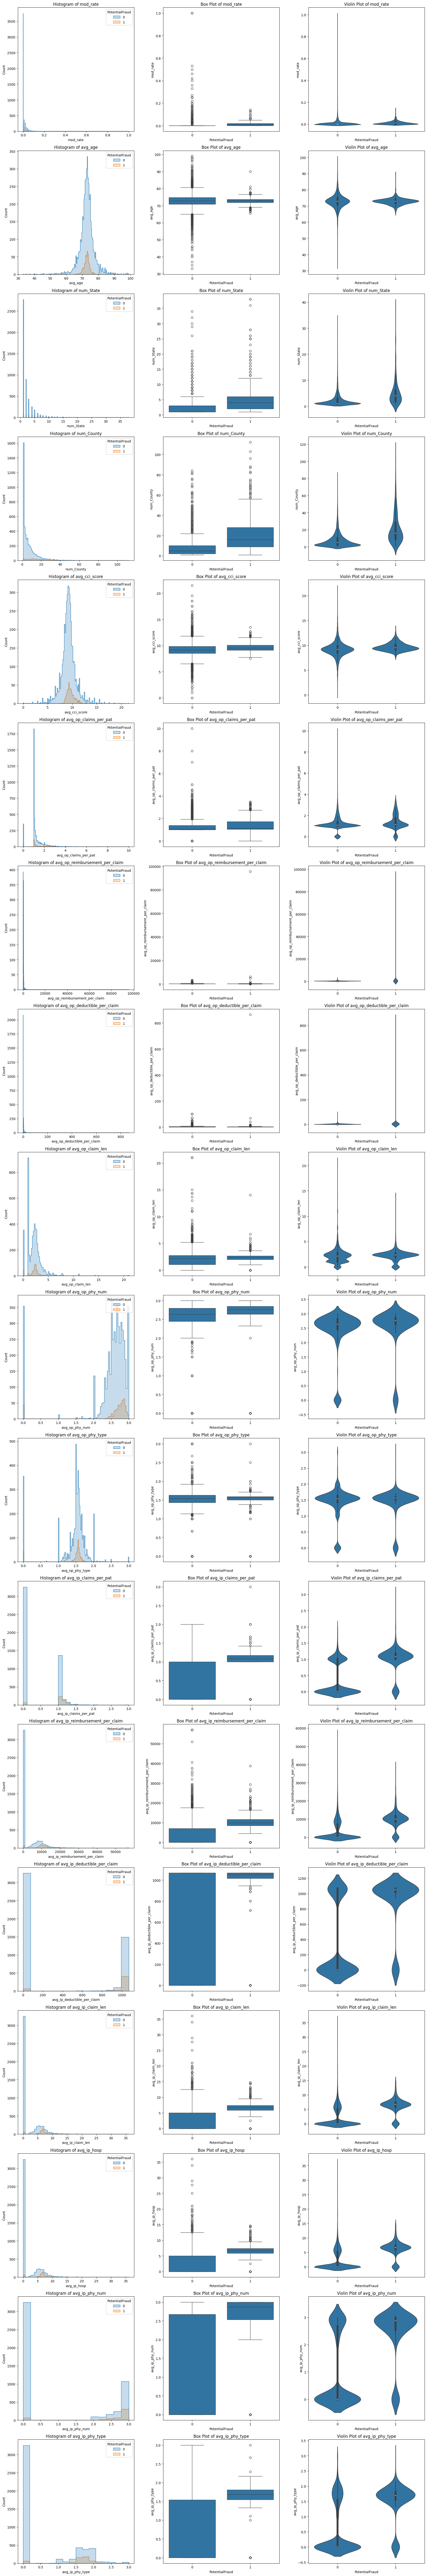

In [317]:
# Set up the matplotlib figure
fig, axes = plt.subplots(len(columns_to_normalize), 3, figsize=(18, 6*len(columns_to_normalize)))

for i, column in enumerate(columns_to_normalize):
    # Histogram
    sns.histplot(data=df_final, x=column, hue="PotentialFraud", element='step', ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {column}')

    # Box Plot
    sns.boxplot(data=df_final, x="PotentialFraud", y=column, ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot of {column}')

    # Violin Plot
    sns.violinplot(data=df_final, x="PotentialFraud", y=column, ax=axes[i, 2])
    axes[i, 2].set_title(f'Violin Plot of {column}')

# Adjust the layout
plt.tight_layout()
plt.show()

#### Comparison - bar chart

In [318]:
# # Function to get top N codes
# def get_top_codes(series, n=10):
#     all_codes = []
#     for sublist in series:
#         all_codes.extend(sublist)
#     print(all_codes)
#     code_counts = pd.Series(all_codes).value_counts().head(n)
#     return code_counts
# get_top_codes(df_final['Top_5_ClmAdmitDiagnosisCode_op'], n=10)


In [319]:
def plot_code_distributions(df, column, top_n=5, label_col='PotentialFraud'):
    unique_labels = df[label_col].unique()
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    for i, label in enumerate(unique_labels):
        subset = df[df[label_col] == label]
        top_codes = subset[column].value_counts().head(top_n)
        if not top_codes.empty:
            sns.barplot(x=top_codes.index, y=top_codes.values, ax=axs[i], palette='viridis')
            axs[i].set_title(f'{column} - Label {label}')
            axs[i].set_ylabel('Frequency')
            axs[i].set_xlabel('Codes')
            axs[i].tick_params(axis='x', rotation=45)
        else:
            print(f"No data to plot for column {column} and label {label}")

    plt.tight_layout()
    plt.show()

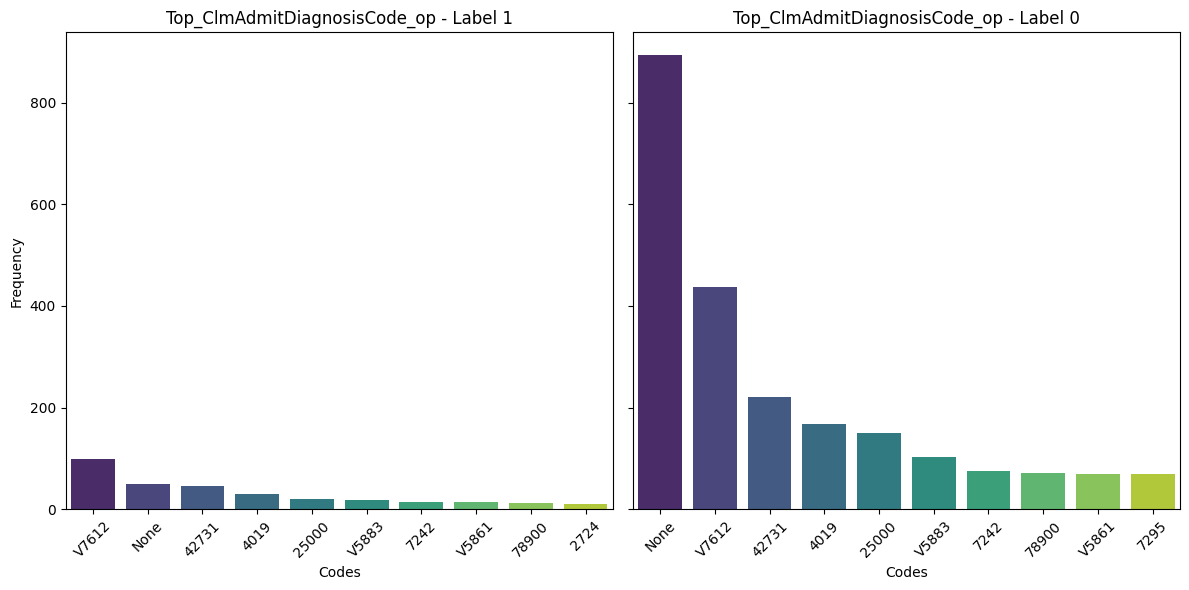

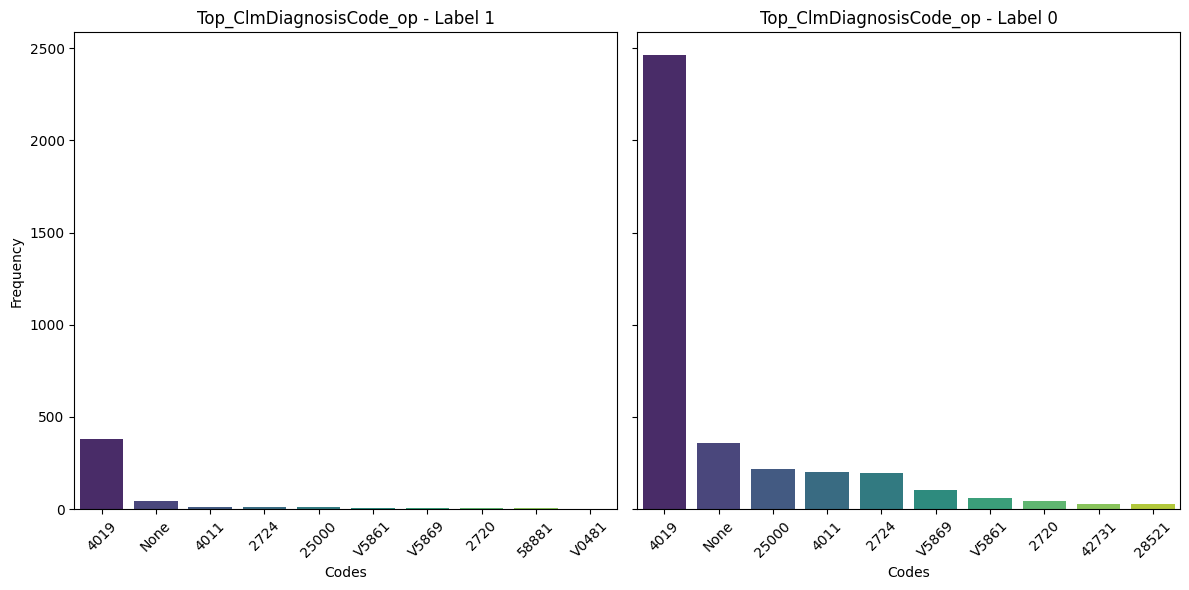

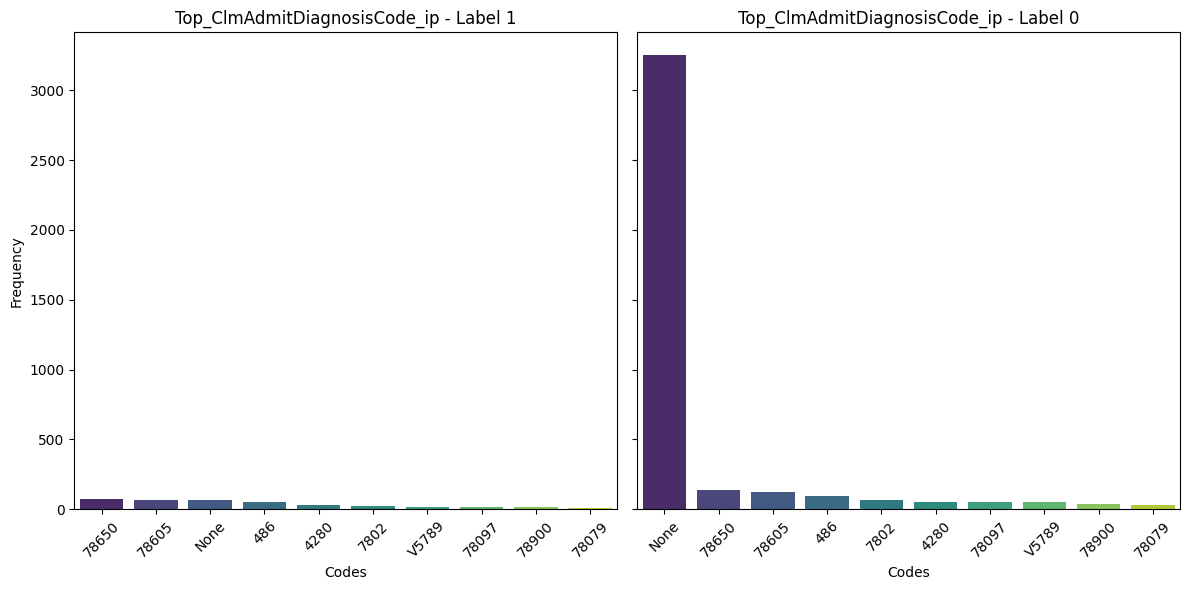

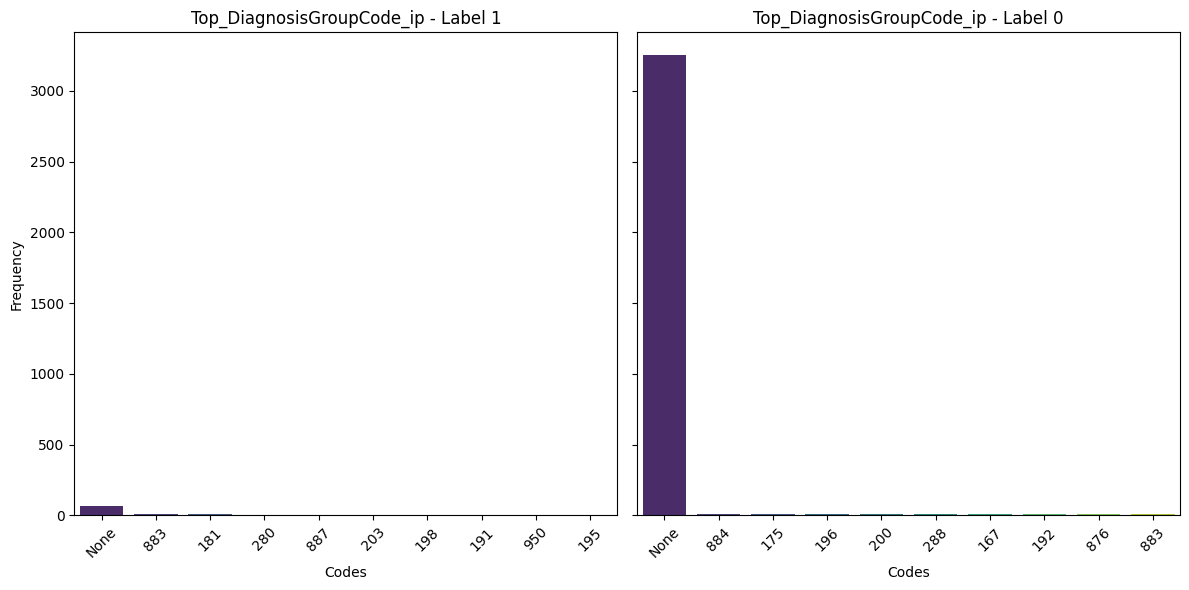

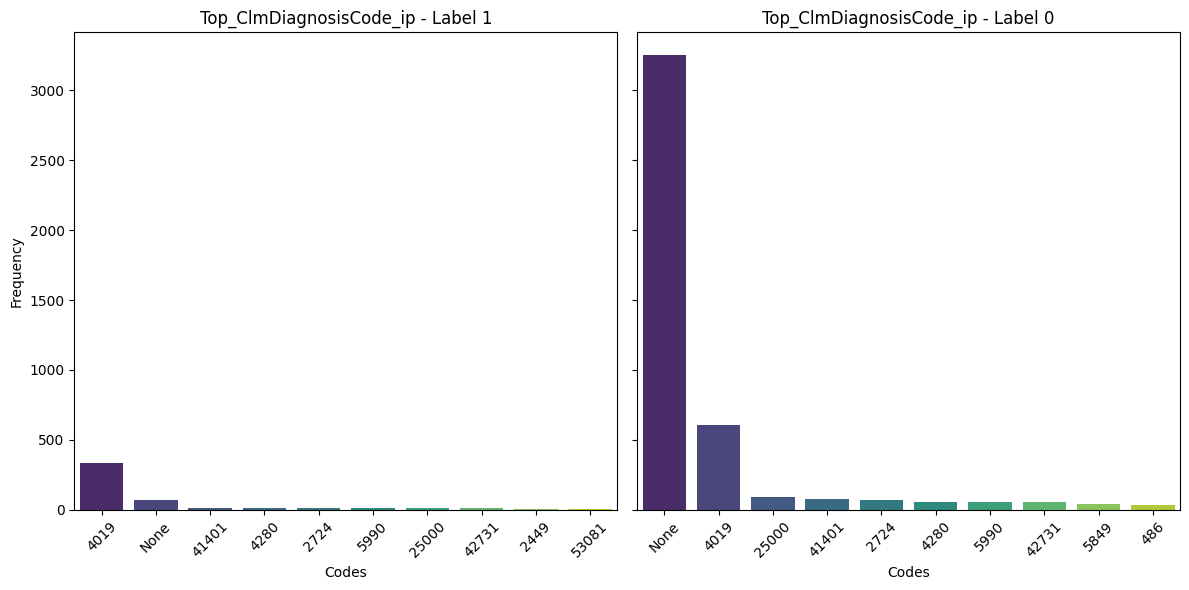

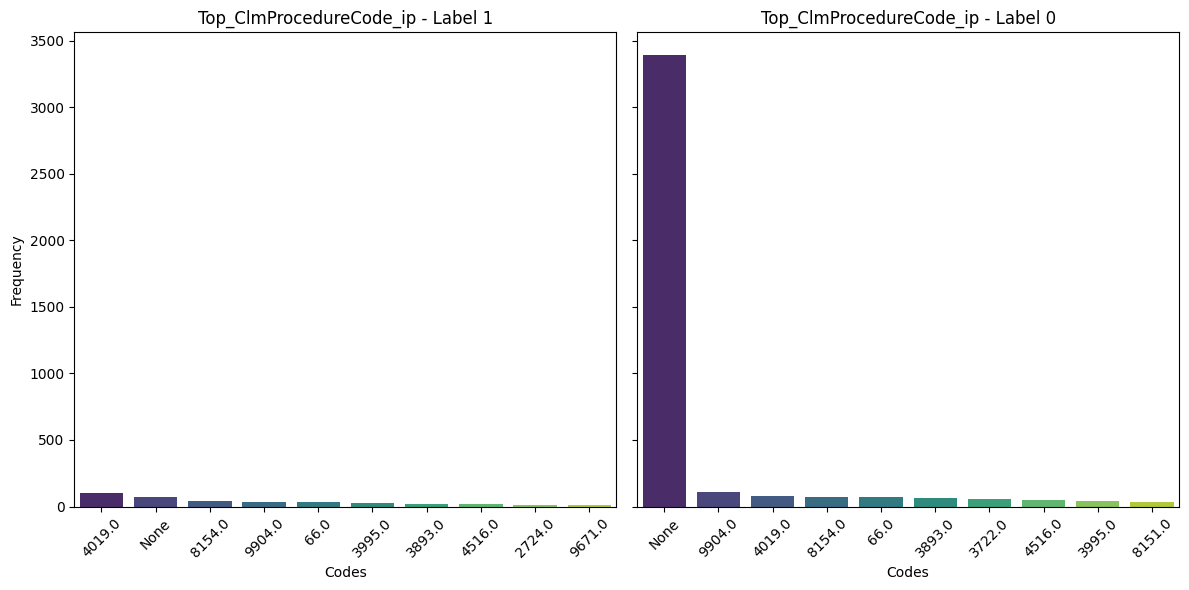

In [320]:
for col in cat_col:
    plot_code_distributions(df_final, col, top_n=10)

## Data Preprocessing

#### Check outliers

In [321]:
## check extreme values
df_final[df_final['avg_op_reimbursement_per_claim']>80000]

Provider  mod_rate    avg_age  num_State  num_County  avg_cci_score  \
999  PRV51119      0.01  74.271605          1          10      10.626316   

     avg_op_claims_per_pat  avg_op_reimbursement_per_claim  \
999                    1.0                         95580.0   

     avg_op_deductible_per_claim  avg_op_claim_len  ...  \
999                        865.0              14.0  ...   

     avg_ip_deductible_per_claim  avg_ip_claim_len avg_ip_hosp avg_ip_phy_num  \
999                      1022.55              6.97        6.98           2.71   

     avg_ip_phy_type  Top_ClmAdmitDiagnosisCode_ip  Top_DiagnosisGroupCode_ip  \
999             1.74                         78097                        862   

     Top_ClmDiagnosisCode_ip  Top_ClmProcedureCode_ip  PotentialFraud  
999                     4019                   4019.0               1  

[1 rows x 26 columns]

In [322]:
for col in columns_to_normalize:
# Calculate the first and third quartiles
    Q1 = np.percentile(df_final[col], 25)
    Q3 = np.percentile(df_final[col], 75)

    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1

    # Define the thresholds for identifying outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count the number of outliers
    outliers = (df_final[col] < lower_bound) | (df_final[col] > upper_bound)
    num_outliers = np.sum(outliers)

    print(f"Number of outliers in {col}: {num_outliers}")

Number of outliers in mod_rate: 578
Number of outliers in avg_age: 424
Number of outliers in num_State: 390
Number of outliers in num_County: 401
Number of outliers in avg_cci_score: 444
Number of outliers in avg_op_claims_per_pat: 1012
Number of outliers in avg_op_reimbursement_per_claim: 230
Number of outliers in avg_op_deductible_per_claim: 259
Number of outliers in avg_op_claim_len: 152
Number of outliers in avg_op_phy_num: 431
Number of outliers in avg_op_phy_type: 922
Number of outliers in avg_ip_claims_per_pat: 1
Number of outliers in avg_ip_reimbursement_per_claim: 79
Number of outliers in avg_ip_deductible_per_claim: 0
Number of outliers in avg_ip_claim_len: 48
Number of outliers in avg_ip_hosp: 48
Number of outliers in avg_ip_phy_num: 0
Number of outliers in avg_ip_phy_type: 0


##### method1: apply robust scaling and then apply min-max scaling

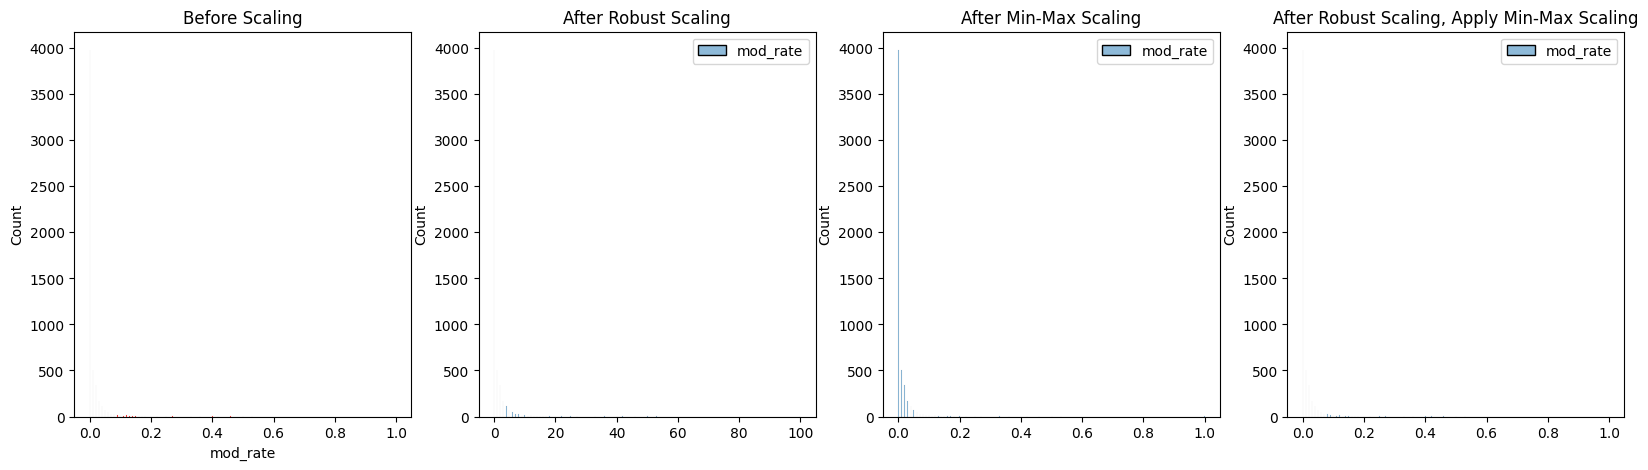

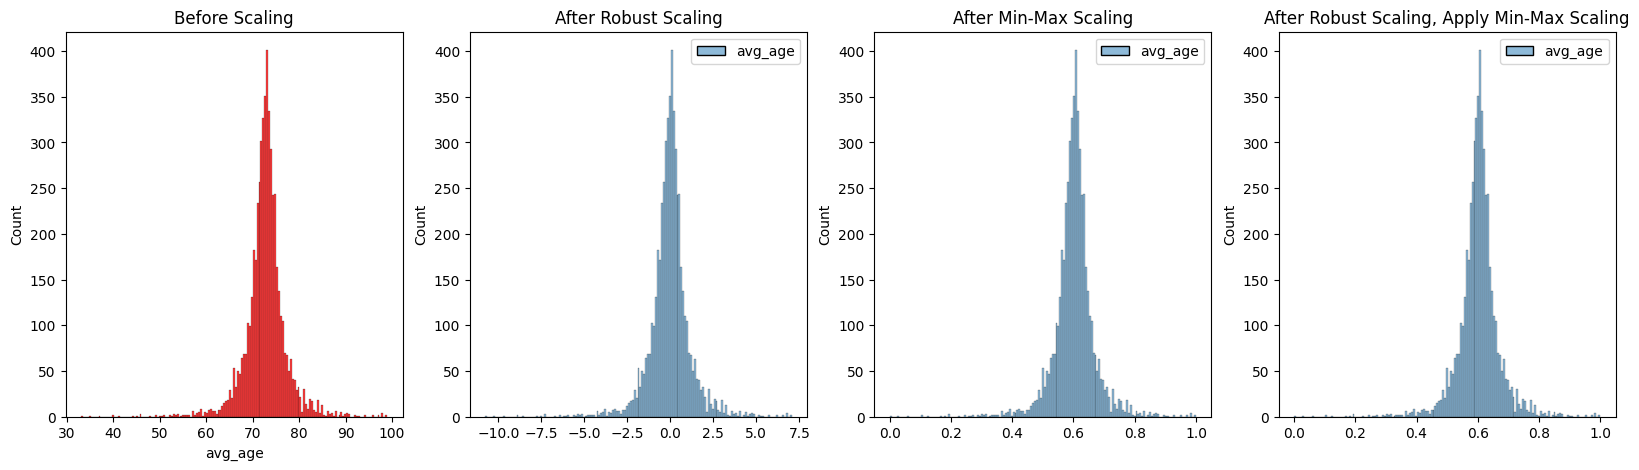

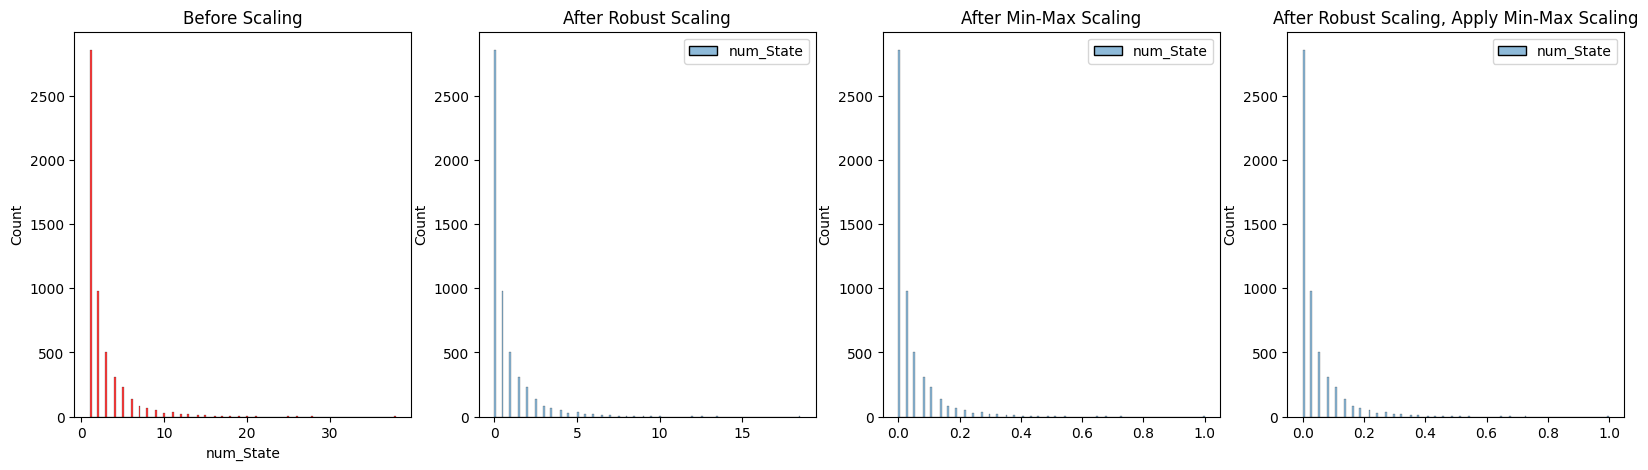

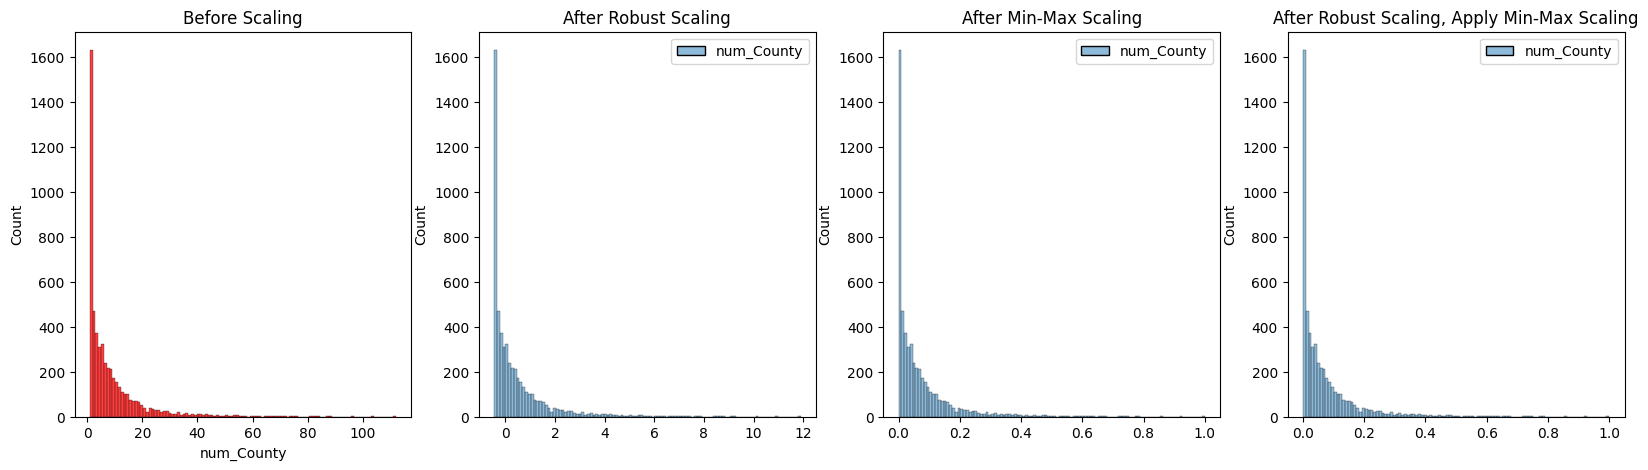

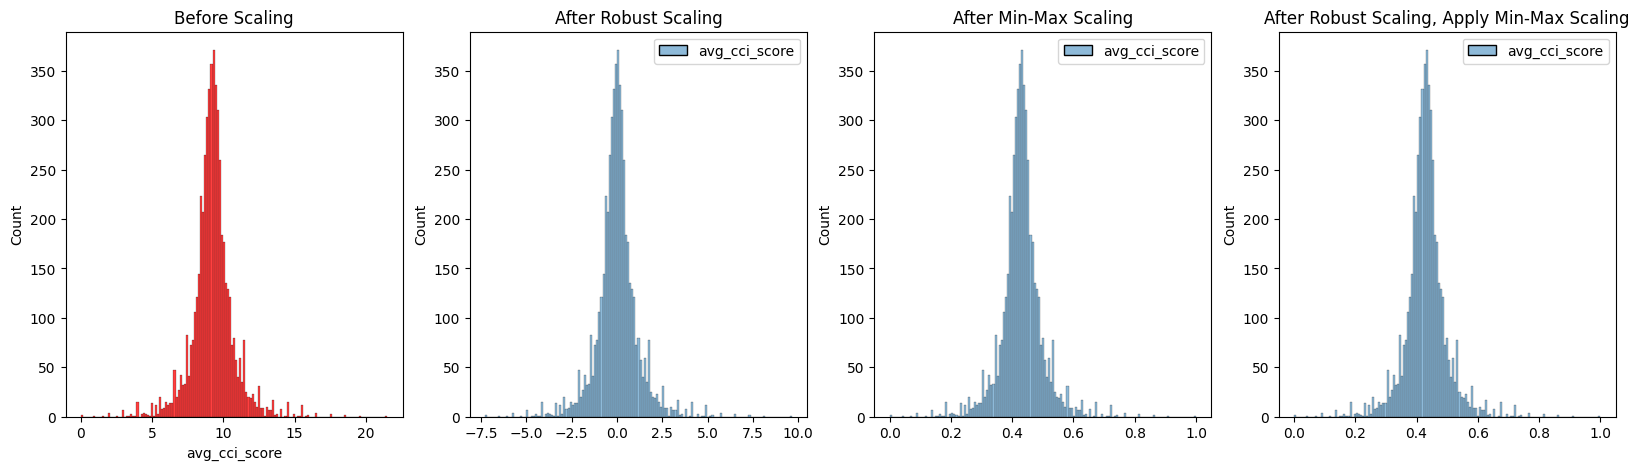

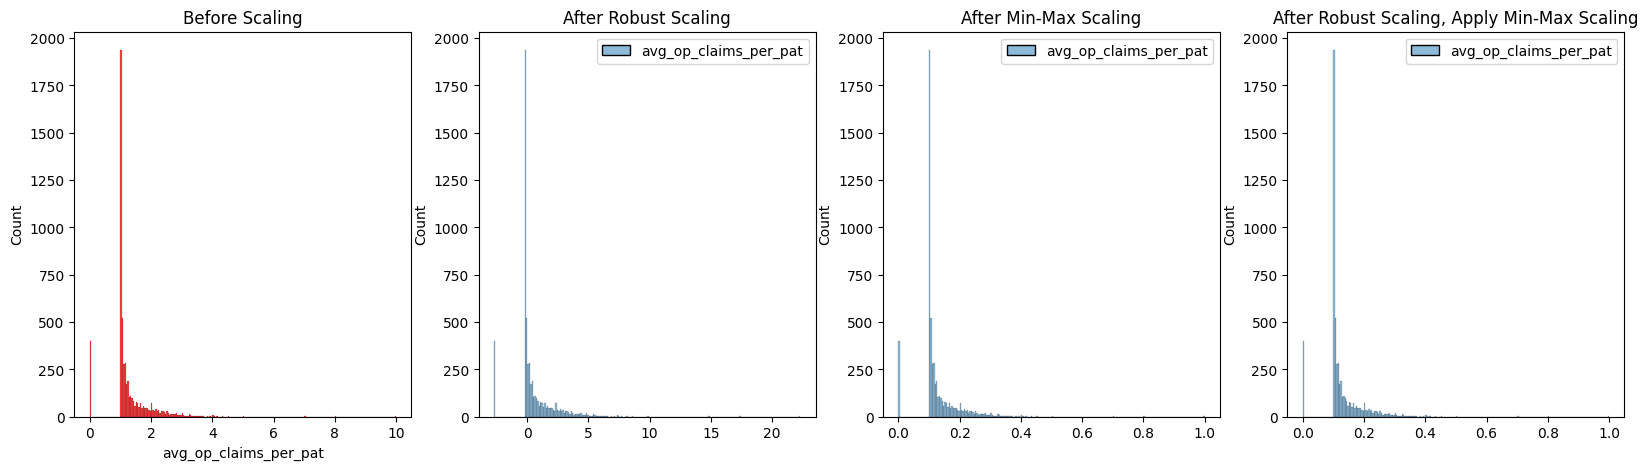

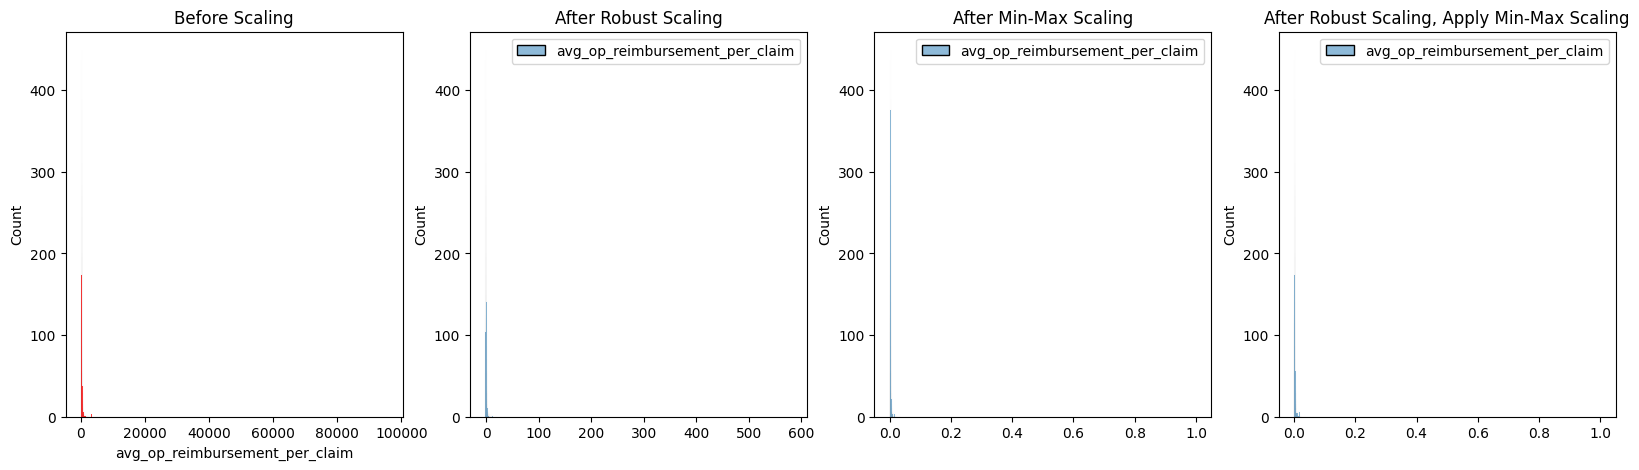

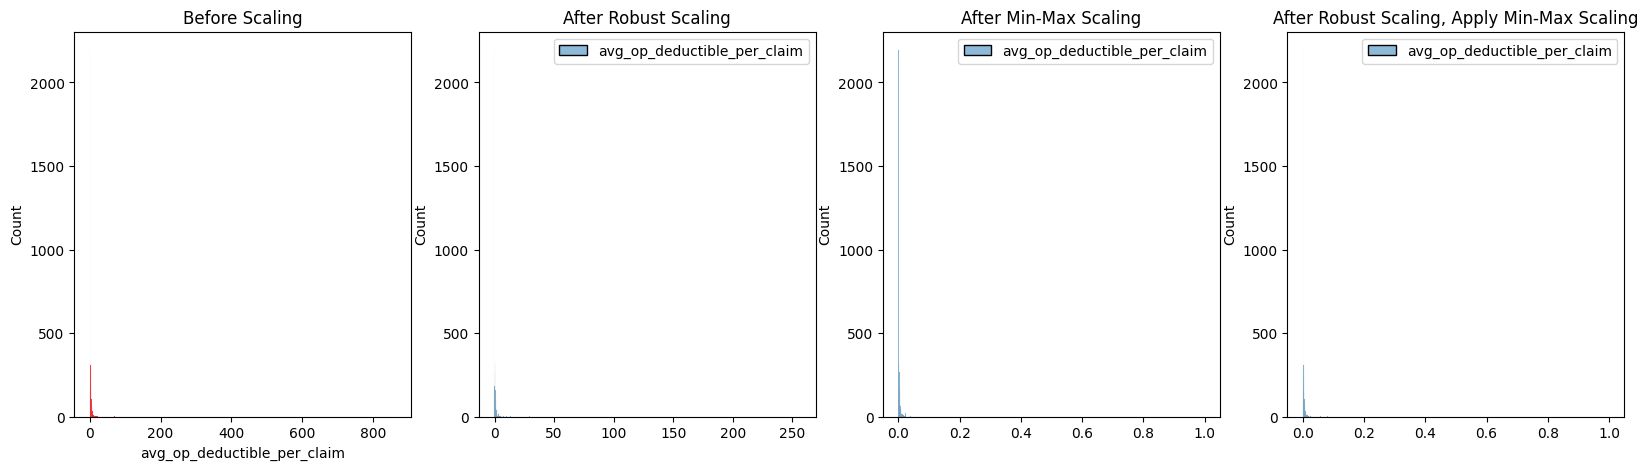

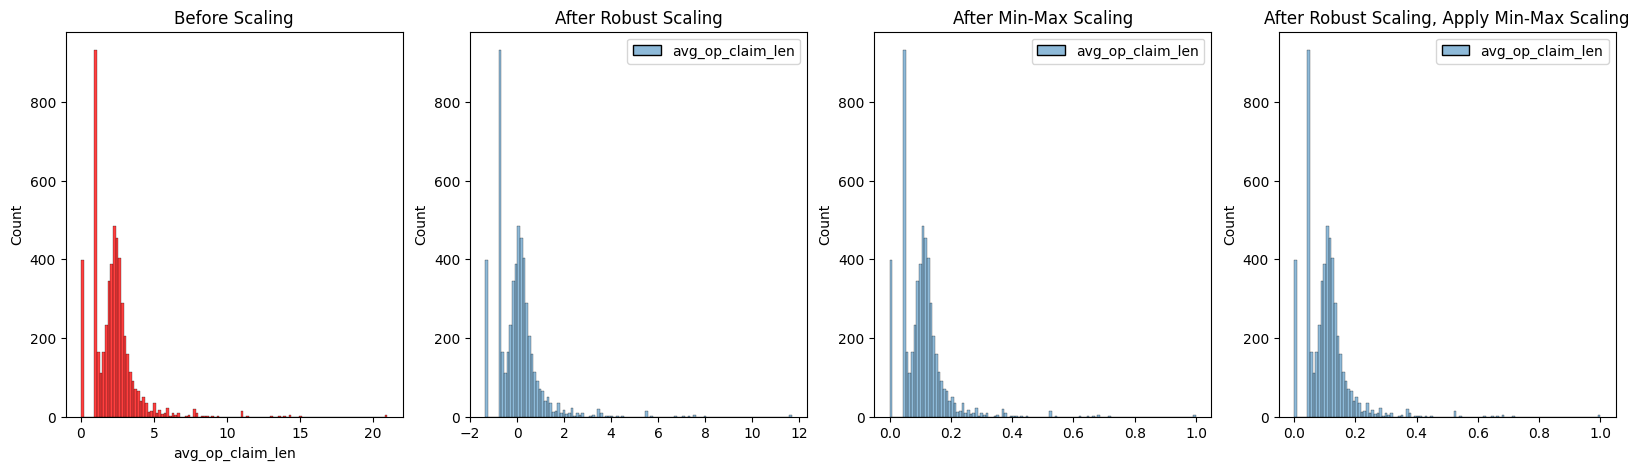

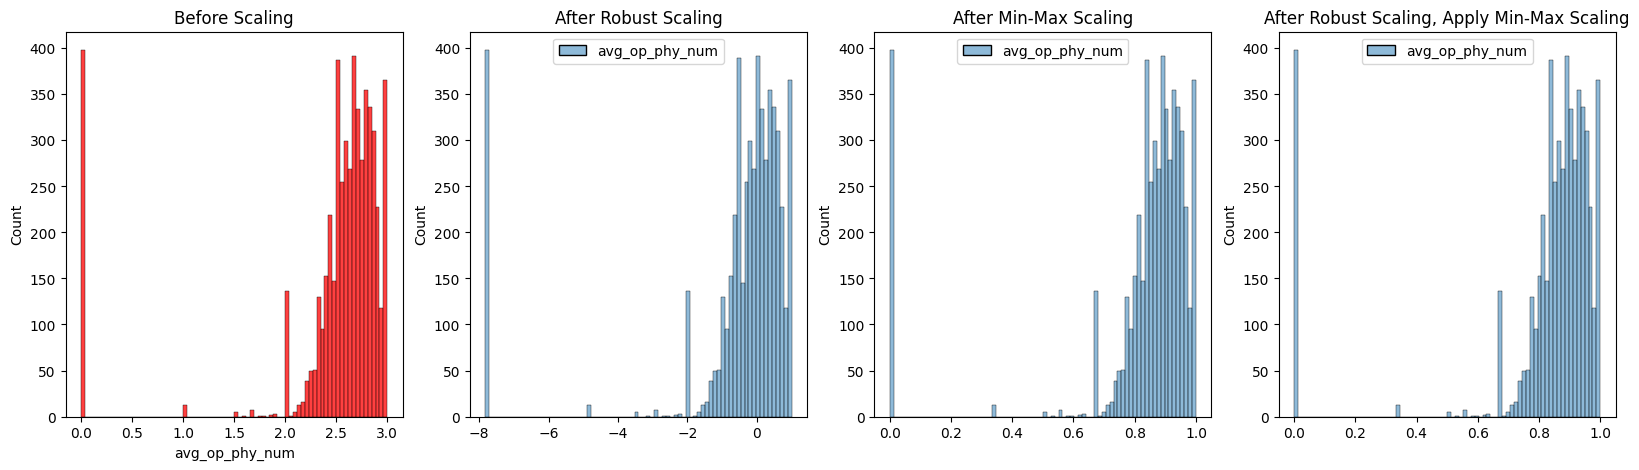

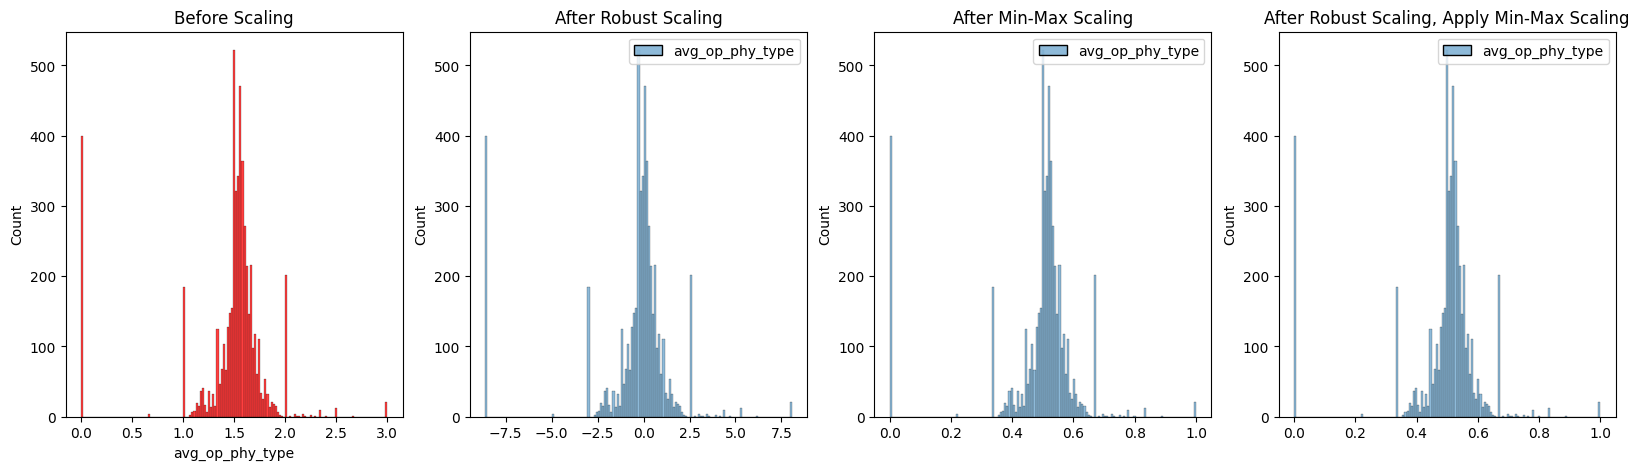

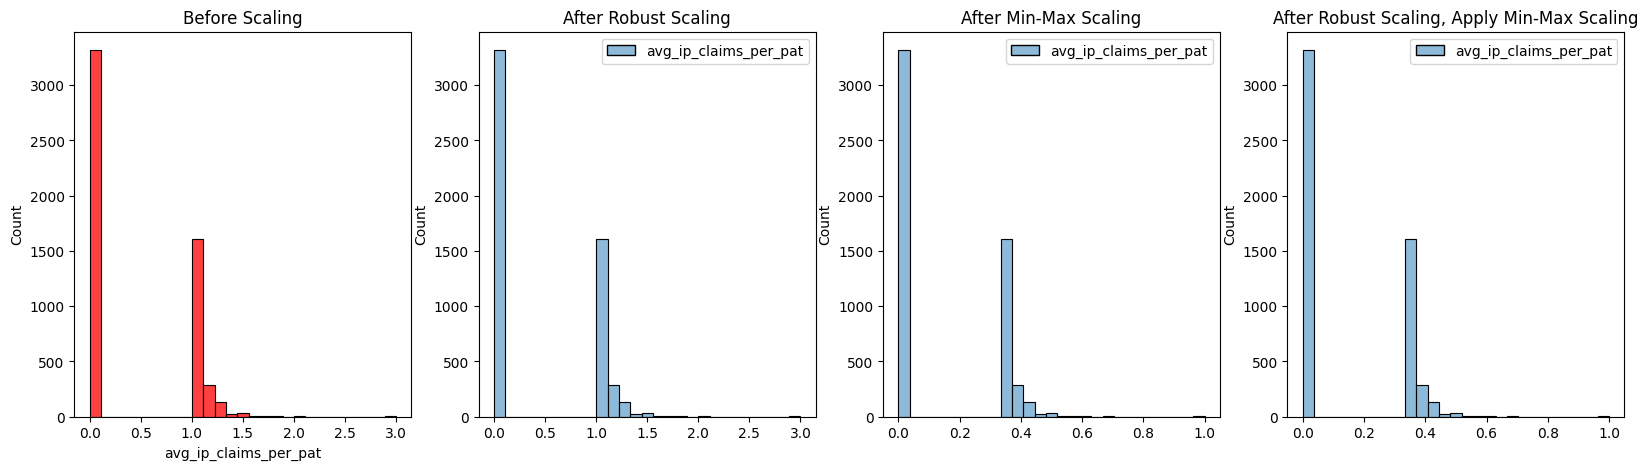

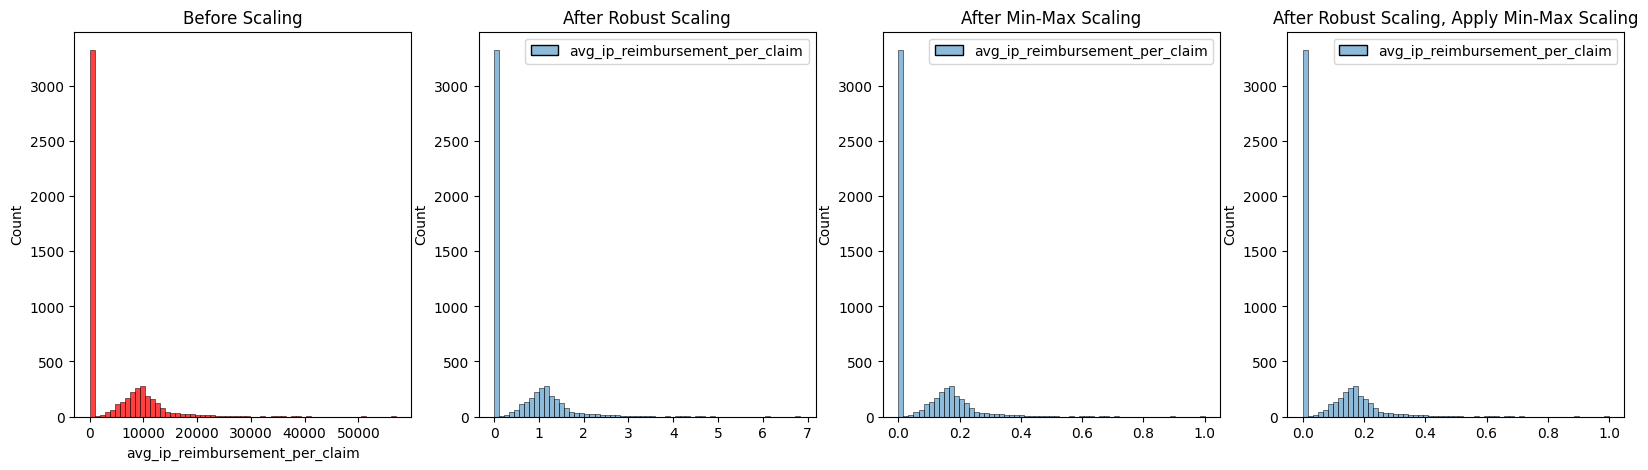

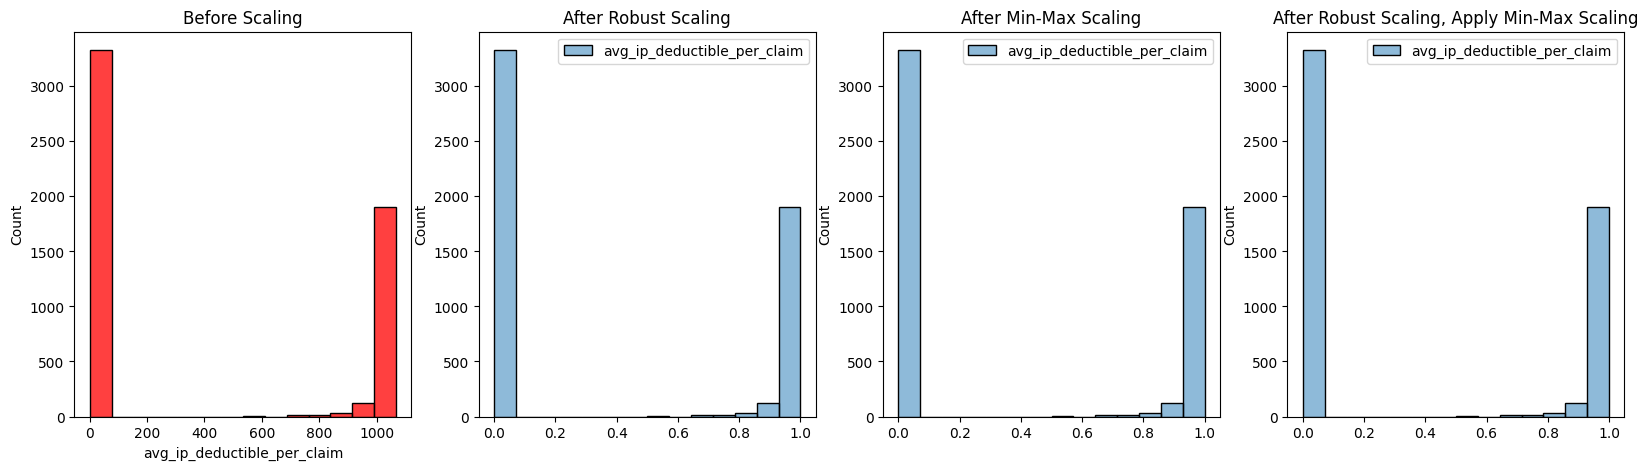

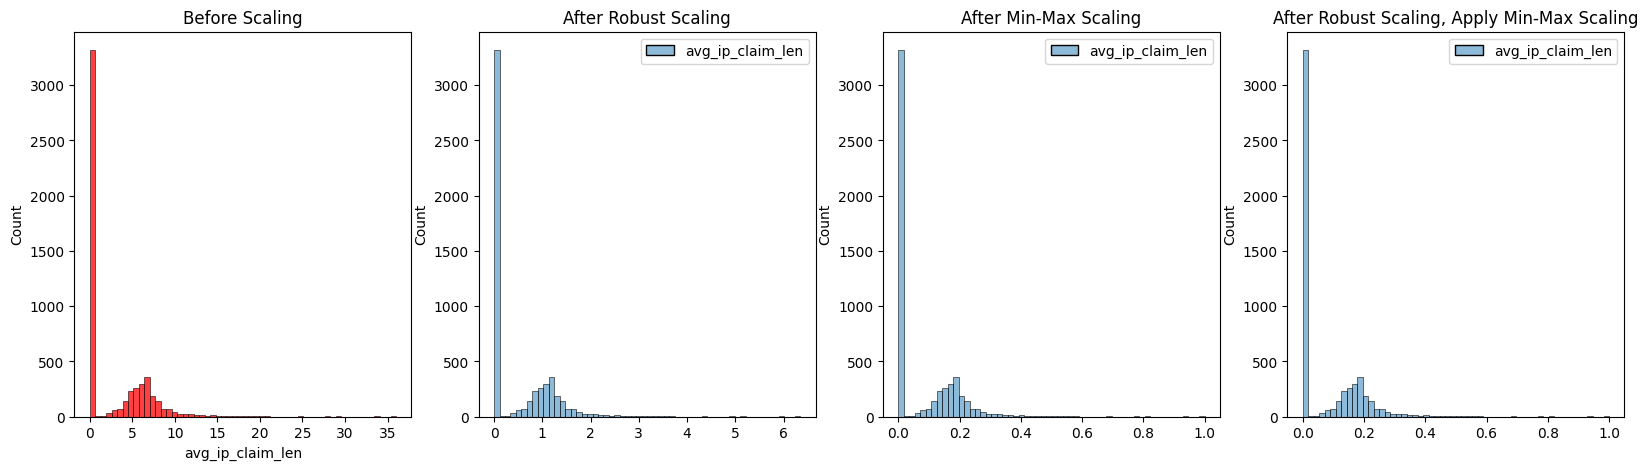

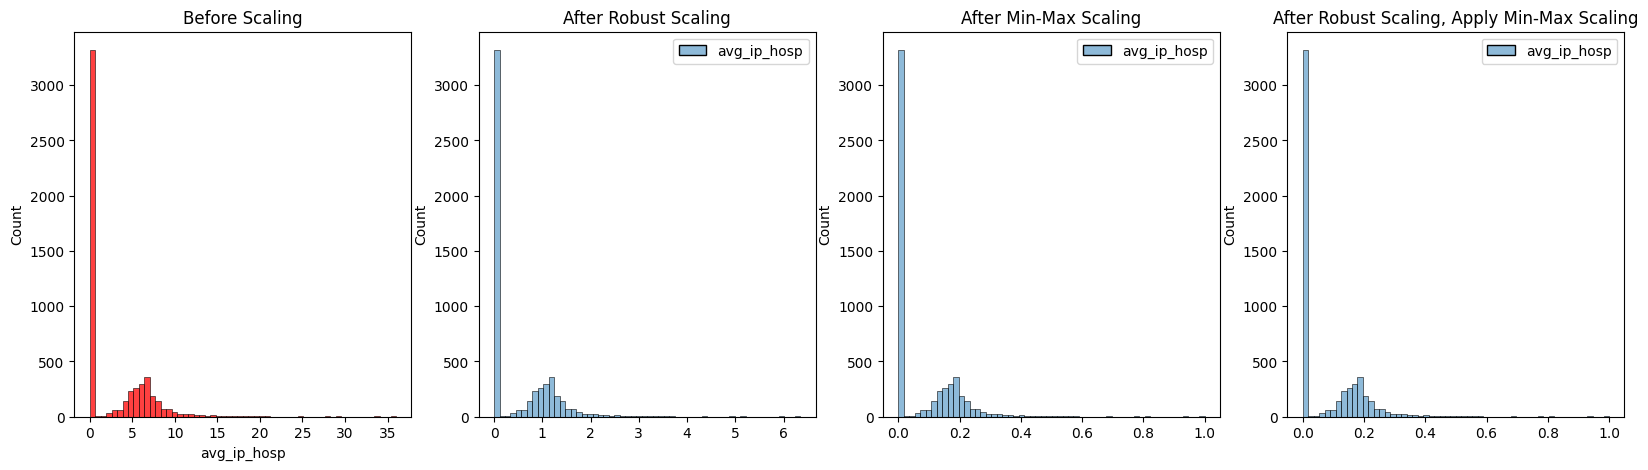

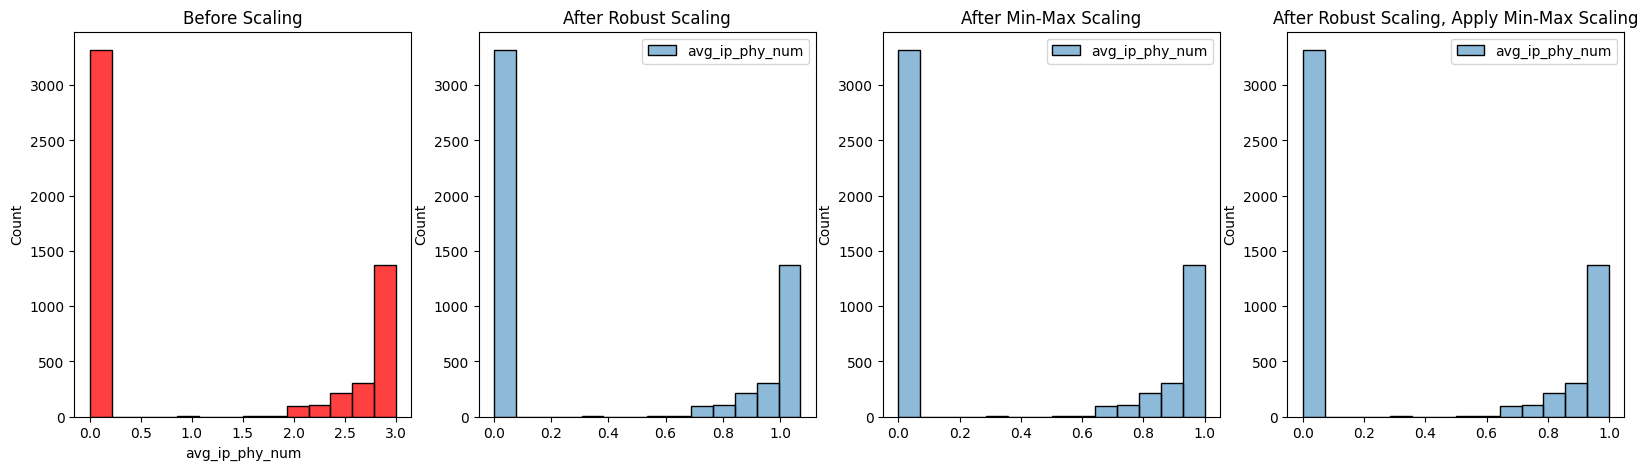

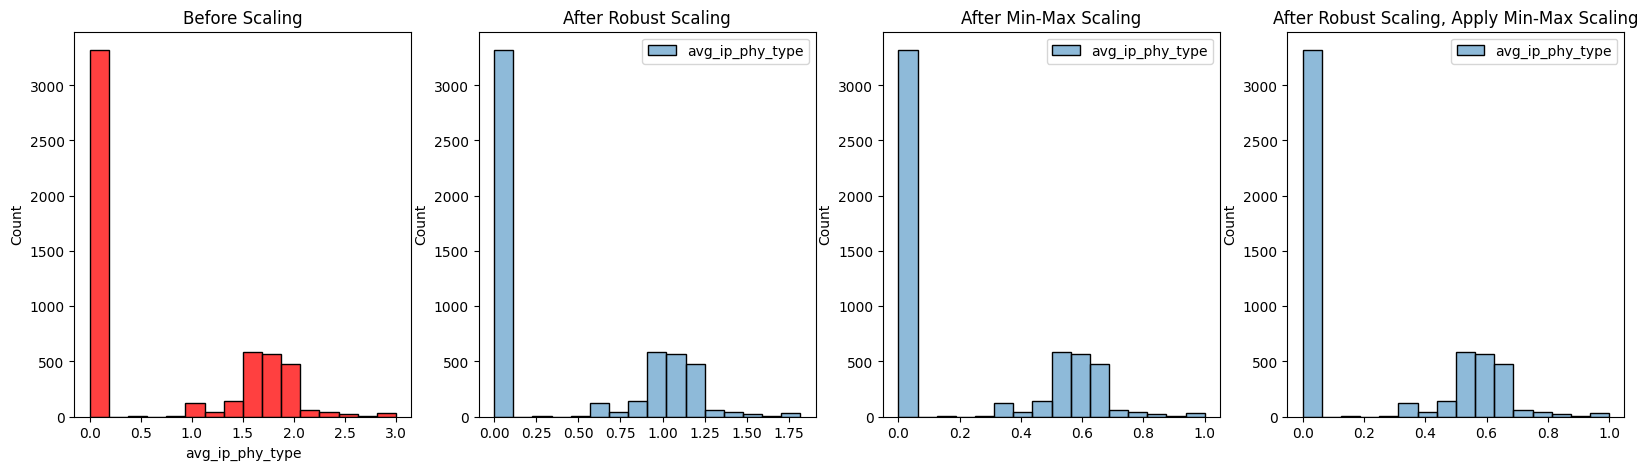

In [323]:
x = df_final[columns_to_normalize]
scaler = RobustScaler()
robust_df = scaler.fit_transform(x)
robust_df = pd.DataFrame(robust_df, columns =[columns_to_normalize])

scaler = StandardScaler()
standard_df = scaler.fit_transform(x)
standard_df = pd.DataFrame(standard_df, columns =[columns_to_normalize])

scaler = MinMaxScaler()
minmax_df = scaler.fit_transform(x)
minmax_df = pd.DataFrame(minmax_df, columns =[columns_to_normalize])

minmax_rubust_df = scaler.fit_transform(robust_df)
minmax_rubust_df = pd.DataFrame(minmax_rubust_df, columns =[columns_to_normalize])

for col in columns_to_normalize:
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))

    ax1.set_title('Before Scaling') 
    sns.histplot(x[col], ax = ax1, color ='r')

    ax2.set_title('After Robust Scaling')
    sns.histplot(robust_df[col], ax = ax2)

    ax3.set_title('After Min-Max Scaling') 
    sns.histplot(minmax_df[col], ax = ax3)

    ax4.set_title('After Robust Scaling, Apply Min-Max Scaling') 
    sns.histplot(minmax_rubust_df[col], ax = ax4)

    plt.show()

##### method2: apply winsorization

In my dataset, the outliers are mostly in the right side. So I set left percentile as 0, right side as 5%.


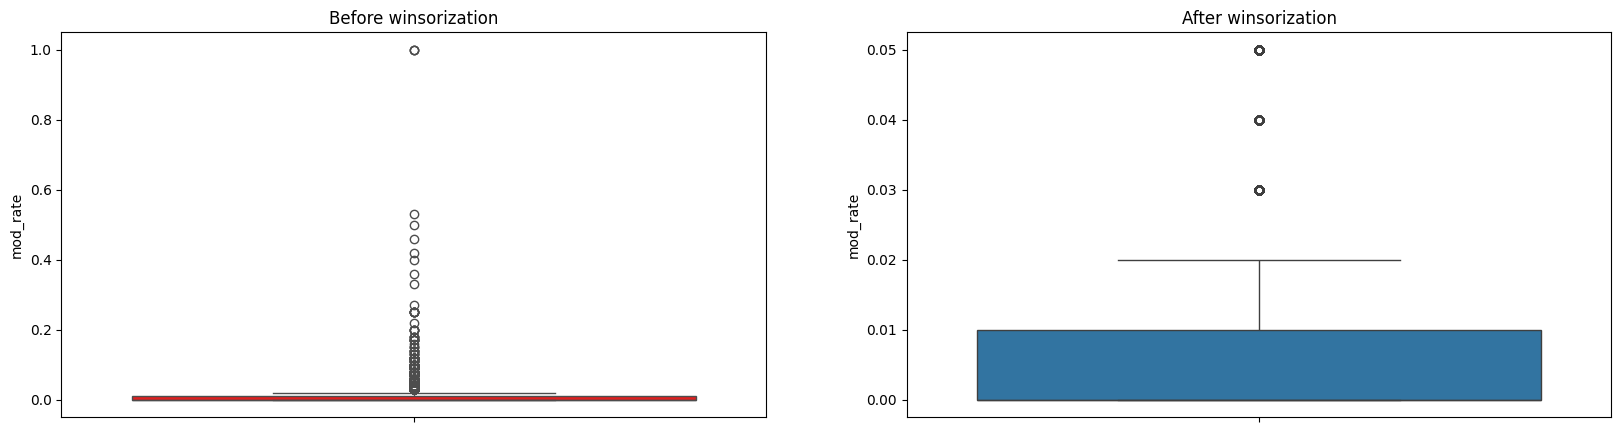

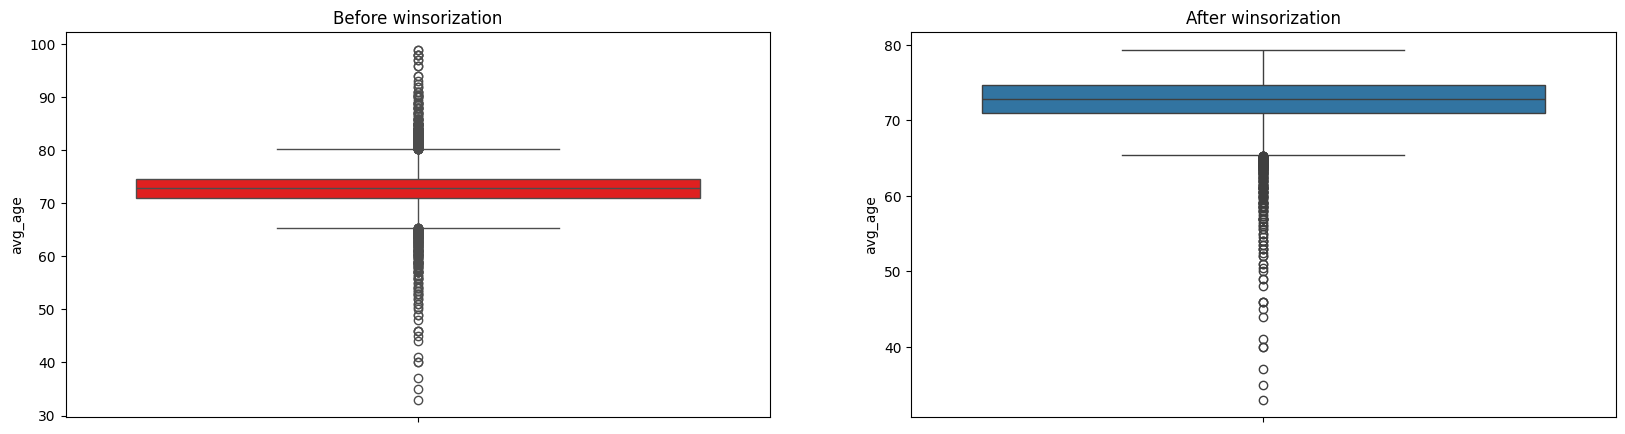

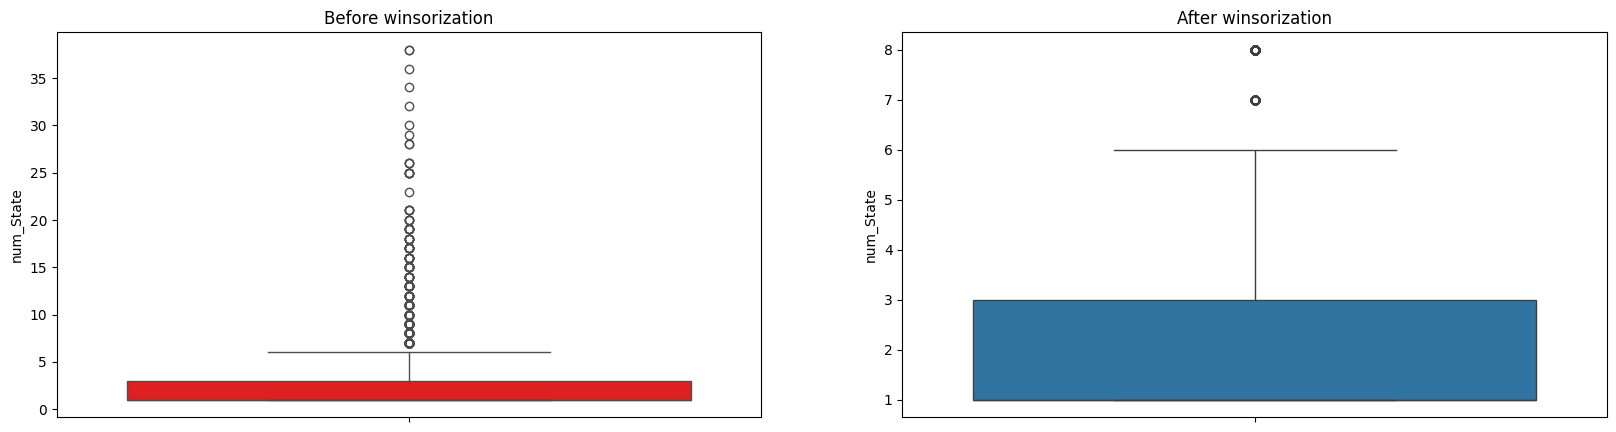

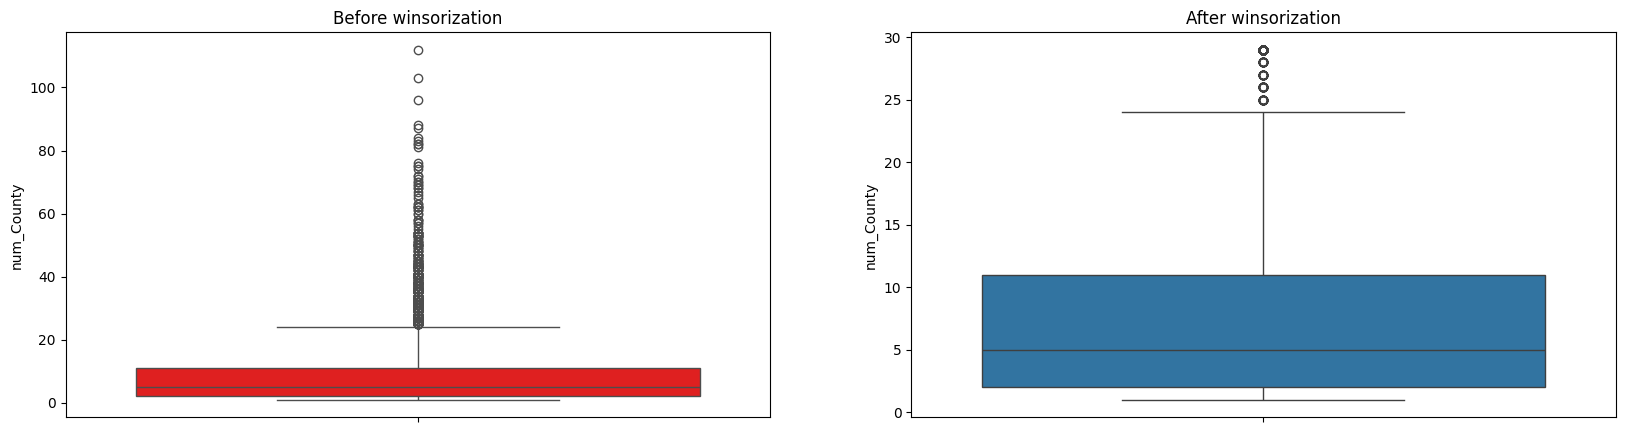

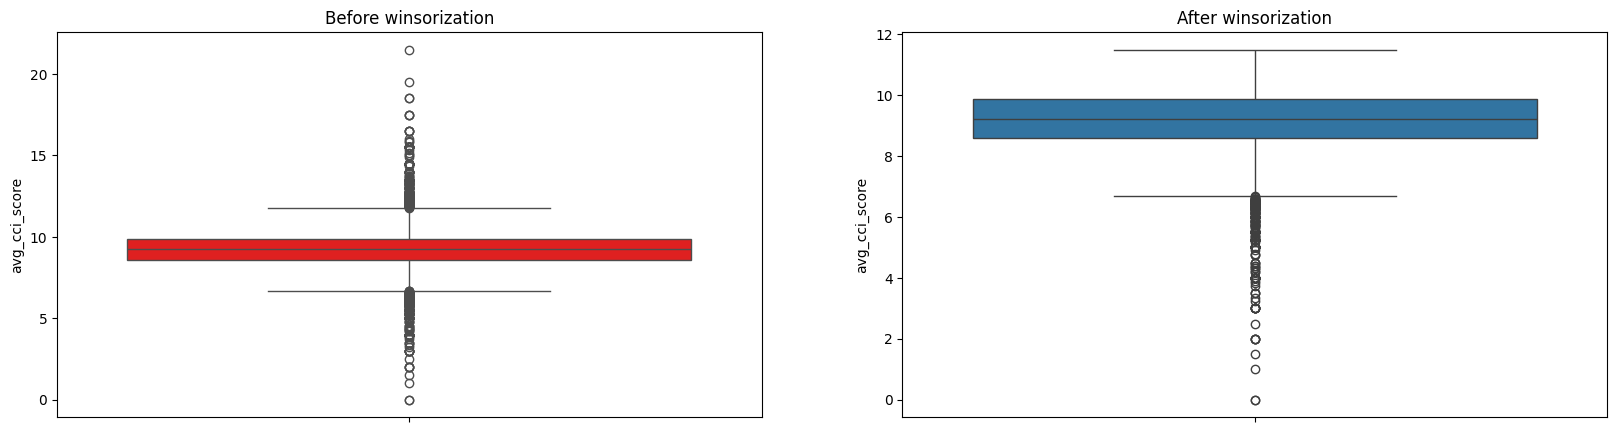

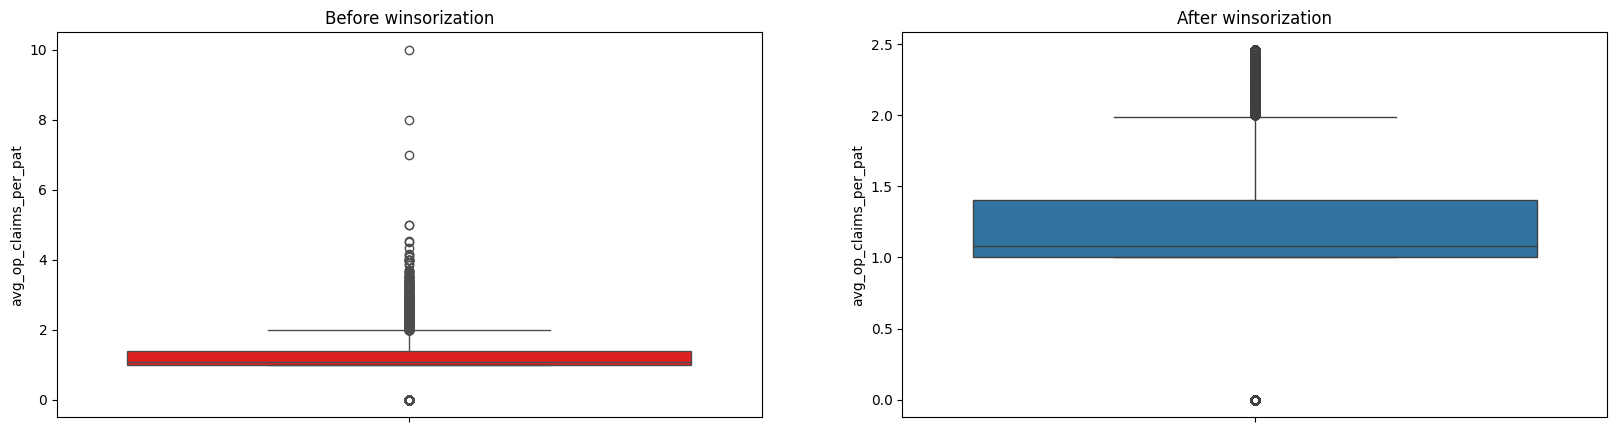

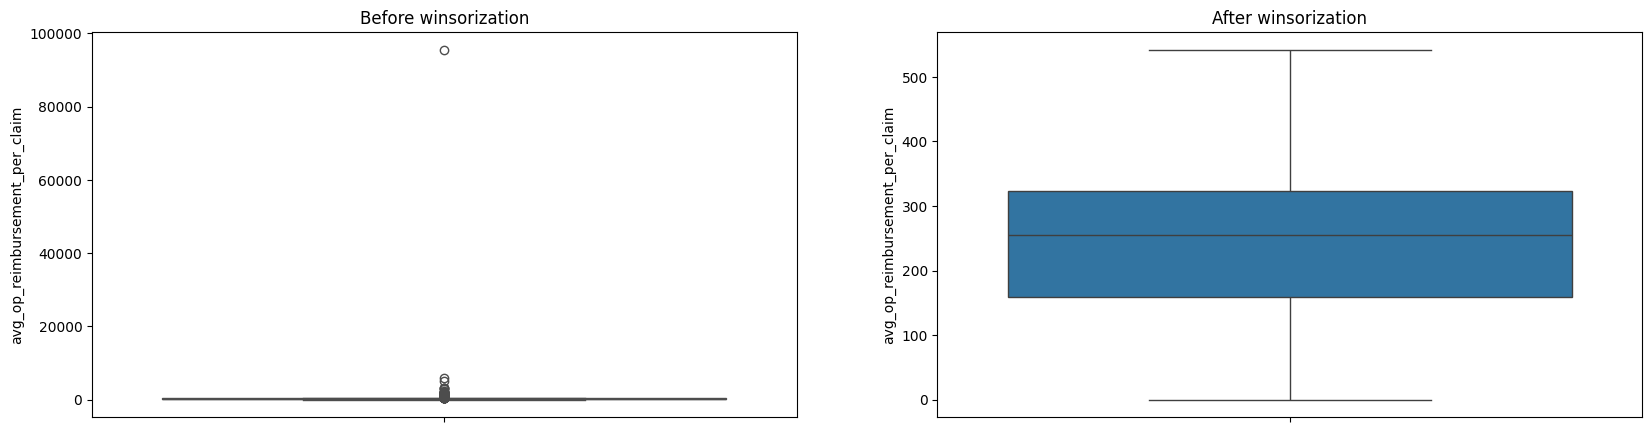

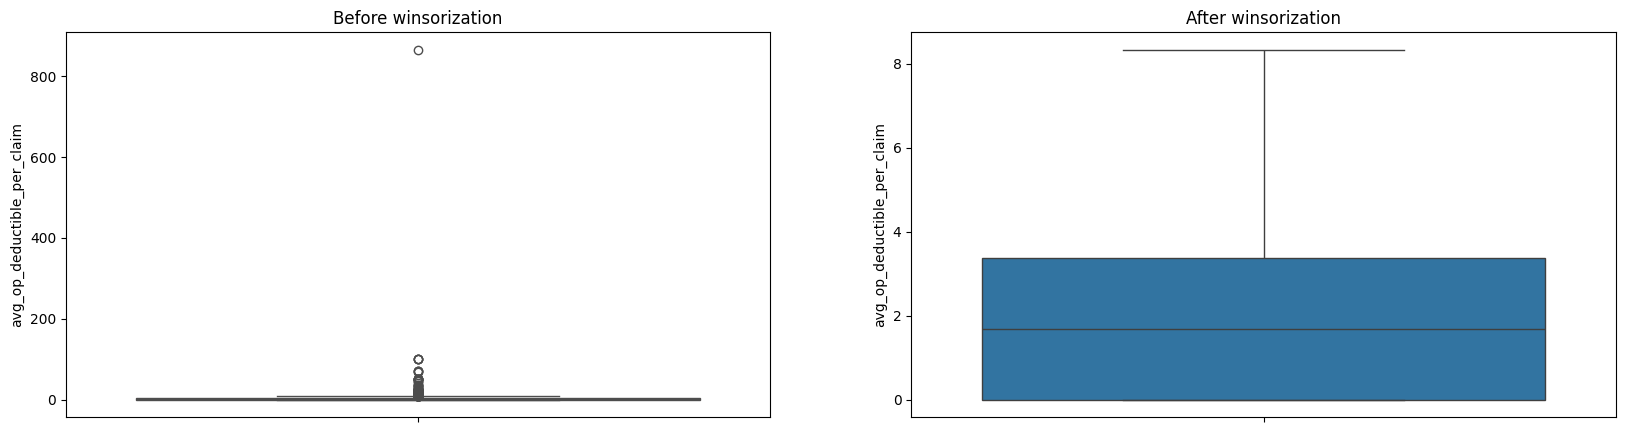

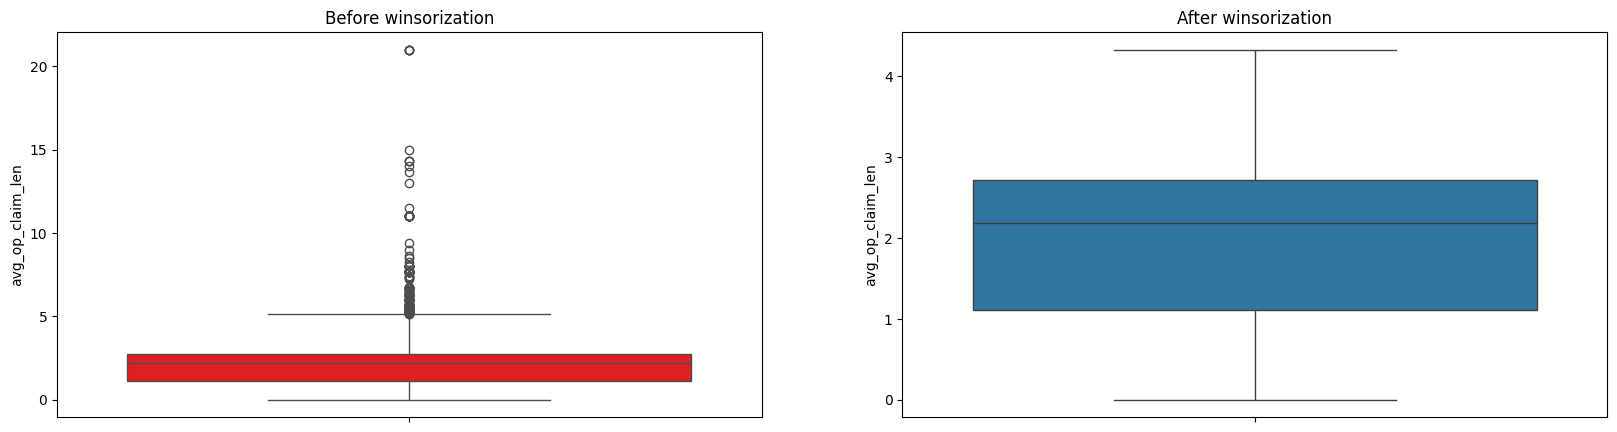

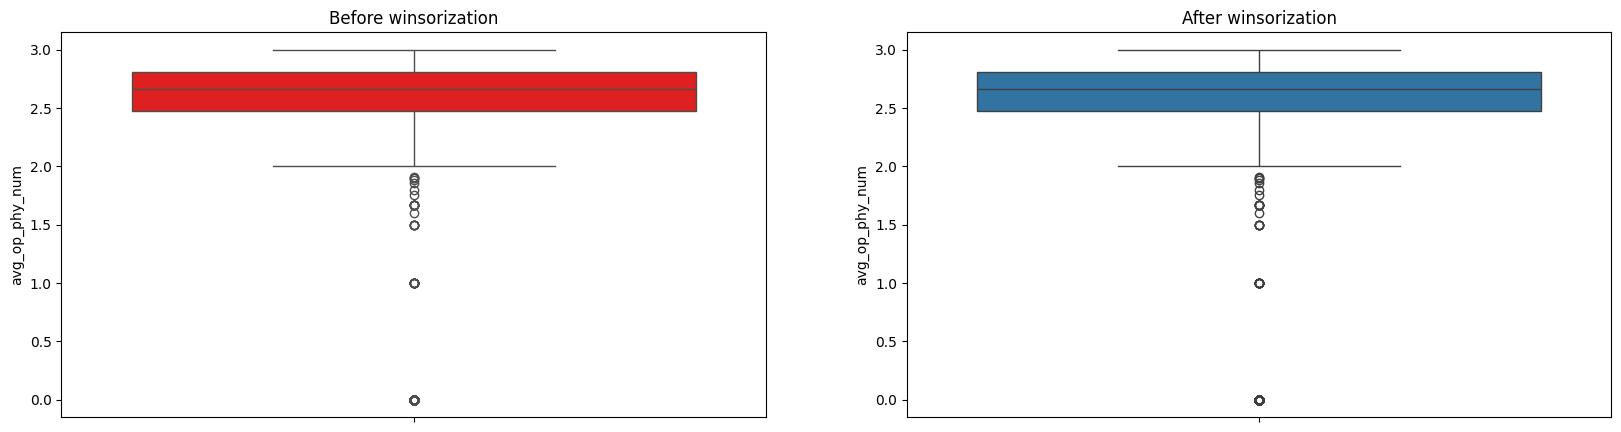

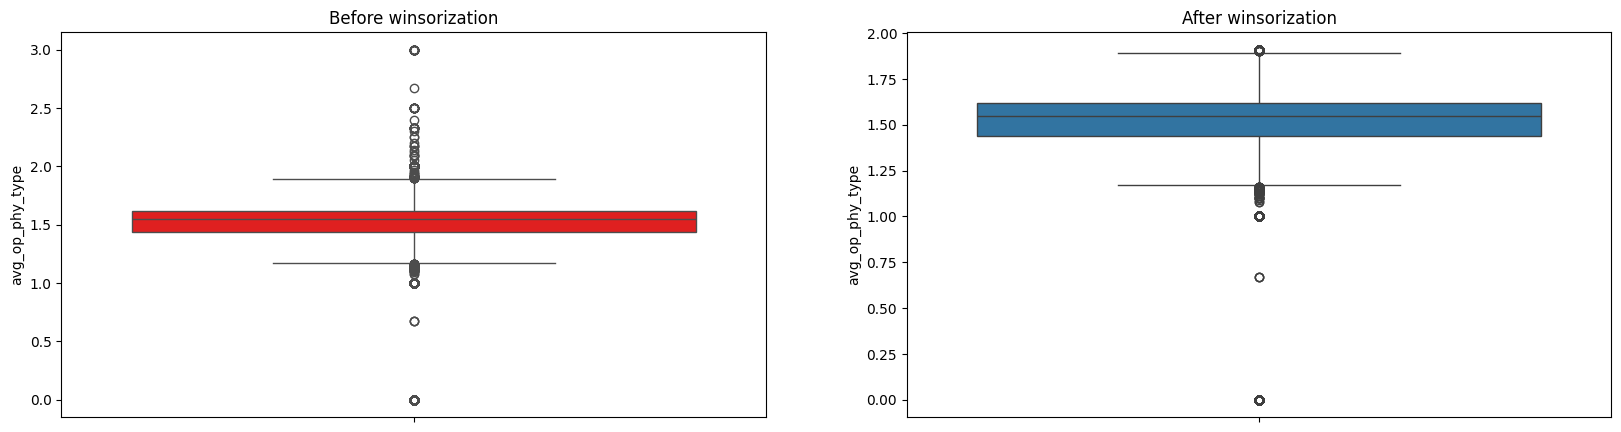

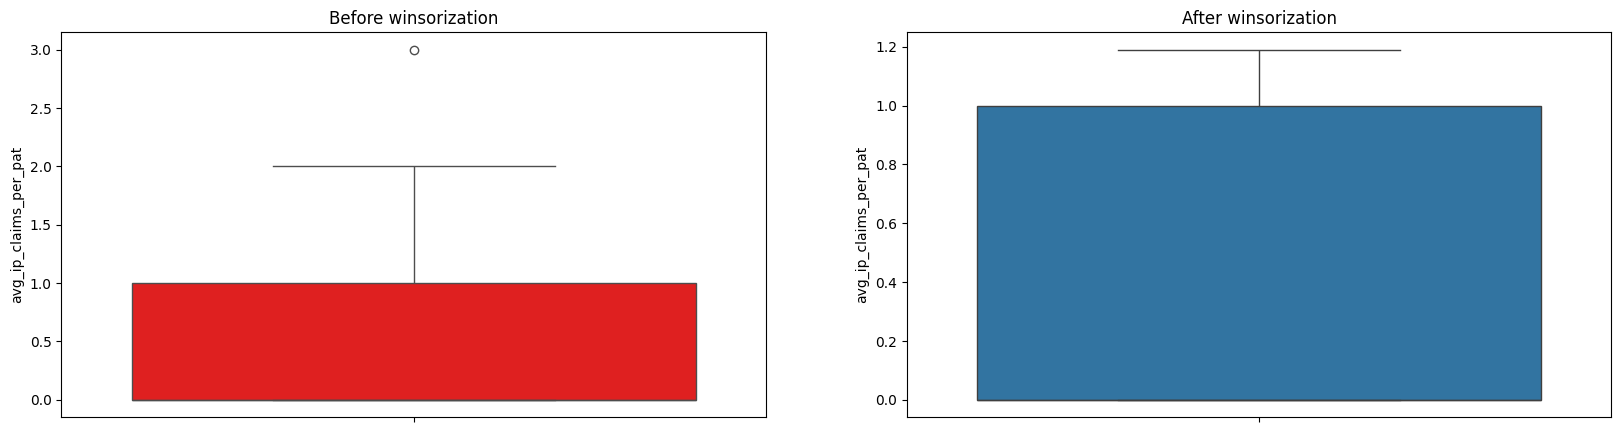

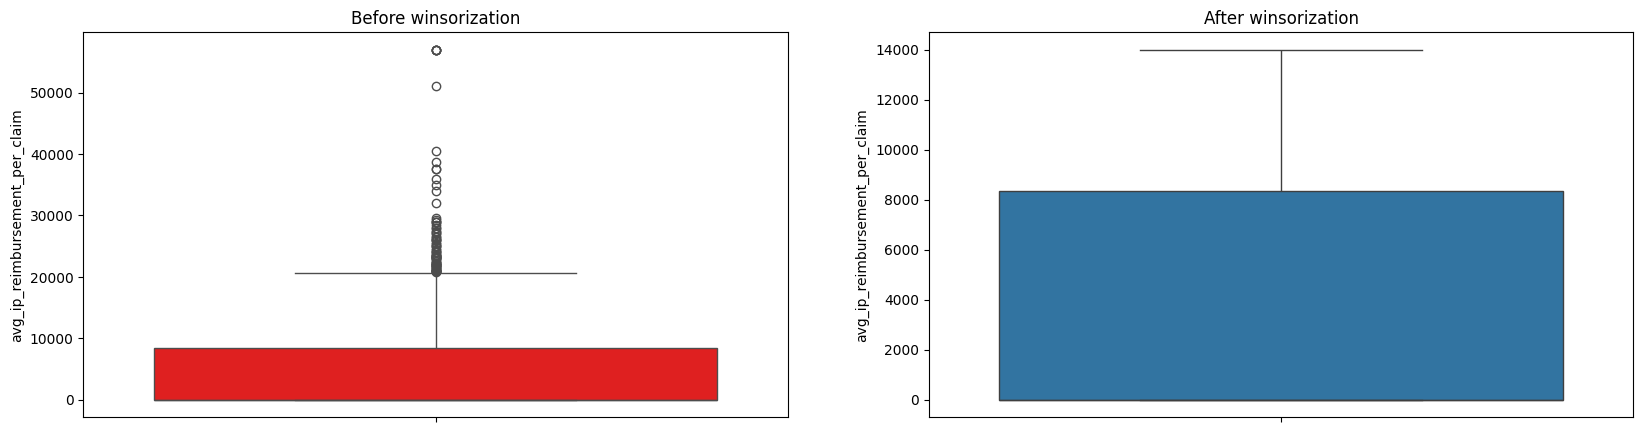

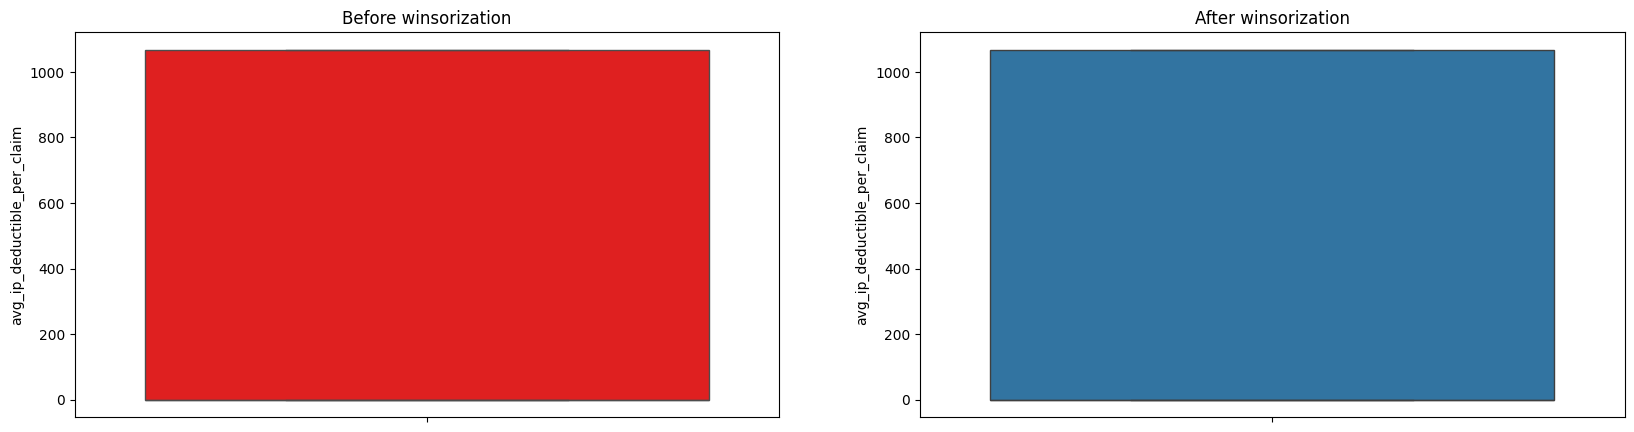

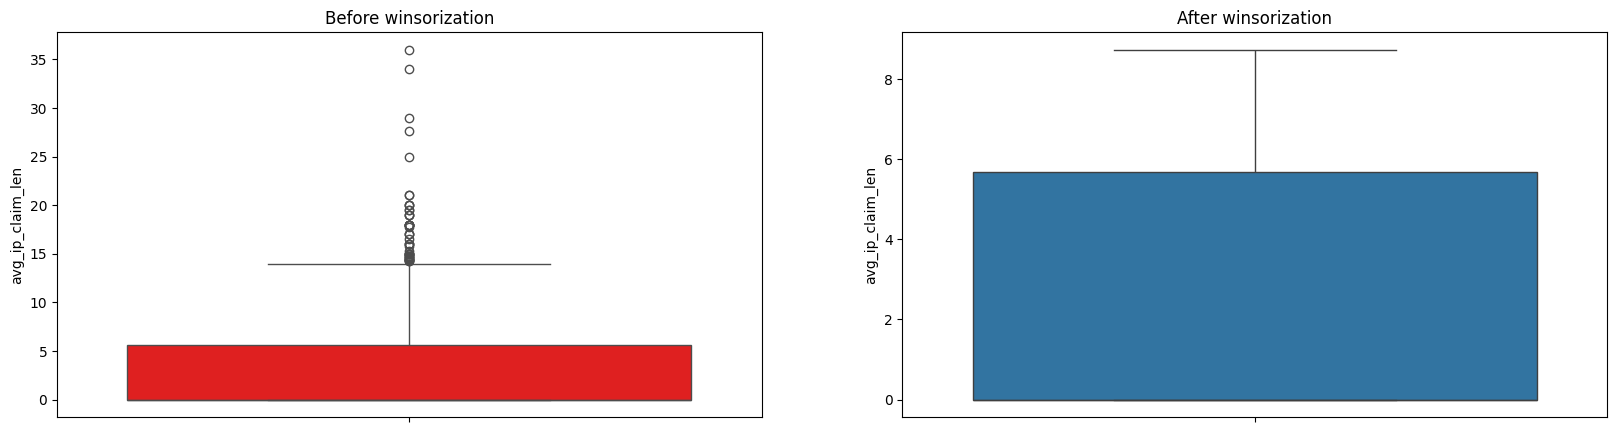

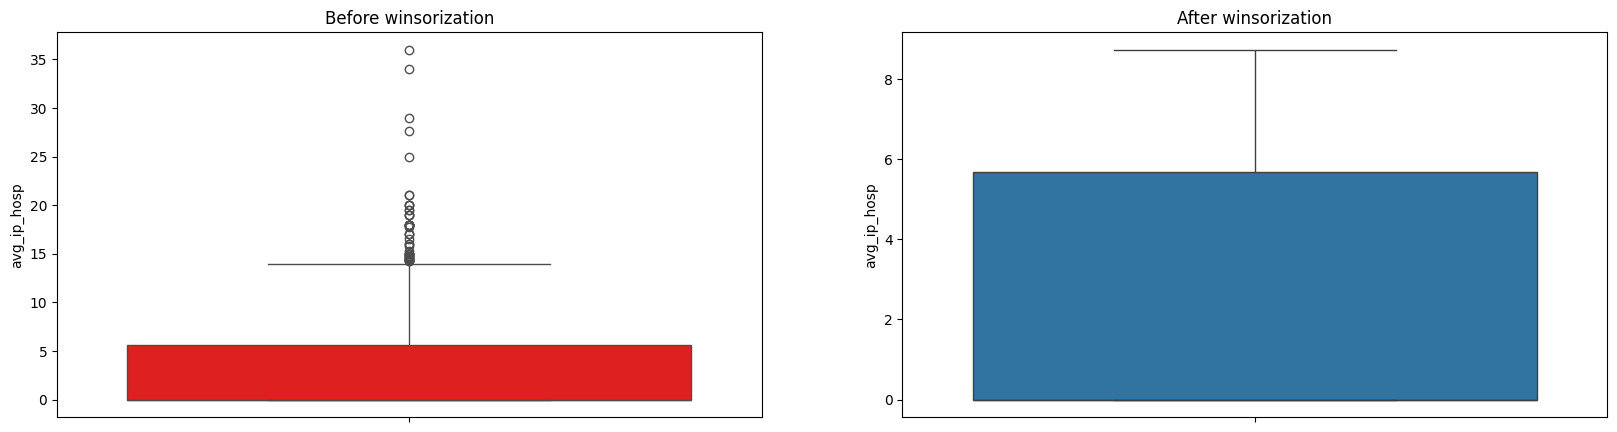

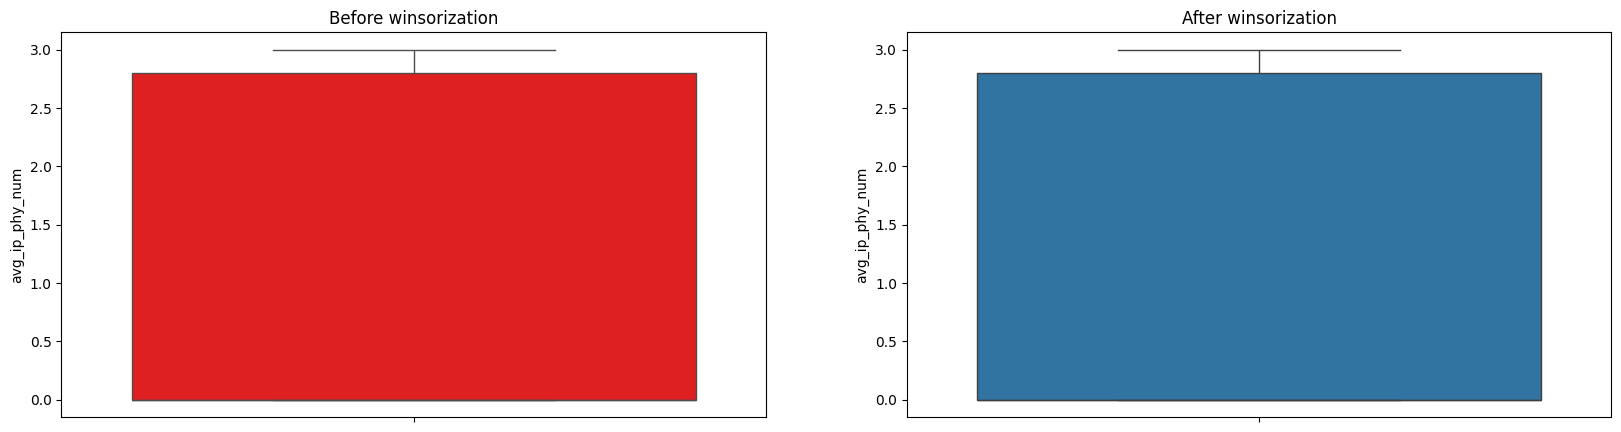

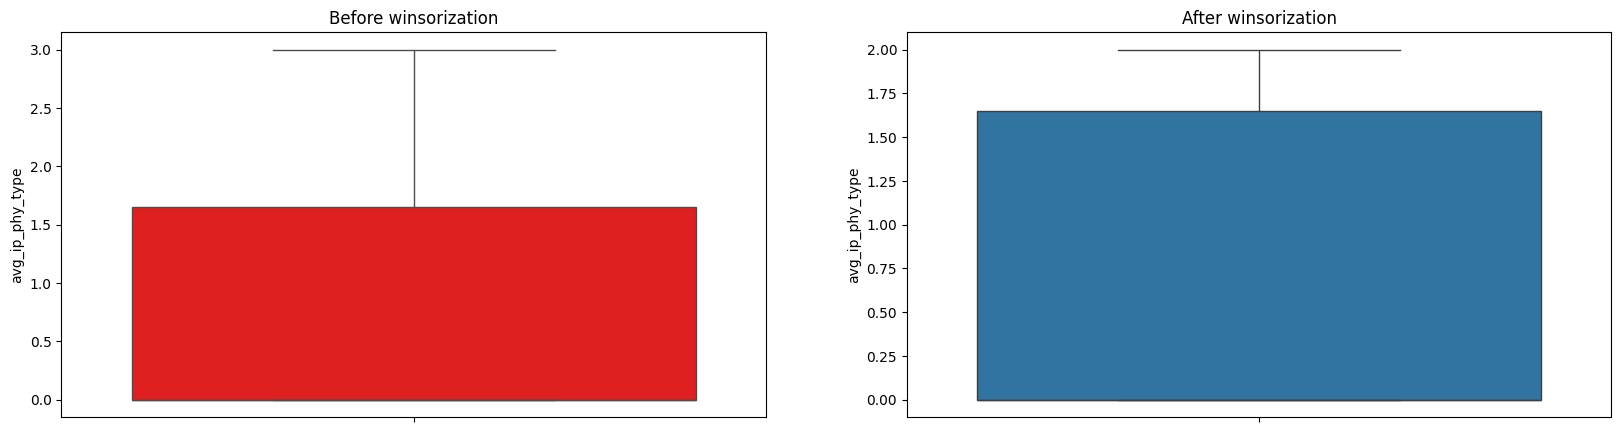

In [324]:
from scipy.stats.mstats import winsorize
x = df_final[columns_to_normalize]
for col in columns_to_normalize:
    x[col]= winsorize(x[col],(0,0.05)) 
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(20, 5))

    ax1.set_title('Before winsorization') 
    sns.boxplot(df_final[col], ax = ax1, color ='r')

    ax2.set_title('After winsorization')
    sns.boxplot(x[col], ax = ax2)

    plt.show()


In [325]:
for col in columns_to_normalize:
# Calculate the first and third quartiles
    Q1 = np.percentile(x[col], 25)
    Q3 = np.percentile(x[col], 75)

    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1

    # Define the thresholds for identifying outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count the number of outliers
    outliers = (x[col] < lower_bound) | (x[col] > upper_bound)
    num_outliers = np.sum(outliers)

    print(f"Number of outliers in {col}: {num_outliers}")

Number of outliers in mod_rate: 578
Number of outliers in avg_age: 208
Number of outliers in num_State: 390
Number of outliers in num_County: 401
Number of outliers in avg_cci_score: 223
Number of outliers in avg_op_claims_per_pat: 1012
Number of outliers in avg_op_reimbursement_per_claim: 0
Number of outliers in avg_op_deductible_per_claim: 0
Number of outliers in avg_op_claim_len: 0
Number of outliers in avg_op_phy_num: 431
Number of outliers in avg_op_phy_type: 922
Number of outliers in avg_ip_claims_per_pat: 0
Number of outliers in avg_ip_reimbursement_per_claim: 0
Number of outliers in avg_ip_deductible_per_claim: 0
Number of outliers in avg_ip_claim_len: 0
Number of outliers in avg_ip_hosp: 0
Number of outliers in avg_ip_phy_num: 0
Number of outliers in avg_ip_phy_type: 0


After applying winsorization by 10%, the remaning outliers are not extreme values, so it will not screw our dataset when applying minmax scaler.

In [326]:
df_final[columns_to_normalize] = x[columns_to_normalize]

#### Transformation on numerical columns

#####  Log Transformation with Shifting on right screwed columns

In [327]:
# # Some features are right screwed.
# # apply log transform to these columns
# columns_to_log = ['mod_rate', 'num_State', 'num_County', 'avg_op_reimbursement_per_claim',
#        'avg_op_deductible_per_claim', 'avg_ip_deductible_per_claim', 'avg_ip_phy_num']

# epsilon = 1e-6
# for col in columns_to_log:
#     df_final[col] = np.log1p(df_final[col]+epsilon)


In [328]:
# # Create subplots
# fig, axes = plt.subplots(int((len(columns_to_log)+1)/2), 2, figsize=(18, 6 * len(columns_to_log)))

# # Flatten the axes array for easy iteration
# axes = axes.flatten()

# for i, column in enumerate(columns_to_log):
#     # Plot histogram
#     sns.histplot(data=df_final, x=column, hue='PotentialFraud', kde=True, bins=20, ax=axes[i])
    
#     # Set the title and labels
#     axes[i].set_title(f'Histogram for Potential Fraud based on {column}')
#     axes[i].set_xlabel(column)
#     axes[i].set_ylabel('Frequency')

# # Adjust layout and show the plot
# plt.tight_layout()
# plt.show()

#### label encoding

In [329]:
# for col in cat_col:
#     # Flatten the list of diagnosis codes
#     all_codes = [code for sublist in df_final[col] for code in sublist]

#     # Initialize the LabelEncoder
#     label_encoder = LabelEncoder()
#     label_encoder.fit(all_codes)

#     # Apply label encoding to each diagnosis code in the DataFrame
#     df_final[col] = df_final[col].apply(lambda codes: label_encoder.transform(codes))


In [330]:
for col in cat_col:

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()
    df_final[col] = label_encoder.fit_transform(df_final[col])

In [331]:
df_final[cat_col]

Top_ClmAdmitDiagnosisCode_op  Top_ClmDiagnosisCode_op  \
0                              846                      213   
1                              846                      213   
2                              846                      213   
3                              846                      213   
4                              846                      213   
...                            ...                      ...   
5405                           763                      118   
5406                           816                      724   
5407                           255                      213   
5408                           846                      107   
5409                           549                      213   

      Top_ClmAdmitDiagnosisCode_ip  Top_DiagnosisGroupCode_ip  \
0                              393                        575   
1                              393                        575   
2                              393                        575   
3                              162                        229   
4                              227                        263   
...                            ...                        ...   
5405                           384                        131   
5406                           334                        241   
5407                           393                        575   
5408                           393                        575   
5409                           393                        575   

      Top_ClmDiagnosisCode_ip  Top_ClmProcedureCode_ip  
0                         259                      343  
1                         259                      343  
2                         259                      343  
3                          84                       89  
4                          84                       87  
...                       ...                      ...  
5405                       75                       73  
5406                       84                      318  
5407                      259                      343  
5408                      259                      343  
5409                      259                      343  

[5410 rows x 6 columns]

#### split label

In [332]:
y = df_final['PotentialFraud']
X = df_final.drop(['PotentialFraud', 'Provider'], axis=1)

In [333]:
X.columns

Index(['mod_rate', 'avg_age', 'num_State', 'num_County', 'avg_cci_score',
       'avg_op_claims_per_pat', 'avg_op_reimbursement_per_claim',
       'avg_op_deductible_per_claim', 'avg_op_claim_len', 'avg_op_phy_num',
       'avg_op_phy_type', 'Top_ClmAdmitDiagnosisCode_op',
       'Top_ClmDiagnosisCode_op', 'avg_ip_claims_per_pat',
       'avg_ip_reimbursement_per_claim', 'avg_ip_deductible_per_claim',
       'avg_ip_claim_len', 'avg_ip_hosp', 'avg_ip_phy_num', 'avg_ip_phy_type',
       'Top_ClmAdmitDiagnosisCode_ip', 'Top_DiagnosisGroupCode_ip',
       'Top_ClmDiagnosisCode_ip', 'Top_ClmProcedureCode_ip'],
      dtype='object')

#### Check multicollinearity - Detect and Remove Features with Correlation

Text(0.5, 1.0, 'Single corner heatmap')

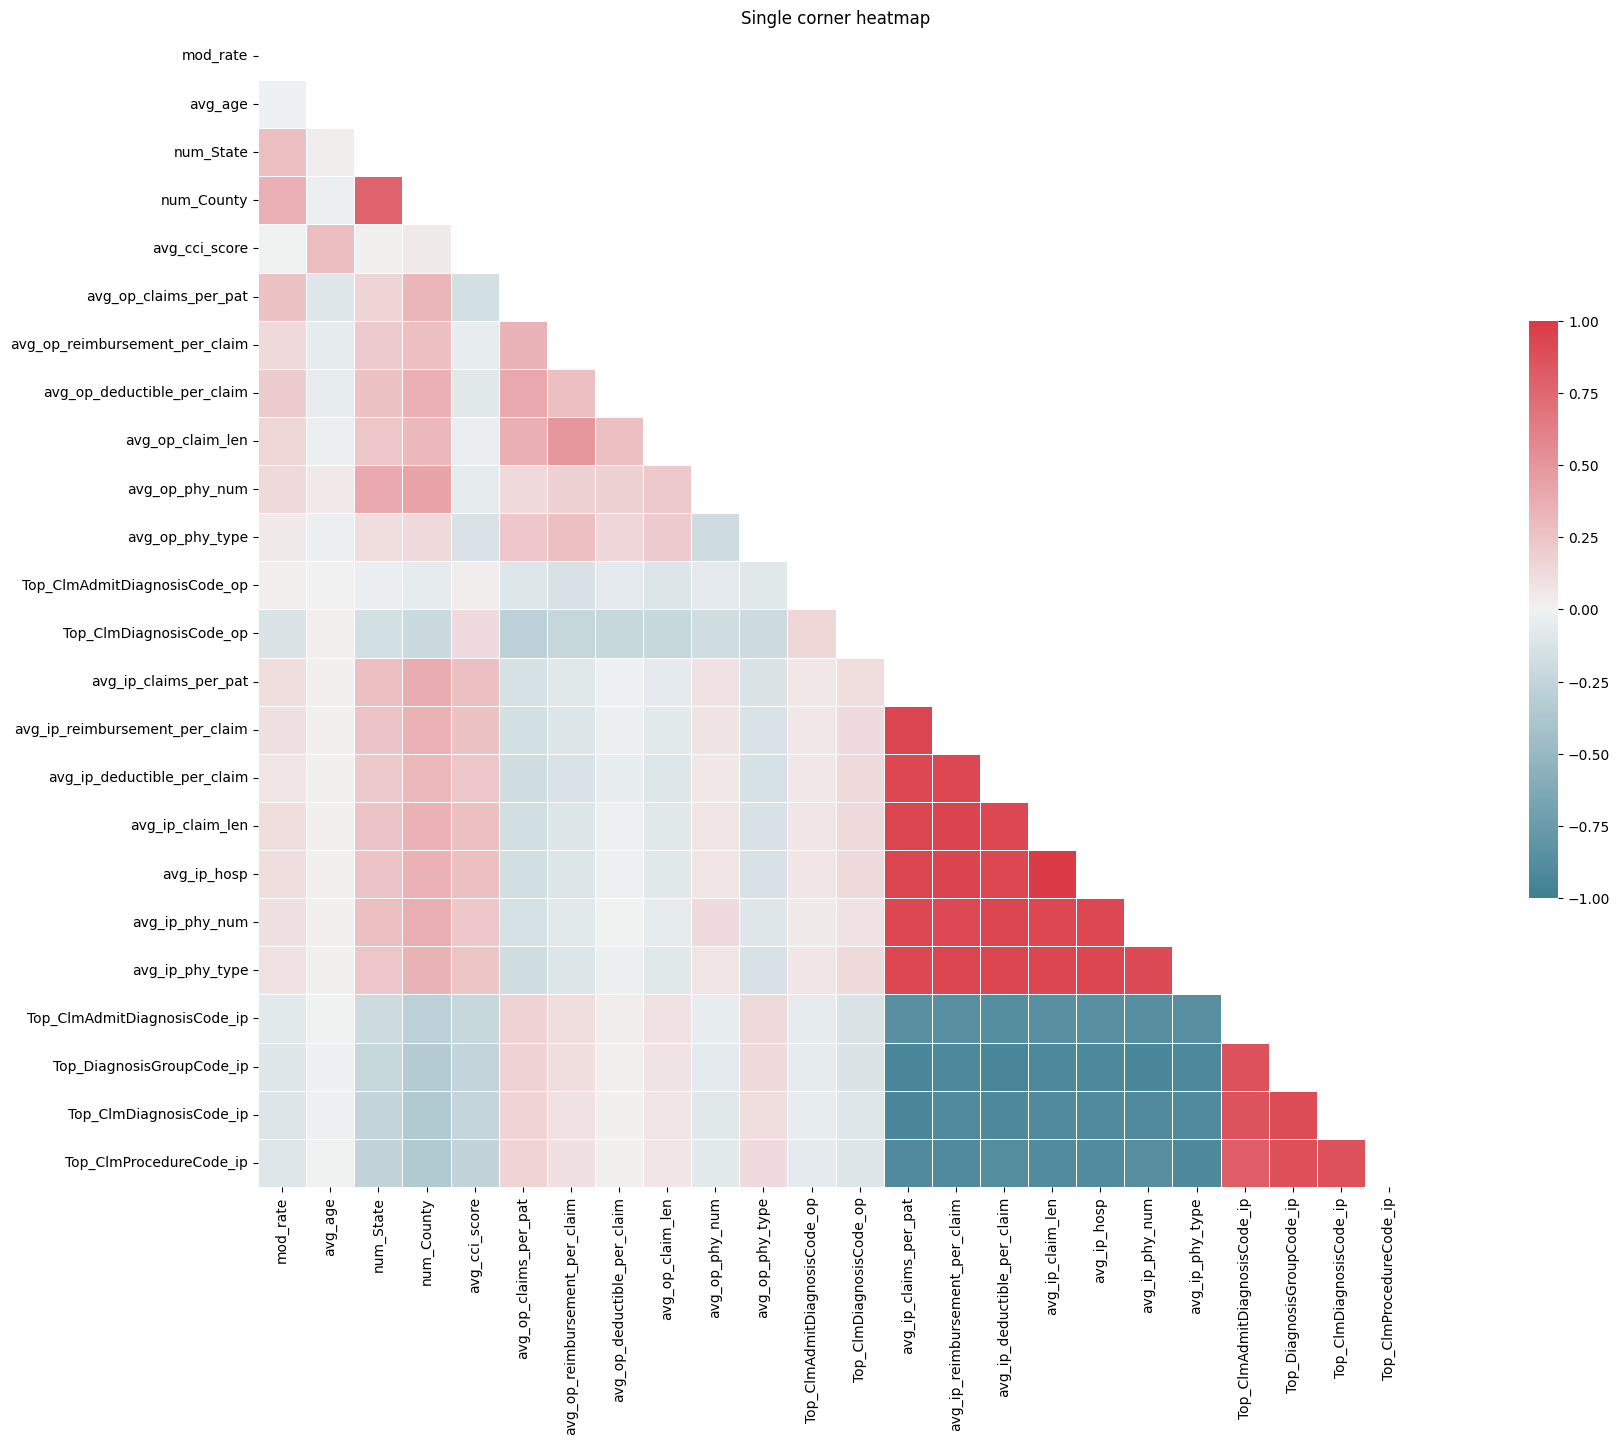

In [334]:
#plot correlation heat map between features
corr_matrix  = X.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(30, 15))

# Customize the color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})

# Set the title and display the heatmap
plt.title('Single corner heatmap')

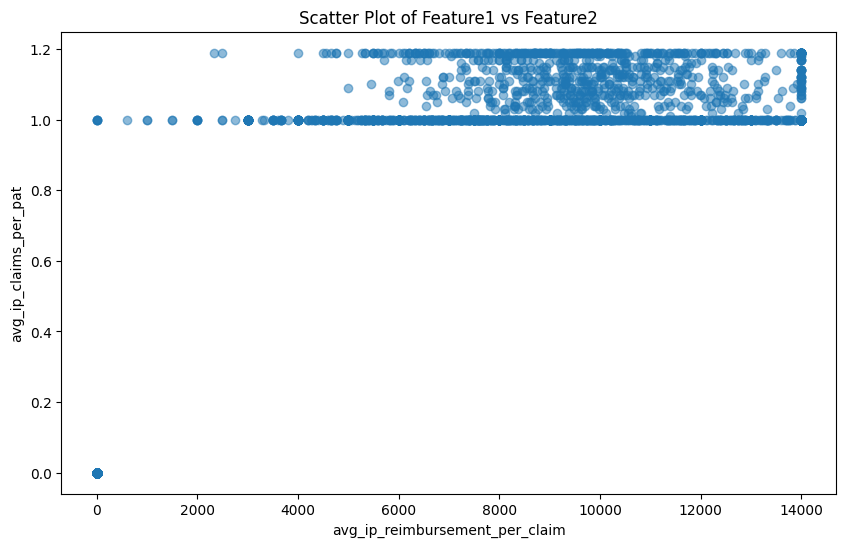

In [335]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X['avg_ip_reimbursement_per_claim'], X['avg_ip_claims_per_pat'], alpha=0.5)
plt.title('Scatter Plot of Feature1 vs Feature2')
plt.xlabel('avg_ip_reimbursement_per_claim')
plt.ylabel('avg_ip_claims_per_pat')
plt.show()

##### Use VIF to do feature selection

In [336]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Drop features with VIF > 10 (a common threshold)
X_reduced = X.drop(vif_data[vif_data["VIF"] > 10]["feature"], axis=1)
vif_data[vif_data["VIF"] > 10]
# X_reduced

feature           VIF
1                          avg_age    179.876191
4                    avg_cci_score     63.628730
5            avg_op_claims_per_pat     10.939615
9                   avg_op_phy_num     39.684373
10                 avg_op_phy_type     34.805437
13           avg_ip_claims_per_pat    139.893441
14  avg_ip_reimbursement_per_claim     13.622745
15     avg_ip_deductible_per_claim    105.852016
16                avg_ip_claim_len  14013.495536
17                     avg_ip_hosp  14022.003381
18                  avg_ip_phy_num     84.925663
19                 avg_ip_phy_type     41.880168
20    Top_ClmAdmitDiagnosisCode_ip     29.075055
21       Top_DiagnosisGroupCode_ip     22.043396
22         Top_ClmDiagnosisCode_ip     39.069511
23         Top_ClmProcedureCode_ip     21.808517

The remaining features still include the highly correlated num_state and num_county.

##### Feature Engineering: Combine or create new features to reduce multicollinearity

In [337]:
import pprint

# Find highly correlated columns
def correlation(dataset, threshold):
    col_corr = dict()  
    col_corr_l = [] 
    corr_matrix = dataset.corr(method='spearman')
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]  # getting the name of column
                col_corr[col1] = col2
                col_corr_l.append(corr_matrix.columns[i])
                col_corr_l.append(corr_matrix.columns[j])

    return col_corr, col_corr_l

corr_features,  col_corr_l= correlation(X, 0.7)
print('Correlated features count:', len(set(corr_features)))
print('Correlated features:')
pprint.pprint(corr_features)

Correlated features count: 11
Correlated features:
{'Top_ClmAdmitDiagnosisCode_ip': 'avg_ip_phy_type',
 'Top_ClmDiagnosisCode_ip': 'Top_DiagnosisGroupCode_ip',
 'Top_ClmProcedureCode_ip': 'Top_ClmDiagnosisCode_ip',
 'Top_DiagnosisGroupCode_ip': 'Top_ClmAdmitDiagnosisCode_ip',
 'avg_ip_claim_len': 'avg_ip_deductible_per_claim',
 'avg_ip_deductible_per_claim': 'avg_ip_reimbursement_per_claim',
 'avg_ip_hosp': 'avg_ip_claim_len',
 'avg_ip_phy_num': 'avg_ip_hosp',
 'avg_ip_phy_type': 'avg_ip_phy_num',
 'avg_ip_reimbursement_per_claim': 'avg_ip_claims_per_pat',
 'num_County': 'num_State'}


In [339]:
# VIF for reference, but it should be dynamic
col_corr_l = list(set(col_corr_l))
vif_dic = {}
for i in col_corr_l:
    vif_dic[i] = int(vif_data[vif_data["feature"] == i]["VIF"].values)

In [340]:
# The point biserial correlation: the relationship between a binary and a continuous variable
# Calculate point biserial correlation between the feature and the target variable

df_label0 = df_final[df_final['PotentialFraud'] == 0]
df_label1 = df_final[df_final['PotentialFraud'] == 1]

def calculate_rpb(col_lst):
    r_pb_dict = dict()
    for col in col_lst:
        col_mean_label1 = df_label1[col].mean()
        col_mean_label0 = df_label0[col].mean()
        sd = df_final[col].std()
        n1 = len(df_label1)
        n0 = len(df_label0)
        n = n0+n1
        r_pb = (col_mean_label1-col_mean_label0)/sd * pow(n1*n0/pow(n,2),0.5)
        r_pb_dict[col] = r_pb
    
    return r_pb_dict

calculate_rpb(col_corr_l)

{'Top_ClmAdmitDiagnosisCode_ip': -0.21291997618019917,
 'avg_ip_deductible_per_claim': 0.31683675881214474,
 'num_State': 0.30498397092012963,
 'avg_ip_reimbursement_per_claim': 0.3569307205182993,
 'avg_ip_hosp': 0.3563511488643099,
 'num_County': 0.35472808534779887,
 'Top_DiagnosisGroupCode_ip': -0.26453162332751007,
 'avg_ip_phy_num': 0.3223568652020905,
 'Top_ClmDiagnosisCode_ip': -0.3276349036201301,
 'avg_ip_phy_type': 0.3186278843322165,
 'Top_ClmProcedureCode_ip': -0.30378308986891495,
 'avg_ip_claims_per_pat': 0.3439922595068958,
 'avg_ip_claim_len': 0.3563910038809763}

In [341]:
# combine features
X['avg_ip_cost'] = (X['avg_ip_reimbursement_per_claim'] + X['avg_ip_deductible_per_claim'])* X['avg_ip_claims_per_pat'] 
X['area_range'] = X['num_County'] + X['num_State']

In [342]:
# drop features 
X.drop(columns=['num_County', 'num_State', 'avg_ip_reimbursement_per_claim'
                , 'avg_ip_deductible_per_claim', 'avg_ip_claims_per_pat'
                , 'avg_ip_hosp', 'avg_ip_phy_num', 'avg_ip_phy_type', 'avg_ip_claim_len'
                , 'Top_ClmProcedureCode_ip', 'Top_ClmDiagnosisCode_ip', 'Top_DiagnosisGroupCode_ip', 'Top_ClmAdmitDiagnosisCode_ip'], inplace=True)

Text(0.5, 1.0, 'Single corner heatmap')

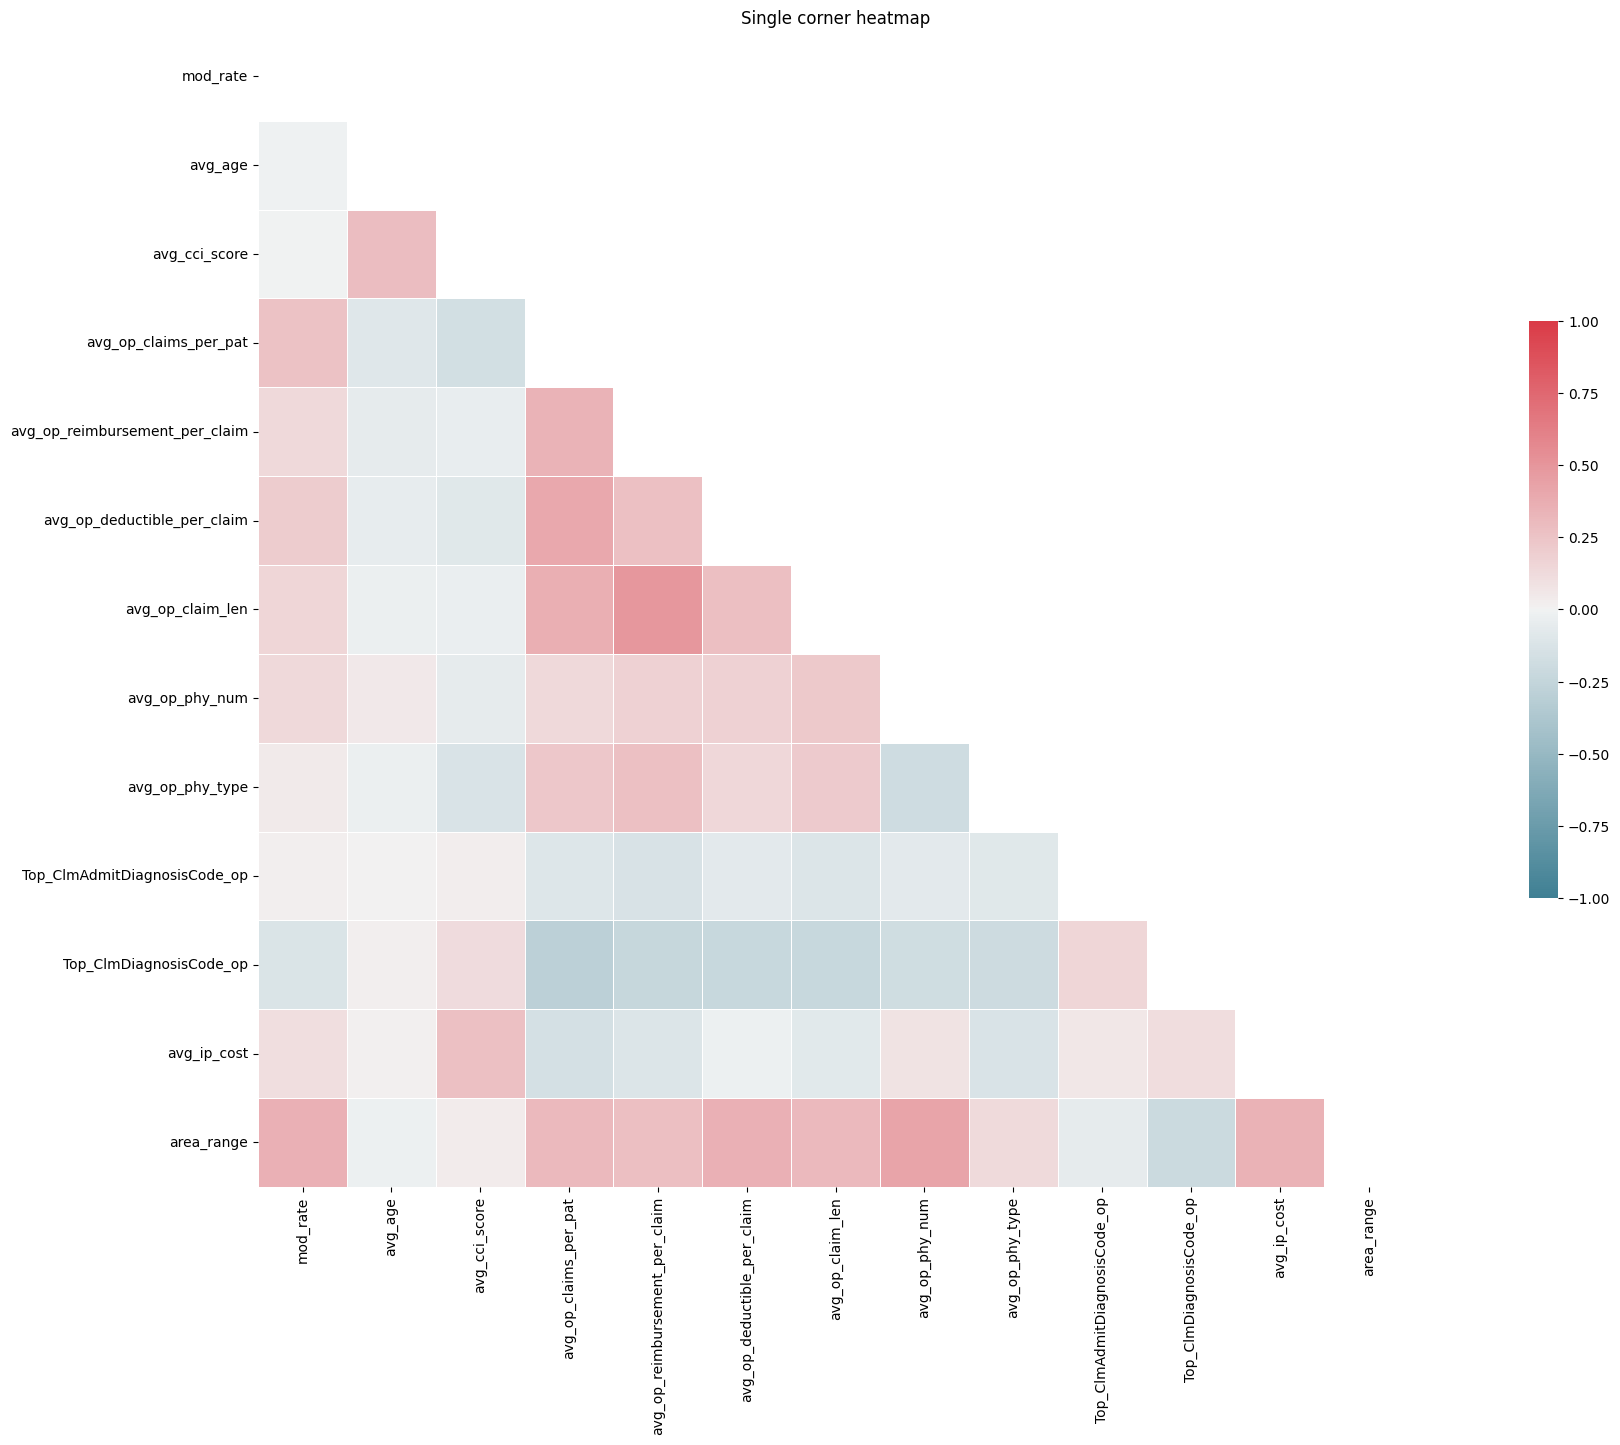

In [343]:
#plot correlation heat map between features
corr_matrix  = X.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(30, 15))

# Customize the color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})

# Set the title and display the heatmap
plt.title('Single corner heatmap')

In [344]:
corr_features,  col_corr_l= correlation(X, 0.7)
print('correlated features: ', len(set(corr_features)))
corr_features

correlated features:  0


{}

#### Train,Test Split

In [345]:
# split data into train, validation, test dataset
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)

print("Training X : ",X_train.shape," | Training Y : ",y_train.shape)
print("Validation X : ",X_val.shape," | Validation Y : ",y_val.shape)
print("Test X : ",X_test.shape," | Test Y : ",y_test.shape)

Training X :  (3462, 13)  | Training Y :  (3462,)
Validation X :  (866, 13)  | Validation Y :  (866,)
Test X :  (1082, 13)  | Test Y :  (1082,)


In [346]:
y_train.value_counts()
y_val.value_counts()

PotentialFraud
0    796
1     70
Name: count, dtype: int64

In [347]:
y_test.value_counts()

PotentialFraud
0    968
1    114
Name: count, dtype: int64

In [348]:
X_train.columns

Index(['mod_rate', 'avg_age', 'avg_cci_score', 'avg_op_claims_per_pat',
       'avg_op_reimbursement_per_claim', 'avg_op_deductible_per_claim',
       'avg_op_claim_len', 'avg_op_phy_num', 'avg_op_phy_type',
       'Top_ClmAdmitDiagnosisCode_op', 'Top_ClmDiagnosisCode_op',
       'avg_ip_cost', 'area_range'],
      dtype='object')

#### Normalization

In [349]:
columns_to_normalize = ['mod_rate', 'avg_age', 'avg_cci_score', 'avg_op_claims_per_pat',
       'avg_op_reimbursement_per_claim', 'avg_op_deductible_per_claim',
       'avg_op_claim_len', 'avg_op_phy_type', 'avg_ip_cost', 'area_range']

In [350]:
# after log transformation, the majority of columns are normally distributed
scaler = MinMaxScaler()
scaler.fit(X_train[columns_to_normalize])

X_train[columns_to_normalize] = scaler.transform(X_train[columns_to_normalize])
X_val[columns_to_normalize] = scaler.transform(X_val[columns_to_normalize])
X_test[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])

## Modeling

### Using all Features

#### SVM

In [458]:
svm = SVC(kernel='rbf', probability=True, class_weight = 'balanced', random_state=42)

parameters = { 'C': [1,3,5]
              , 'gamma': ['scale', 'auto']
              }

SVM_model_CV = GridSearchCV(svm, parameters, cv=5, scoring='recall', n_jobs=-1, return_train_score=True, verbose=10)
SVM_model_CV = SVM_model_CV.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",SVM_model_CV.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START C=1, gamma=scale............................................
[CV 2/5; 1/6] START C=1, gamma=scale............................................
[CV 3/5; 1/6] START C=1, gamma=scale............................................
[CV 4/5; 1/6] START C=1, gamma=scale............................................
[CV 5/5; 1/6] START C=1, gamma=scale............................................
[CV 1/5; 2/6] START C=1, gamma=auto.............................................
[CV 2/5; 2/6] START C=1, gamma=auto.............................................
[CV 3/5; 2/6] START C=1, gamma=auto.............................................
[CV 3/5; 2/6] END C=1, gamma=auto;, score=(train=0.911, test=0.656) total time=   2.1s
[CV 2/5; 2/6] END C=1, gamma=auto;, score=(train=0.930, test=0.631) total time=   2.1s
[CV 4/5; 2/6] START C=1, gamma=auto.............................................
[CV 1/5; 2/6] END C=1, gamma=auto;, s

In [461]:
# model with best hyperparameters:
SVM_model2 = SVC(kernel='rbf', C= 5, gamma= 'scale', probability=True, class_weight = 'balanced', random_state=42)
SVM_model2= SVM_model2.fit(X_train,y_train)

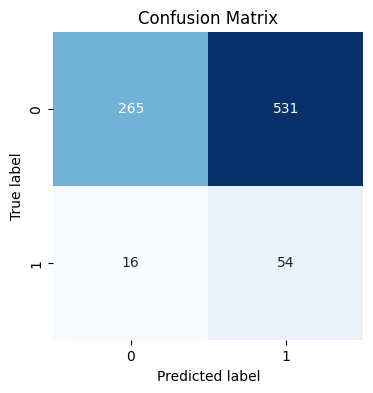

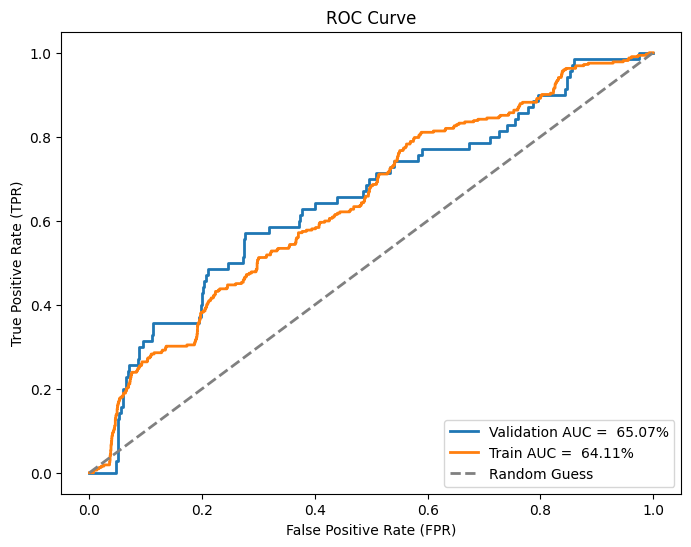

Accuracy:  36.84%
Precision:  9.23%
Recall:  77.14%
F1-score:  16.49%
AUC Value:  65.07%


In [462]:
svm_model_accuracy_score, svm_model_recall_score, svm_model_precision_score, svm_model_AUC_score = model_performence_check(SVM_model2,X_train,X_val,y_train,y_val)

#### Decision Tree

In [489]:
# Initialize the DecisionTreeClassifier with class_weight parameter
DT_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

parameters = {'max_depth': [5, 7, 9, 11]
              , 'min_samples_split': [5, 10, 45, 100, 135]
              , 'criterion': ['gini', 'entropy']
            #   , 'min_samples_leaf': [1, 5, 10]
              }

DT_model_CV = GridSearchCV(DT_model, parameters, cv=5, scoring='recall', n_jobs=-1, return_train_score=True, verbose=10)
DT_model_CV = DT_model_CV.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",DT_model_CV.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START criterion=gini, max_depth=5, min_samples_split=5...........
[CV 2/5; 1/40] START criterion=gini, max_depth=5, min_samples_split=5...........
[CV 3/5; 1/40] START criterion=gini, max_depth=5, min_samples_split=5...........
[CV 4/5; 1/40] START criterion=gini, max_depth=5, min_samples_split=5...........
[CV 5/5; 1/40] START criterion=gini, max_depth=5, min_samples_split=5...........
[CV 1/5; 2/40] START criterion=gini, max_depth=5, min_samples_split=10..........
[CV 1/5; 1/40] END criterion=gini, max_depth=5, min_samples_split=5;, score=(train=0.949, test=0.815) total time=   0.0s
[CV 2/5; 1/40] END criterion=gini, max_depth=5, min_samples_split=5;, score=(train=0.961, test=0.846) total time=   0.0s
[CV 2/5; 2/40] START criterion=gini, max_depth=5, min_samples_split=10..........
[CV 3/5; 2/40] START criterion=gini, max_depth=5, min_samples_split=10..........
[CV 3/5; 1/40] END criterion=gini, max_depth=5, 

In [490]:
# model with best hyperparameters:
DT_model2 = DecisionTreeClassifier(class_weight='balanced', criterion = 'entropy', max_depth = 5, min_samples_split = 45, random_state=42)
DT_model2=DT_model2.fit(X_train,y_train)


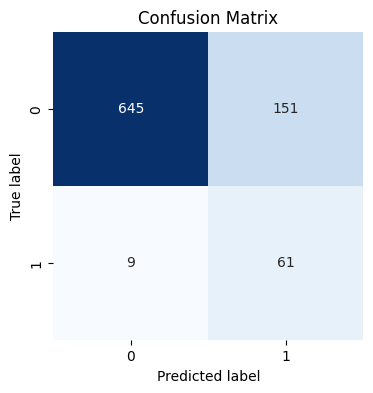

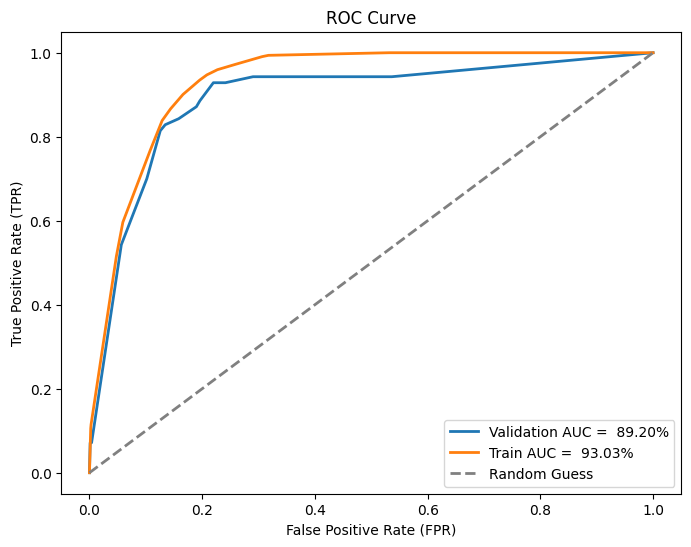

Accuracy:  81.52%
Precision:  28.77%
Recall:  87.14%
F1-score:  43.26%
AUC Value:  89.20%


In [491]:
dt_model_accuracy_score, dt_model_recall_score, dt_model_precision_score, dt_model_AUC_score = model_performence_check(DT_model2,X_train,X_val,y_train,y_val)

#### Random Forest


In [521]:
RF = RandomForestClassifier(class_weight = 'balanced', random_state=42)

param_grid = { 
    'n_estimators': [100, 150, 200, 300],
    # 'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,5,7,9,11],
    'criterion' :['gini', 'entropy']
}


RF_CV = GridSearchCV(estimator=RF, param_grid=param_grid, cv= 5,scoring='recall', n_jobs=-1, return_train_score=True, verbose=10)
RF_CV.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",RF_CV.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START criterion=gini, max_depth=3, n_estimators=100..............
[CV 2/5; 1/40] START criterion=gini, max_depth=3, n_estimators=100..............
[CV 3/5; 1/40] START criterion=gini, max_depth=3, n_estimators=100..............
[CV 4/5; 1/40] START criterion=gini, max_depth=3, n_estimators=100..............
[CV 5/5; 1/40] START criterion=gini, max_depth=3, n_estimators=100..............
[CV 1/5; 2/40] START criterion=gini, max_depth=3, n_estimators=150..............
[CV 2/5; 2/40] START criterion=gini, max_depth=3, n_estimators=150..............
[CV 3/5; 2/40] START criterion=gini, max_depth=3, n_estimators=150..............
[CV 5/5; 1/40] END criterion=gini, max_depth=3, n_estimators=100;, score=(train=0.872, test=0.750) total time=   0.3s
[CV 1/5; 1/40] END criterion=gini, max_depth=3, n_estimators=100;, score=(train=0.864, test=0.877) total time=   0.3s
[CV 4/5; 2/40] START criterion=gini, max_depth=3, n_es

In [522]:
RF2 = RandomForestClassifier(n_estimators = 200,max_depth=3,criterion='gini',
                             class_weight = 'balanced', random_state=42
                             )

RF2=RF2.fit(X_train,y_train)

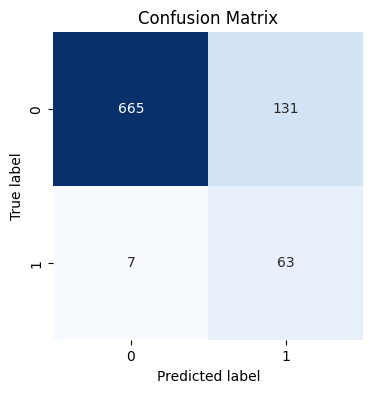

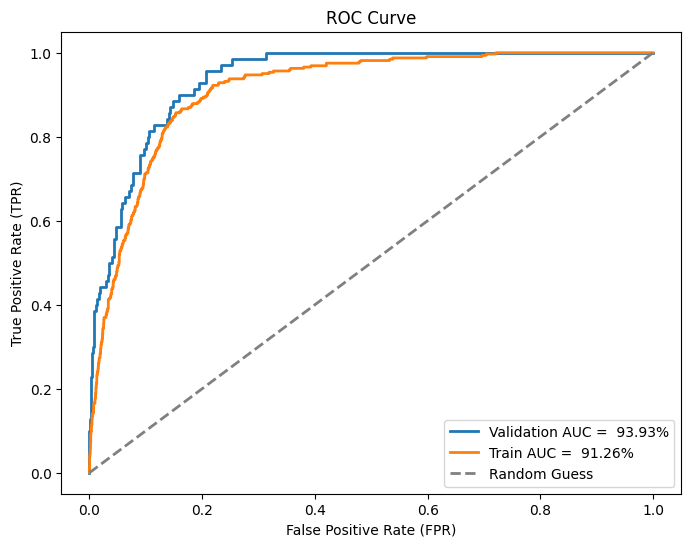

Accuracy:  84.06%
Precision:  32.47%
Recall:  90.00%
F1-score:  47.73%
AUC Value:  93.93%


In [523]:
rf_model_accuracy_score, rf_model_recall_score, rf_model_precision_score, rf_model_AUC_score = model_performence_check(RF2,X_train,X_val,y_train,y_val)

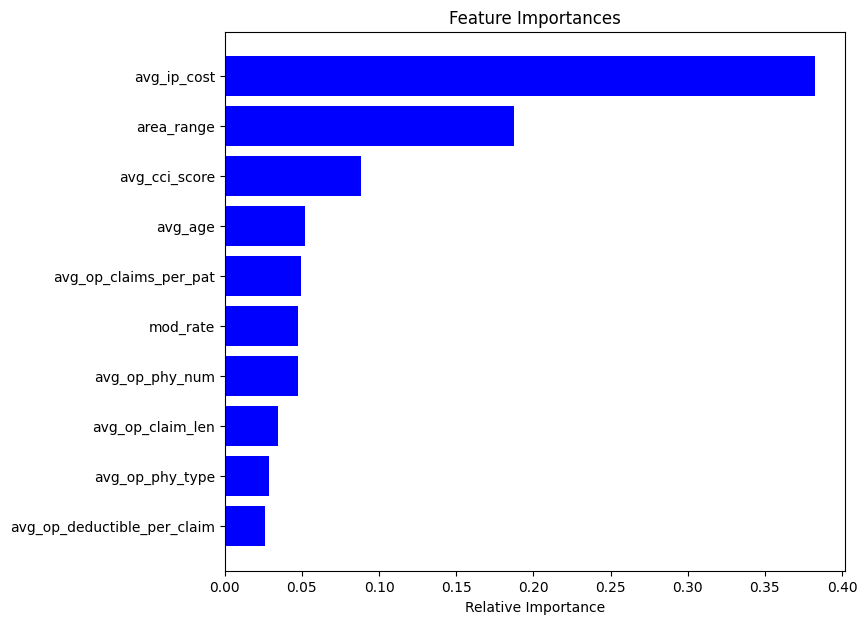

In [476]:
features = X_train.columns
importances = RF2.feature_importances_
indices = (np.argsort(importances))[-10:]
plt.figure(figsize=(8,7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### XG_Boost

In [362]:
scale_pos_weight = y_train.value_counts()[0]/y_train.value_counts()[1]
scale_pos_weight

9.751552795031056

In [529]:
from scipy.stats import uniform, randint

XGB = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, objective= 'binary:logistic', random_state=42)

parameters = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
}


XGB_CV = GridSearchCV(XGB, parameters , cv=5, scoring='recall', n_jobs=-1,return_train_score=True, verbose=10)
XGB_CV.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",XGB_CV.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 1/5; 1/243] START gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100
[CV 2/5; 1/243] START gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100
[CV 3/5; 1/243] START gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100
[CV 4/5; 1/243] START gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100
[CV 5/5; 1/243] START gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100
[CV 1/5; 2/243] START gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200
[CV 2/5; 2/243] START gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200
[CV 3/5; 2/243] START gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200
[CV 3/5; 1/243] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100;, score=(train=0.903, test=0.

In [530]:
XGB2 = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight
                         , random_state=42
                         , gamma = 0
                         , learning_rate = 0.01
                         , max_depth = 3
                         , min_child_weight = 5
                         , n_estimators = 200)

XGB2=XGB2.fit(X_train,y_train)

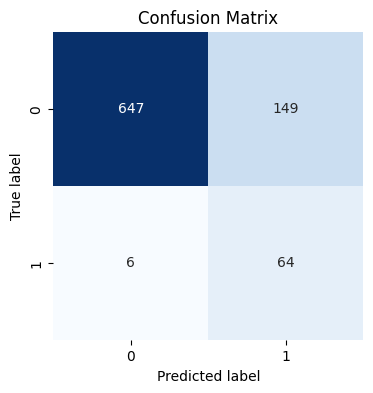

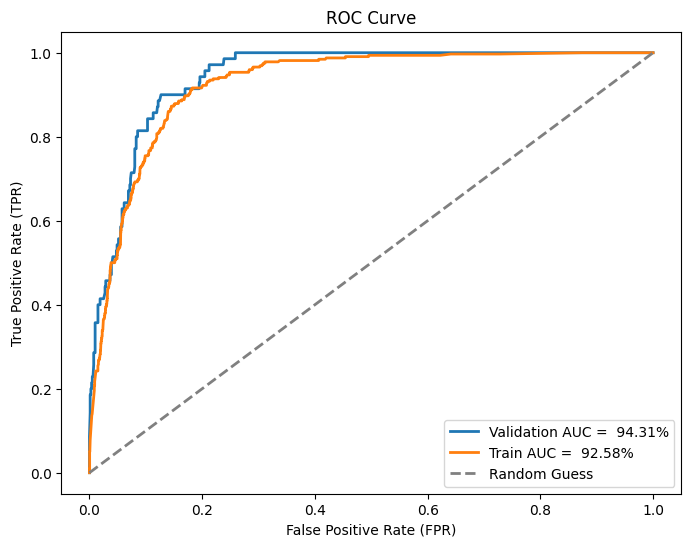

Accuracy:  82.10%
Precision:  30.05%
Recall:  91.43%
F1-score:  45.23%
AUC Value:  94.31%


In [531]:
xg_model_accuracy_score, xg_model_recall_score, xg_model_precision_score, xg_model_AUC_score = model_performence_check(XGB2,X_train,X_val,y_train,y_val)

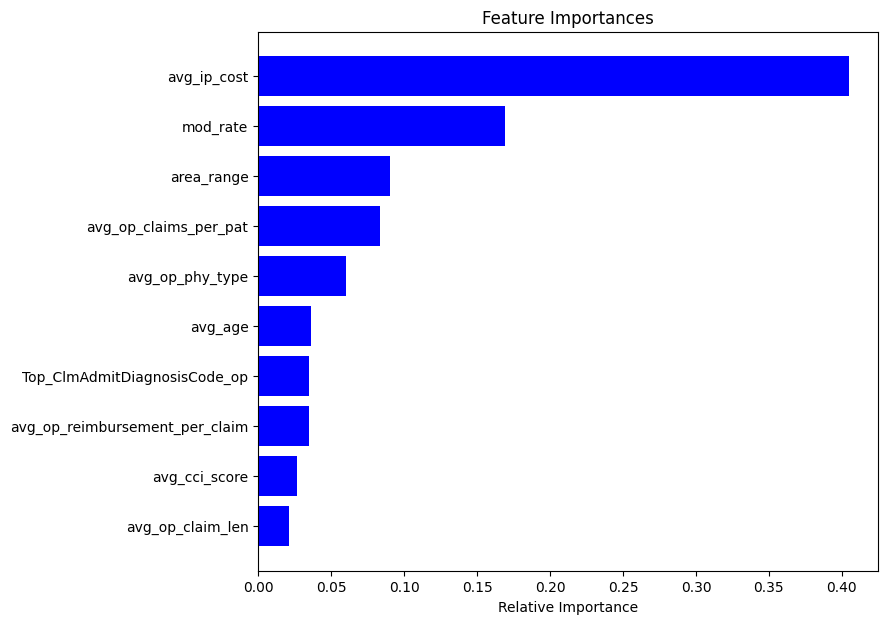

In [533]:
features = X_train.columns
importances = XGB2.feature_importances_
indices = (np.argsort(importances))[-10:]
plt.figure(figsize=(8,7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### plot model performence summary graph


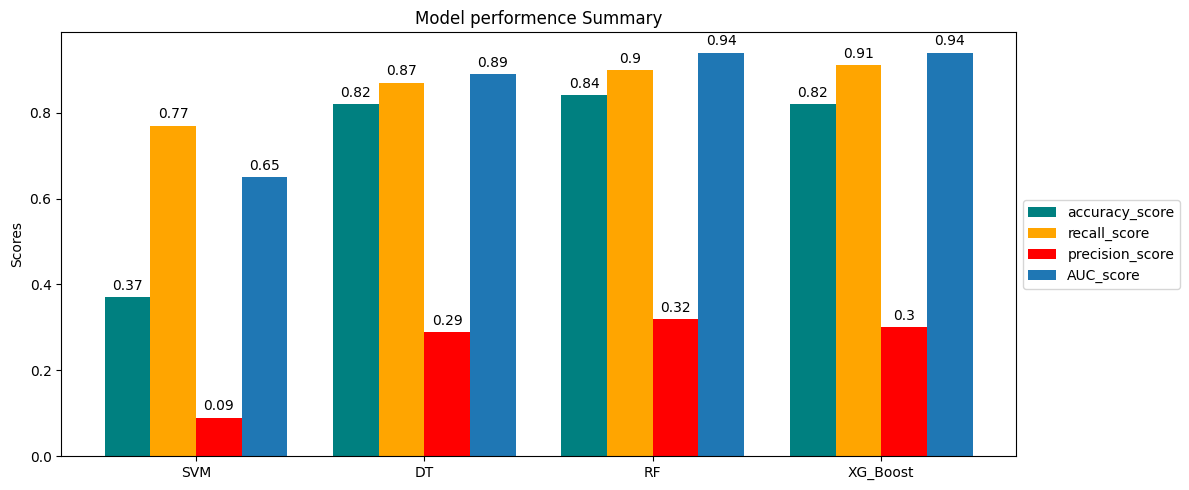

In [534]:
model = ['SVM','DT','RF','XG_Boost']
accuracy_score_all = [round(num, 2) for num in [svm_model_accuracy_score,dt_model_accuracy_score, rf_model_accuracy_score, xg_model_accuracy_score]]
recall_score_all = [round(num, 2) for num in [svm_model_recall_score,dt_model_recall_score, rf_model_recall_score, xg_model_recall_score]]
precision_score_all = [round(num, 2) for num in [svm_model_precision_score,dt_model_precision_score, rf_model_precision_score, xg_model_precision_score]]
AUC_score_all = [round(num, 2) for num in [svm_model_AUC_score,dt_model_AUC_score,rf_model_AUC_score,xg_model_AUC_score]]

model_comp(model,accuracy_score_all, recall_score_all, precision_score_all, AUC_score_all,'Scores','Model performence Summary','accuracy_score','recall_score','precision_score','AUC_score')

### Select the model and combine val and train to retrain the selected model

XG_Boost performs slightly better than other models

In [525]:
# combine training and validation data
X_combined = pd.concat([X_train, X_val], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)

In [535]:
scale_pos_weight_final = y_combined.value_counts()[0]/y_combined.value_counts()[1]
scale_pos_weight_final

10.040816326530612

In [546]:
XGB = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight_final, objective= 'binary:logistic')

parameters = {
     'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.3],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [1, 1.5, 2]
}

XGB_CV = GridSearchCV(XGB, parameters , cv=5, scoring='recall', n_jobs=-1,return_train_score=True, verbose=10)
XGB_CV.fit(X_combined,y_combined)

print("tuned hpyerparameters :(best parameters) ",XGB_CV.best_params_)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


[CV 3/5; 1/2187] START gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1
[CV 3/5; 2/2187] START gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.5
[CV 1/5; 1/2187] START gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1
[CV 5/5; 1/2187] START gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1
[CV 1/5; 2/2187] START gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.5
[CV 3/5; 1/2187] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1;, score=(train=0.927, test=0.886) total time=   0.5s
[CV 3/5; 2/2187] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.5;, score=(train=0.927, test=0.886) total ti

In [593]:
XGB2 = xgb.XGBClassifier(
                        scale_pos_weight=scale_pos_weight
                         , random_state=42
                         , gamma = 0
                         , learning_rate = 0.01
                         , max_depth = 3
                         , min_child_weight = 15
                         , n_estimators = 100
                         , reg_alpha = 0
                         , reg_lambda = 1
)

XGB2=XGB2.fit(X_combined,y_combined)

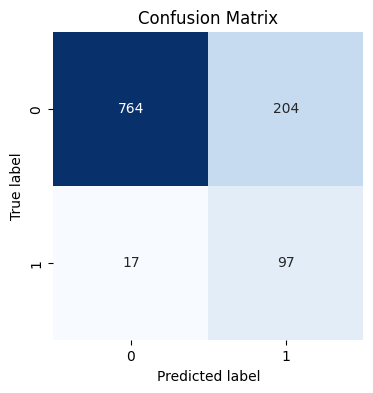

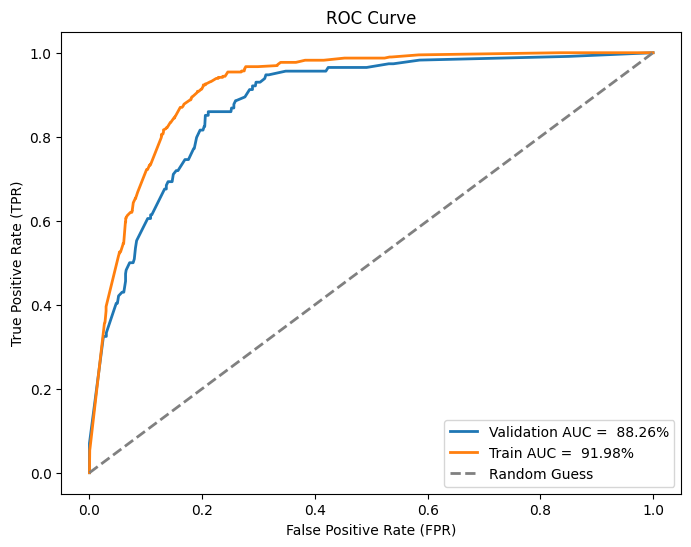

Accuracy:  79.57%
Precision:  32.23%
Recall:  85.09%
F1-score:  46.75%
AUC Value:  88.26%


In [594]:
xg_final_accuracy_score, xg_final_recall_score, xg_final_precision_score, xg_final_AUC_score = model_performence_check(XGB2,X_combined,X_test,y_combined,y_test)

### Save the model

In [595]:
import joblib
joblib.dump(XGB2, 'Xgb_model.pkl') 


['Xgb_model.pkl']